In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel 
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
import math

In [5]:
pip install torch

     |████████████████████████████████| 139.5 MB 57 kB/s  eta 0:00:011       | 98.7 MB 7.9 MB/s eta 0:00:06�████████████████████▍      | 110.6 MB 3.4 MB/s eta 0:00:09
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm


In [9]:
pip install torchvision

     |████████████████████████████████| 1.5 MB 3.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [10]:
## this function is from Prof. Chugg's fmnist_mlp_torch.ipynb
## https://github.com/keithchugg/ee559_spring2023/blob/main/lecture/fmnist_mlp_torch.ipynb
# All datasets are subclasses of torch.utils.data.Dataset i.e, they have __getitem__ and __len__ methods implemented
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]) # transforms.ToTensor() converts the image to a tensor and transforms.Normalize() normalizes the tensor
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

100%|██████████| 26421880/26421880 [01:02<00:00, 423939.33it/s] 


Extracting /Users/shivanshamattya/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /Users/shivanshamattya/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 182033.09it/s]


Extracting /Users/shivanshamattya/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /Users/shivanshamattya/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2634190.39it/s]


Extracting /Users/shivanshamattya/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/shivanshamattya/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7051690.72it/s]

Extracting /Users/shivanshamattya/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/shivanshamattya/.pytorch/F_MNIST_data/FashionMNIST/raw



In [11]:
## this function is from Prof. Chugg's fmnist_mlp_torch.ipynb
## https://github.com/keithchugg/ee559_spring2023/blob/main/lecture/fmnist_mlp_torch.ipynb
trainset, valset = torch.utils.data.random_split(trainset, [48000, 12000])
# Final sizes are 50000, 10000, 10000
print(f'Train set size: {len(trainset)}, Validation set size: {len(valset)}, Test set size: {len(testset)}')

Train set size: 48000, Validation set size: 12000, Test set size: 10000


In [12]:
## this function is from Prof. Chugg's fmnist_mlp_torch.ipynb
## https://github.com/keithchugg/ee559_spring2023/blob/main/lecture/fmnist_mlp_torch.ipynb
# Parameters for the model
# Define the model
class MLP(nn.Module):
    def __init__(self, n_hidden): # Define layers in the constructor
        super().__init__()
        self.fc1 = nn.Linear(28*28, n_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden,10)
        
    def forward(self, x): # Define forward pass in the forward method
        x = x.view(x.shape[0], -1)  #flatten into a 784 length tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x # note: no softmax, as this is included in the loss function in PyTorch

In [13]:
model=MLP(48)
model

MLP(
  (fc1): Linear(in_features=784, out_features=48, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=48, out_features=10, bias=True)
)

In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.torch.backends.mps.is_available():
    device = torch.device("mps") # MPS acceleration is available on MacOS 12.3+
else:
    device = torch.device("cpu")

In [15]:
device

device(type='cpu')

In [16]:
## this function is from Prof. Chugg's fmnist_mlp_torch.ipynb
## https://github.com/keithchugg/ee559_spring2023/blob/main/lecture/fmnist_mlp_torch.ipynb
lr = 1e-2   ## the learning rate in TF is part of the optimizer.  Default is 1e-2
reg_val = 1e-4
criterion = nn.CrossEntropyLoss() # includes softmax (for numerical stability)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg_val)

In [17]:
## this function is from Prof. Chugg's fmnist_mlp_torch.ipynb
## https://github.com/keithchugg/ee559_spring2023/blob/main/lecture/fmnist_mlp_torch.ipynb
# Define function to call for each training epoch (one complete pass over the training set)
def train(model, trainloader, criterion, optimizer,device):
    model.train() # set model to training mode
    running_loss = 0; running_acc = 0
    with tqdm(total=len(trainloader), desc=f"Train", unit="batch") as pbar:
        for n_batch, (images, labels) in enumerate(trainloader): # Iterate over batches
            images, labels = images.to(device), labels.to(device) # Move batch to device
            optimizer.zero_grad()
            output = model(images) # Forward pass
            loss = criterion(output, labels) # Compute loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights
            running_loss += loss.item()
            running_acc += (output.argmax(1) == labels).float().mean().item()
            pbar.set_postfix({'loss': loss.item(), 'acc': 100. * running_acc / (n_batch+1)})
            pbar.update() # Update progress bar
    return running_loss / len(trainloader), running_acc / len(trainloader) # return loss and accuracy for this epoch

In [18]:

## this function is from Prof. Chugg's fmnist_mlp_torch.ipynb
## https://github.com/keithchugg/ee559_spring2023/blob/main/lecture/fmnist_mlp_torch.ipynb
# Define function to call for each validation epoch (one complete pass over the validation set)
def validate(model, valloader, criterion,device):
    model.eval() # set model to evaluation mode (e.g. turn off dropout, batchnorm, etc.)
    running_loss = 0; running_acc = 0
    with torch.no_grad(): # no need to compute gradients for validation
        with tqdm(total=len(valloader), desc=f"Eval", unit="batch") as pbar:
            for n_batch, (images, labels) in enumerate(valloader): # Iterate over batches
                images, labels = images.to(device), labels.to(device) # Move batch to device
                output = model(images) # Forward pass
                loss = criterion(output, labels) # Compute loss
                running_loss += loss.item() 
                running_acc += (output.argmax(1) == labels).float().mean().item()
                pbar.set_postfix({'loss': loss.item(), 'acc': 100. * running_acc / (n_batch+1)})
                pbar.update() # Update progress bar
    return running_loss / len(valloader), running_acc / len(valloader)  # return loss and accuracy for this epoc

In [20]:
## this function is from Prof. Chugg's fmnist_mlp_torch.ipynb
## https://github.com/keithchugg/ee559_spring2023/blob/main/lecture/fmnist_mlp_torch.ipynb
# Run training and validation loop
# Save the best model based on validation accuracy
i=0
batchsize = 32
# Shuffle the data at the start of each epoch (only useful for training set)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)

while(i<5):
  model=MLP(48)
  criterion = nn.CrossEntropyLoss() # includes softmax (for numerical stability)
  optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001)
  n_epochs = 2
  best_acc = -1
  train_loss_history = []; train_acc_history = []
  val_loss_history = []; val_acc_history = []
  for epoch in range(n_epochs): # Iterate over epochs
      print(f"Epoch {epoch+1} of {n_epochs}")
      train_loss, train_acc  = train(model, trainloader, criterion, optimizer,device) # Train
      val_loss, val_acc = validate(model, valloader, criterion) # Validate
      train_loss_history.append(train_loss); train_acc_history.append(train_acc)
      val_loss_history.append(val_loss); val_acc_history.append(val_acc)
      print(f"Val Acc {val_acc}")
  print("#"*50)
  i+=1

Train:   1%|          | 14/1500 [00:00<00:25, 58.33batch/s, loss=2.15, acc=27.9]

Epoch 1 of 2


Train:  58%|█████▊    | 874/1500 [00:08<00:06, 103.93batch/s, loss=0.572, acc=73.3]


KeyboardInterrupt: 

In [39]:
## this function is from Prof. Chugg's fmnist_mlp_torch.ipynb
## https://github.com/keithchugg/ee559_spring2023/blob/main/lecture/fmnist_mlp_torch.ipynb
# Run training and validation loop
# Save the best model based on validation accuracy
i=0
batchsize = 512
# Shuffle the data at the start of each epoch (only useful for training set)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)

while(i<5):
  model=MLP(48)
  criterion = nn.CrossEntropyLoss() # includes softmax (for numerical stability)
  optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001)
  n_epochs = 12
  best_acc = -1
  train_loss_history = []; train_acc_history = []
  val_loss_history = []; val_acc_history = []
  for epoch in range(n_epochs): # Iterate over epochs
      print(f"Epoch {epoch+1} of {n_epochs}")
      train_loss, train_acc  = train(model, trainloader, criterion, optimizer) # Train
      val_loss, val_acc = validate(model, valloader, criterion) # Validate
      train_loss_history.append(train_loss); train_acc_history.append(train_acc)
      val_loss_history.append(val_loss); val_acc_history.append(val_acc)
      print(f"Val Acc {val_acc}")
  print("#"*50)
  i+=1

Epoch 1 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.69batch/s, loss=1.27, acc=66.4]


Val Acc 0.6641787563761076
Epoch 2 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  7.02batch/s, loss=0.944, acc=72.3]


Val Acc 0.722644624610742
Epoch 3 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.49batch/s, loss=0.82, acc=74.1]


Val Acc 0.7412341882785162
Epoch 4 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.87batch/s, loss=0.755, acc=75.6]


Val Acc 0.7555454795559248
Epoch 5 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.22batch/s, loss=0.716, acc=76.6]


Val Acc 0.7656482507785162
Epoch 6 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.66batch/s, loss=0.685, acc=77.6]


Val Acc 0.776111421485742
Epoch 7 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.80batch/s, loss=0.66, acc=78.3]


Val Acc 0.783458891014258
Epoch 8 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.15batch/s, loss=0.636, acc=79]


Val Acc 0.7904692143201828
Epoch 9 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.52batch/s, loss=0.62, acc=79.7]


Val Acc 0.7968168705701828
Epoch 10 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.57batch/s, loss=0.605, acc=80.1]


Val Acc 0.8010951454440752
Epoch 11 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.57batch/s, loss=0.594, acc=80.5]


Val Acc 0.8053501670559248
Epoch 12 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.33batch/s, loss=0.583, acc=81]


Val Acc 0.8101283485690752
##################################################
Epoch 1 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.53batch/s, loss=1.23, acc=67.1]


Val Acc 0.6707705532511076
Epoch 2 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.47batch/s, loss=0.928, acc=72.2]


Val Acc 0.7215518032511076
Epoch 3 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.21batch/s, loss=0.814, acc=73.9]


Val Acc 0.739013671875
Epoch 4 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.59batch/s, loss=0.748, acc=75.6]


Val Acc 0.7558128709594408
Epoch 5 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.53batch/s, loss=0.704, acc=76.7]


Val Acc 0.7672758549451828
Epoch 6 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.56batch/s, loss=0.678, acc=77.4]


Val Acc 0.7740769162774086
Epoch 7 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.56batch/s, loss=0.657, acc=78.1]


Val Acc 0.7810756141940752
Epoch 8 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.95batch/s, loss=0.632, acc=79]


Val Acc 0.7898879274725914
Epoch 9 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.28batch/s, loss=0.62, acc=79.6]


Val Acc 0.7955031618475914
Epoch 10 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.17batch/s, loss=0.601, acc=80]


Val Acc 0.8004441037774086
Epoch 11 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.48batch/s, loss=0.59, acc=80.6]


Val Acc 0.8055710569024086
Epoch 12 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.12batch/s, loss=0.578, acc=80.8]


Val Acc 0.8081635981798172
##################################################
Epoch 1 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.48batch/s, loss=1.31, acc=68.5]


Val Acc 0.6846284419298172
Epoch 2 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.85batch/s, loss=0.947, acc=73]


Val Acc 0.7295503169298172
Epoch 3 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.54batch/s, loss=0.81, acc=74.9]


Val Acc 0.7494768425822258
Epoch 4 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.53batch/s, loss=0.741, acc=76.1]


Val Acc 0.7612537195285162
Epoch 5 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.83batch/s, loss=0.699, acc=77.1]


Val Acc 0.7713913694024086
Epoch 6 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.66batch/s, loss=0.669, acc=77.9]


Val Acc 0.779064359764258
Epoch 7 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.08batch/s, loss=0.649, acc=78.6]


Val Acc 0.786388578514258
Epoch 8 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.28batch/s, loss=0.624, acc=79.3]


Val Acc 0.7934105272094408
Epoch 9 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.80batch/s, loss=0.612, acc=79.9]


Val Acc 0.7986188605427742
Epoch 10 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.60batch/s, loss=0.592, acc=80.2]


Val Acc 0.8019787023464838
Epoch 11 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.57batch/s, loss=0.584, acc=80.7]


Val Acc 0.8073497960964838
Epoch 12 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.43batch/s, loss=0.569, acc=80.9]


Val Acc 0.8089541470011076
##################################################
Epoch 1 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.45batch/s, loss=1.35, acc=62.4]


Val Acc 0.6244652147094408
Epoch 2 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  4.98batch/s, loss=0.993, acc=71.6]


Val Acc 0.7158784419298172
Epoch 3 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.58batch/s, loss=0.843, acc=74.1]


Val Acc 0.7414783289035162
Epoch 4 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.07batch/s, loss=0.766, acc=75.8]


Val Acc 0.7581031446655592
Epoch 5 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.30batch/s, loss=0.719, acc=76.8]


Val Acc 0.7684849326809248
Epoch 6 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.59batch/s, loss=0.69, acc=77.7]


Val Acc 0.7772158657511076
Epoch 7 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.22batch/s, loss=0.669, acc=78.5]


Val Acc 0.78515625
Epoch 8 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.64batch/s, loss=0.648, acc=79.1]


Val Acc 0.7912830164035162
Epoch 9 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.28batch/s, loss=0.626, acc=79.7]


Val Acc 0.7969215040405592
Epoch 10 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.45batch/s, loss=0.617, acc=80.1]


Val Acc 0.8006649936238924
Epoch 11 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.22batch/s, loss=0.601, acc=80.6]


Val Acc 0.8061058397094408
Epoch 12 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.19batch/s, loss=0.587, acc=80.8]


Val Acc 0.8082798545559248
##################################################
Epoch 1 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.54batch/s, loss=1.27, acc=66.9]


Val Acc 0.6686546678344408
Epoch 2 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.00batch/s, loss=0.959, acc=72.6]


Val Acc 0.7257486979166666
Epoch 3 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.62batch/s, loss=0.827, acc=74.4]


Val Acc 0.7435593381524086
Epoch 4 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.68batch/s, loss=0.755, acc=76]


Val Acc 0.7595796138048172
Epoch 5 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.56batch/s, loss=0.716, acc=76.7]


Val Acc 0.7674386153618494
Epoch 6 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.62batch/s, loss=0.679, acc=77.6]


Val Acc 0.7757393966118494
Epoch 7 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.46batch/s, loss=0.651, acc=78.3]


Val Acc 0.7833891361951828
Epoch 8 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.14batch/s, loss=0.635, acc=79.1]


Val Acc 0.790759858985742
Epoch 9 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.01batch/s, loss=0.616, acc=79.4]


Val Acc 0.7940150673190752
Epoch 10 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.47batch/s, loss=0.603, acc=79.8]


Val Acc 0.7981887087225914
Epoch 11 of 12


Eval: 100%|██████████| 24/24 [00:04<00:00,  5.71batch/s, loss=0.59, acc=80.5]


Val Acc 0.8052687868475914
Epoch 12 of 12


Eval: 100%|██████████| 24/24 [00:03<00:00,  6.52batch/s, loss=0.579, acc=80.8]

Val Acc 0.8078380773464838
##################################################


In [40]:
## this function is from Prof. Chugg's fmnist_mlp_torch.ipynb
## https://github.com/keithchugg/ee559_spring2023/blob/main/lecture/fmnist_mlp_torch.ipynb
# Run training and validation loop
# Save the best model based on validation accuracy
i=0
batchsize = 64
# Shuffle the data at the start of each epoch (only useful for training set)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)

while(i<5):
  model=MLP(48)
  criterion = nn.CrossEntropyLoss() # includes softmax (for numerical stability)
  optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001)
  n_epochs = 3
  best_acc = -1
  train_loss_history = []; train_acc_history = []
  val_loss_history = []; val_acc_history = []
  for epoch in range(n_epochs): # Iterate over epochs
      print(f"Epoch {epoch+1} of {n_epochs}")
      train_loss, train_acc  = train(model, trainloader, criterion, optimizer) # Train
      val_loss, val_acc = validate(model, valloader, criterion) # Validate
      train_loss_history.append(train_loss); train_acc_history.append(train_acc)
      val_loss_history.append(val_loss); val_acc_history.append(val_acc)
      print(f"Val Acc {val_acc}")
  print("#"*50)
  i+=1

Epoch 1 of 3


Eval: 100%|██████████| 188/188 [00:04<00:00, 38.57batch/s, loss=0.421, acc=79.1]


Val Acc 0.7913896276595744
Epoch 2 of 3


Eval: 100%|██████████| 188/188 [00:05<00:00, 33.66batch/s, loss=0.323, acc=81.9]


Val Acc 0.8187333776595744
Epoch 3 of 3


Eval: 100%|██████████| 188/188 [00:05<00:00, 31.69batch/s, loss=0.319, acc=82.9]


Val Acc 0.8287898936170213
##################################################
Epoch 1 of 3


Eval: 100%|██████████| 188/188 [00:05<00:00, 35.89batch/s, loss=0.432, acc=78.8]


Val Acc 0.788314494680851
Epoch 2 of 3


Eval: 100%|██████████| 188/188 [00:04<00:00, 38.73batch/s, loss=0.335, acc=81.9]


Val Acc 0.8193982712765957
Epoch 3 of 3


Eval: 100%|██████████| 188/188 [00:04<00:00, 39.16batch/s, loss=0.287, acc=83.1]


Val Acc 0.8310339095744681
##################################################
Epoch 1 of 3


Eval: 100%|██████████| 188/188 [00:05<00:00, 36.75batch/s, loss=0.486, acc=77.9]


Val Acc 0.7785073138297872
Epoch 2 of 3


Eval: 100%|██████████| 188/188 [00:06<00:00, 30.99batch/s, loss=0.382, acc=81.1]


Val Acc 0.8114195478723404
Epoch 3 of 3


Eval: 100%|██████████| 188/188 [00:05<00:00, 32.07batch/s, loss=0.31, acc=82.7]


Val Acc 0.8266289893617021
##################################################
Epoch 1 of 3


Eval: 100%|██████████| 188/188 [00:05<00:00, 36.17batch/s, loss=0.43, acc=78.3]


Val Acc 0.7827460106382979
Epoch 2 of 3


Eval: 100%|██████████| 188/188 [00:05<00:00, 36.71batch/s, loss=0.339, acc=81.8]


Val Acc 0.8180684840425532
Epoch 3 of 3


Eval: 100%|██████████| 188/188 [00:05<00:00, 36.13batch/s, loss=0.295, acc=83.2]


Val Acc 0.8319481382978723
##################################################
Epoch 1 of 3


Eval: 100%|██████████| 188/188 [00:05<00:00, 33.35batch/s, loss=0.43, acc=78.6]


Val Acc 0.7862367021276596
Epoch 2 of 3


Eval: 100%|██████████| 188/188 [00:06<00:00, 30.58batch/s, loss=0.366, acc=81.6]


Val Acc 0.8157413563829787
Epoch 3 of 3


Eval: 100%|██████████| 188/188 [00:05<00:00, 33.12batch/s, loss=0.313, acc=82.9]

Val Acc 0.8294547872340425
##################################################


In [41]:
times_32 =  [31,31,30,31,31]

In [44]:
np.mean(times_32),np.std(times_32)

(30.8, 0.39999999999999997)

Train:   1%|▏         | 22/1500 [00:00<00:13, 108.52batch/s, loss=2.26, acc=10.1]

Epoch 1 of 30


Train:   1%|          | 14/1500 [00:00<00:38, 38.63batch/s, loss=1.02, acc=73.5] 

Val Acc 0.7130833333333333
Epoch 2 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 128.39batch/s, loss=0.769, acc=74.9]

Val Acc 0.7451666666666666
Epoch 3 of 30


Train:   2%|▏         | 23/1500 [00:00<00:11, 129.72batch/s, loss=0.793, acc=76.3]

Val Acc 0.7585833333333334
Epoch 4 of 30


Train:   1%|▏         | 22/1500 [00:00<00:12, 122.03batch/s, loss=0.431, acc=78.4]

Val Acc 0.775
Epoch 5 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 123.73batch/s, loss=0.8, acc=79.8]  

Val Acc 0.78725
Epoch 6 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 129.58batch/s, loss=0.62, acc=79.2] 

Val Acc 0.7949166666666667
Epoch 7 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 129.27batch/s, loss=0.802, acc=78.6]

Val Acc 0.8016666666666666
Epoch 8 of 30


Train:   2%|▏         | 26/1500 [00:00<00:11, 133.91batch/s, loss=0.82, acc=80.6] 

Val Acc 0.81
Epoch 9 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 127.70batch/s, loss=0.507, acc=79.1]

Val Acc 0.8140833333333334
Epoch 10 of 30


Train:   1%|▏         | 21/1500 [00:00<00:12, 114.26batch/s, loss=0.446, acc=81.5]

Val Acc 0.82075
Epoch 11 of 30


Train:   2%|▏         | 26/1500 [00:00<00:11, 131.80batch/s, loss=0.521, acc=82.4]

Val Acc 0.8224166666666667
Epoch 12 of 30


Train:   2%|▏         | 24/1500 [00:00<00:12, 120.49batch/s, loss=0.311, acc=84.6]

Val Acc 0.824
Epoch 13 of 30


Train:   1%|▏         | 20/1500 [00:00<00:19, 77.27batch/s, loss=0.647, acc=82]  

Val Acc 0.828
Epoch 14 of 30


Train:   1%|          | 18/1500 [00:00<00:22, 66.81batch/s, loss=0.423, acc=81.1]

Val Acc 0.8308333333333333
Epoch 15 of 30


Train:   1%|▏         | 19/1500 [00:00<00:11, 130.21batch/s, loss=0.419, acc=83.1]

Val Acc 0.8323333333333334
Epoch 16 of 30


Train:   2%|▏         | 25/1500 [00:00<00:10, 134.45batch/s, loss=0.406, acc=81.9]

Val Acc 0.8334166666666667
Epoch 17 of 30


Train:   1%|▏         | 19/1500 [00:00<00:15, 92.73batch/s, loss=0.347, acc=81.7]

Val Acc 0.8349166666666666
Epoch 18 of 30


Train:   1%|▏         | 22/1500 [00:00<00:13, 107.33batch/s, loss=0.355, acc=84.4]

Val Acc 0.83775
Epoch 19 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 119.47batch/s, loss=0.748, acc=84.1]

Val Acc 0.8373333333333334
Epoch 20 of 30


Train:   1%|▏         | 22/1500 [00:00<00:14, 99.99batch/s, loss=0.439, acc=86.7]

Val Acc 0.8375
Epoch 21 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 131.61batch/s, loss=0.297, acc=82.9]

Val Acc 0.8406666666666667
Epoch 22 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 129.05batch/s, loss=0.441, acc=85.9]

Val Acc 0.84325
Epoch 23 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 114.69batch/s, loss=0.291, acc=84.2]

Val Acc 0.8425
Epoch 24 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 124.99batch/s, loss=0.403, acc=84.1]

Val Acc 0.8439166666666666
Epoch 25 of 30


Train:   1%|▏         | 19/1500 [00:00<00:14, 105.62batch/s, loss=0.392, acc=84.7]

Val Acc 0.84425
Epoch 26 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 125.54batch/s, loss=0.202, acc=85.4]

Val Acc 0.8464166666666667
Epoch 27 of 30


Train:   1%|          | 16/1500 [00:00<00:13, 114.07batch/s, loss=0.681, acc=83.1]

Val Acc 0.8468333333333333
Epoch 28 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 128.15batch/s, loss=0.545, acc=84.9]

Val Acc 0.84625
Epoch 29 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 120.60batch/s, loss=0.37, acc=84.4] 

Val Acc 0.848
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:02<00:00, 125.54batch/s, loss=0.255, acc=84.8]


Val Acc 0.84825


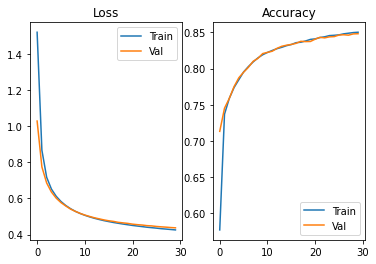

Train:   2%|▏         | 24/1500 [00:00<00:11, 123.53batch/s, loss=2.24, acc=21]  

Epoch 1 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 125.74batch/s, loss=0.947, acc=74.9]

Val Acc 0.7053333333333334
Epoch 2 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 123.35batch/s, loss=0.885, acc=73.6]

Val Acc 0.7430833333333333
Epoch 3 of 30


Train:   1%|▏         | 22/1500 [00:00<00:13, 109.17batch/s, loss=0.613, acc=78.3]

Val Acc 0.76225
Epoch 4 of 30


Train:   1%|          | 16/1500 [00:00<00:30, 49.32batch/s, loss=0.674, acc=79.2]

Val Acc 0.7788333333333334
Epoch 5 of 30


Train:   1%|          | 17/1500 [00:00<00:21, 69.21batch/s, loss=0.749, acc=78.1]

Val Acc 0.7910833333333334
Epoch 6 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 128.64batch/s, loss=0.557, acc=80]  

Val Acc 0.8004166666666667
Epoch 7 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 133.41batch/s, loss=0.457, acc=82.6]

Val Acc 0.8063333333333333
Epoch 8 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 119.39batch/s, loss=0.37, acc=82.9] 

Val Acc 0.811
Epoch 9 of 30


Train:   1%|          | 18/1500 [00:00<00:21, 67.72batch/s, loss=0.38, acc=82.9] 

Val Acc 0.8183333333333334
Epoch 10 of 30


Train:   1%|▏         | 22/1500 [00:00<00:13, 108.33batch/s, loss=0.684, acc=81.4]

Val Acc 0.8195
Epoch 11 of 30


Train:   1%|          | 17/1500 [00:00<00:22, 65.84batch/s, loss=0.481, acc=83.5]

Val Acc 0.82325
Epoch 12 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 131.05batch/s, loss=0.654, acc=83]  

Val Acc 0.8269166666666666
Epoch 13 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 130.81batch/s, loss=0.836, acc=82.6]

Val Acc 0.8283333333333334
Epoch 14 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 126.99batch/s, loss=0.473, acc=85.4]

Val Acc 0.8310833333333333
Epoch 15 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 125.60batch/s, loss=0.222, acc=84.9]

Val Acc 0.8335
Epoch 16 of 30


Train:   2%|▏         | 24/1500 [00:00<00:12, 120.87batch/s, loss=0.46, acc=85.4] 

Val Acc 0.8360833333333333
Epoch 17 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 129.03batch/s, loss=0.692, acc=83]  

Val Acc 0.8363333333333334
Epoch 18 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 129.87batch/s, loss=0.404, acc=86.7]

Val Acc 0.8384166666666667
Epoch 19 of 30


Train:   2%|▏         | 23/1500 [00:00<00:13, 113.60batch/s, loss=0.435, acc=83.7]

Val Acc 0.8376666666666667
Epoch 20 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 129.15batch/s, loss=0.356, acc=85]  

Val Acc 0.8395833333333333
Epoch 21 of 30


Train:   1%|          | 17/1500 [00:00<00:26, 56.33batch/s, loss=0.693, acc=83]  

Val Acc 0.8415833333333333
Epoch 22 of 30


Train:   1%|▏         | 22/1500 [00:00<00:11, 124.94batch/s, loss=0.466, acc=83.4]

Val Acc 0.8420833333333333
Epoch 23 of 30


Train:   1%|▏         | 20/1500 [00:00<00:14, 102.36batch/s, loss=0.568, acc=83]  

Val Acc 0.84175
Epoch 24 of 30


Train:   2%|▏         | 24/1500 [00:00<00:12, 121.41batch/s, loss=0.438, acc=86]  

Val Acc 0.844
Epoch 25 of 30


Train:   1%|▏         | 20/1500 [00:00<00:14, 101.16batch/s, loss=0.279, acc=84.2]

Val Acc 0.84475
Epoch 26 of 30


Train:   2%|▏         | 23/1500 [00:00<00:13, 109.27batch/s, loss=0.38, acc=85.4] 

Val Acc 0.8455833333333334
Epoch 27 of 30


Train:   1%|          | 18/1500 [00:00<00:22, 66.40batch/s, loss=0.432, acc=83.7]

Val Acc 0.8474166666666667
Epoch 28 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 128.51batch/s, loss=0.449, acc=85.5]

Val Acc 0.8459166666666667
Epoch 29 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 118.16batch/s, loss=0.57, acc=85.8] 

Val Acc 0.8479166666666667
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:03<00:00, 107.74batch/s, loss=0.29, acc=84.9] 


Val Acc 0.8486666666666667


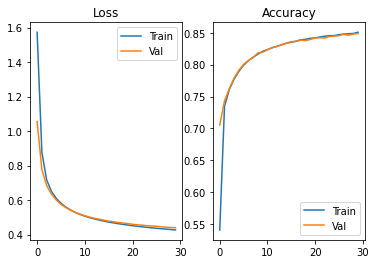

Train:   1%|▏         | 20/1500 [00:00<00:15, 96.43batch/s, loss=2.33, acc=6.99]

Epoch 1 of 30


Train:   1%|          | 13/1500 [00:00<00:39, 37.37batch/s, loss=1.03, acc=72.1] 

Val Acc 0.7169166666666666
Epoch 2 of 30


Train:   1%|▏         | 22/1500 [00:00<00:13, 111.47batch/s, loss=0.675, acc=74.9]

Val Acc 0.74225
Epoch 3 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 128.99batch/s, loss=0.492, acc=77.8]

Val Acc 0.7605
Epoch 4 of 30


Train:   1%|          | 18/1500 [00:00<00:19, 74.89batch/s, loss=0.366, acc=80.3]

Val Acc 0.7759166666666667
Epoch 5 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 125.29batch/s, loss=0.506, acc=77.9]

Val Acc 0.7860833333333334
Epoch 6 of 30


Train:   1%|          | 17/1500 [00:00<00:25, 58.99batch/s, loss=0.673, acc=78.8]

Val Acc 0.7921666666666667
Epoch 7 of 30


Train:   1%|          | 18/1500 [00:00<00:11, 133.19batch/s, loss=0.618, acc=84.7]

Val Acc 0.8004166666666667
Epoch 8 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 129.24batch/s, loss=0.542, acc=82.3]

Val Acc 0.8060833333333334
Epoch 9 of 30


Train:   1%|▏         | 22/1500 [00:00<00:12, 115.67batch/s, loss=0.667, acc=81]  

Val Acc 0.8115833333333333
Epoch 10 of 30


Train:   2%|▏         | 24/1500 [00:00<00:12, 122.15batch/s, loss=0.378, acc=80.2]

Val Acc 0.8151666666666667
Epoch 11 of 30


Train:   1%|▏         | 19/1500 [00:00<00:12, 118.10batch/s, loss=0.525, acc=81.2]

Val Acc 0.8191666666666667
Epoch 12 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 130.82batch/s, loss=0.44, acc=81.5] 

Val Acc 0.819
Epoch 13 of 30


Train:   1%|          | 18/1500 [00:00<00:22, 65.81batch/s, loss=0.665, acc=81.6]

Val Acc 0.82275
Epoch 14 of 30


Train:   1%|          | 18/1500 [00:00<00:11, 125.93batch/s, loss=0.356, acc=83.4]

Val Acc 0.8265
Epoch 15 of 30


Train:   1%|          | 16/1500 [00:00<00:17, 82.81batch/s, loss=0.493, acc=79]  

Val Acc 0.8281666666666667
Epoch 16 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 131.22batch/s, loss=0.333, acc=84.4]

Val Acc 0.83075
Epoch 17 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 130.67batch/s, loss=0.474, acc=85]  

Val Acc 0.8305
Epoch 18 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 124.46batch/s, loss=0.601, acc=81.2]

Val Acc 0.8335
Epoch 19 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 133.89batch/s, loss=0.342, acc=83.9]

Val Acc 0.8343333333333334
Epoch 20 of 30


Train:   1%|▏         | 19/1500 [00:00<00:19, 74.67batch/s, loss=0.497, acc=81.7]

Val Acc 0.8335
Epoch 21 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 116.86batch/s, loss=0.337, acc=83.5]

Val Acc 0.8369166666666666
Epoch 22 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 131.59batch/s, loss=0.273, acc=82.5]

Val Acc 0.8373333333333334
Epoch 23 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 131.58batch/s, loss=0.407, acc=83.1]

Val Acc 0.8375
Epoch 24 of 30


Train:   1%|          | 18/1500 [00:00<00:15, 98.56batch/s, loss=0.393, acc=84.4]

Val Acc 0.8385833333333333
Epoch 25 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 128.81batch/s, loss=0.504, acc=83.8]

Val Acc 0.8381666666666666
Epoch 26 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 131.51batch/s, loss=0.551, acc=83.8]

Val Acc 0.83975
Epoch 27 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 131.66batch/s, loss=0.581, acc=84.6]

Val Acc 0.8401666666666666
Epoch 28 of 30


Train:   1%|▏         | 21/1500 [00:00<00:11, 126.05batch/s, loss=0.565, acc=82.8]

Val Acc 0.8415833333333333
Epoch 29 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 125.41batch/s, loss=0.47, acc=84.6] 

Val Acc 0.84175
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:02<00:00, 130.30batch/s, loss=0.323, acc=84.3]


Val Acc 0.8433333333333334


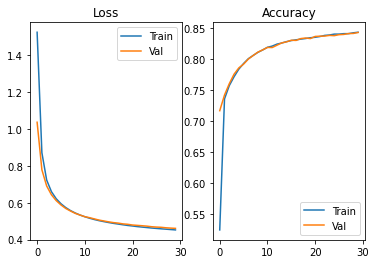

Train:   2%|▏         | 24/1500 [00:00<00:12, 122.93batch/s, loss=1.91, acc=30]  

Epoch 1 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 126.07batch/s, loss=0.641, acc=80.6]

Val Acc 0.8138333333333333
Epoch 2 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 132.58batch/s, loss=0.182, acc=83.5]

Val Acc 0.82575
Epoch 3 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 133.09batch/s, loss=0.477, acc=84.5]

Val Acc 0.84
Epoch 4 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 128.66batch/s, loss=0.353, acc=83.6]

Val Acc 0.8456666666666667
Epoch 5 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 128.32batch/s, loss=0.367, acc=86.1]

Val Acc 0.8570833333333333
Epoch 6 of 30


Train:   1%|          | 18/1500 [00:00<00:11, 128.26batch/s, loss=0.264, acc=87.3]

Val Acc 0.8586666666666667
Epoch 7 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 129.55batch/s, loss=0.456, acc=86.9]

Val Acc 0.85625
Epoch 8 of 30


Train:   2%|▏         | 23/1500 [00:00<00:11, 125.36batch/s, loss=0.268, acc=86.7]

Val Acc 0.86025
Epoch 9 of 30


Train:   1%|▏         | 20/1500 [00:00<00:11, 133.50batch/s, loss=0.277, acc=86.8]

Val Acc 0.8625
Epoch 10 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 130.57batch/s, loss=0.367, acc=86.9]

Val Acc 0.8570833333333333
Epoch 11 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 112.76batch/s, loss=0.402, acc=87.5]

Val Acc 0.8645833333333334
Epoch 12 of 30


Train:   2%|▏         | 23/1500 [00:00<00:13, 112.67batch/s, loss=0.259, acc=89.3]

Val Acc 0.8669166666666667
Epoch 13 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 131.27batch/s, loss=0.206, acc=89.1]

Val Acc 0.8625833333333334
Epoch 14 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 116.63batch/s, loss=0.223, acc=89.6]

Val Acc 0.8716666666666667
Epoch 15 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 114.02batch/s, loss=0.501, acc=90.1] 

Val Acc 0.8684166666666666
Epoch 16 of 30


Train:   2%|▏         | 24/1500 [00:00<00:12, 118.10batch/s, loss=0.354, acc=89.5] 

Val Acc 0.87125
Epoch 17 of 30


Train:   2%|▏         | 23/1500 [00:00<00:11, 132.92batch/s, loss=0.183, acc=88.3] 

Val Acc 0.8690833333333333
Epoch 18 of 30


Train:   1%|          | 16/1500 [00:00<00:22, 66.51batch/s, loss=0.299, acc=89]  

Val Acc 0.87575
Epoch 19 of 30


Train:   1%|▏         | 20/1500 [00:00<00:13, 113.48batch/s, loss=0.21, acc=87.8] 

Val Acc 0.8763333333333333
Epoch 20 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 126.06batch/s, loss=0.136, acc=89.9]

Val Acc 0.8735833333333334
Epoch 21 of 30


Train:   1%|▏         | 22/1500 [00:00<00:14, 104.32batch/s, loss=0.264, acc=89.7]

Val Acc 0.8744166666666666
Epoch 22 of 30


Train:   2%|▏         | 23/1500 [00:00<00:11, 131.27batch/s, loss=0.246, acc=88.8]

Val Acc 0.8751666666666666
Epoch 23 of 30


Train:   1%|▏         | 22/1500 [00:00<00:12, 115.95batch/s, loss=0.47, acc=90.4] 

Val Acc 0.8746666666666667
Epoch 24 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 119.51batch/s, loss=0.218, acc=89.6] 

Val Acc 0.8761666666666666
Epoch 25 of 30


Train:   2%|▏         | 23/1500 [00:00<00:13, 111.57batch/s, loss=0.248, acc=89.5]

Val Acc 0.8768333333333334
Epoch 26 of 30


Train:   1%|          | 18/1500 [00:00<00:22, 65.07batch/s, loss=0.357, acc=89.3]

Val Acc 0.8814166666666666
Epoch 27 of 30


Train:   2%|▏         | 25/1500 [00:00<00:10, 135.56batch/s, loss=0.22, acc=91]   

Val Acc 0.8745833333333334
Epoch 28 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 108.77batch/s, loss=0.196, acc=89.5]

Val Acc 0.8741666666666666
Epoch 29 of 30


Train:   1%|          | 17/1500 [00:00<00:16, 87.26batch/s, loss=0.235, acc=89.6] 

Val Acc 0.8758333333333334
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:02<00:00, 126.38batch/s, loss=0.204, acc=87.9] 


Val Acc 0.8794166666666666


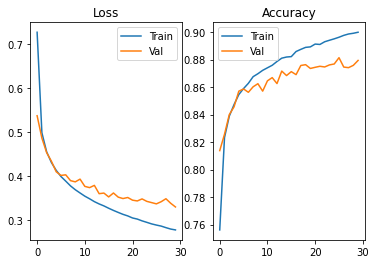

Train:   1%|          | 16/1500 [00:00<00:22, 65.87batch/s, loss=2.03, acc=22.4]

Epoch 1 of 30


Train:   2%|▏         | 23/1500 [00:00<00:11, 125.56batch/s, loss=0.329, acc=82.7]

Val Acc 0.8170833333333334
Epoch 2 of 30


Train:   1%|▏         | 22/1500 [00:00<00:14, 103.86batch/s, loss=0.613, acc=79.8]

Val Acc 0.8355
Epoch 3 of 30


Train:   1%|          | 18/1500 [00:00<00:22, 66.68batch/s, loss=0.358, acc=81.7]

Val Acc 0.8435
Epoch 4 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 130.30batch/s, loss=0.582, acc=84.4]

Val Acc 0.8460833333333333
Epoch 5 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 128.26batch/s, loss=0.386, acc=85.9]

Val Acc 0.8529166666666667
Epoch 6 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 125.88batch/s, loss=0.219, acc=86.1]

Val Acc 0.8544166666666667
Epoch 7 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 132.84batch/s, loss=0.614, acc=86.7]

Val Acc 0.8576666666666667
Epoch 8 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 139.87batch/s, loss=0.426, acc=85.9]

Val Acc 0.8600833333333333
Epoch 9 of 30


Train:   1%|          | 18/1500 [00:00<00:15, 97.79batch/s, loss=0.287, acc=87.7] 

Val Acc 0.8616666666666667
Epoch 10 of 30


Train:   2%|▏         | 24/1500 [00:00<00:13, 113.09batch/s, loss=0.721, acc=88.8]

Val Acc 0.86475
Epoch 11 of 30


Train:   1%|          | 18/1500 [00:00<00:15, 92.74batch/s, loss=0.277, acc=88.7] 

Val Acc 0.8665
Epoch 12 of 30


Train:   1%|▏         | 19/1500 [00:00<00:12, 123.32batch/s, loss=0.228, acc=88]  

Val Acc 0.8685
Epoch 13 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 124.42batch/s, loss=0.499, acc=87.6]

Val Acc 0.8653333333333333
Epoch 14 of 30


Train:   2%|▏         | 24/1500 [00:00<00:10, 135.64batch/s, loss=0.358, acc=87]  

Val Acc 0.8659166666666667
Epoch 15 of 30


Train:   1%|▏         | 21/1500 [00:00<00:11, 132.90batch/s, loss=0.267, acc=88.2]

Val Acc 0.8694166666666666
Epoch 16 of 30


Train:   2%|▏         | 25/1500 [00:00<00:10, 138.41batch/s, loss=0.3, acc=87.7]  

Val Acc 0.8688333333333333
Epoch 17 of 30


Train:   2%|▏         | 24/1500 [00:00<00:10, 134.30batch/s, loss=0.263, acc=86.9]

Val Acc 0.8694166666666666
Epoch 18 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 130.78batch/s, loss=0.165, acc=87.8]

Val Acc 0.87325
Epoch 19 of 30


Train:   2%|▏         | 25/1500 [00:00<00:10, 141.41batch/s, loss=0.221, acc=87.6] 

Val Acc 0.87075
Epoch 20 of 30


Train:   1%|          | 17/1500 [00:00<00:21, 68.09batch/s, loss=0.261, acc=88.7]

Val Acc 0.8675833333333334
Epoch 21 of 30


Train:   2%|▏         | 25/1500 [00:00<00:10, 138.13batch/s, loss=0.276, acc=89.4]

Val Acc 0.8725833333333334
Epoch 22 of 30


Train:   2%|▏         | 25/1500 [00:00<00:10, 135.51batch/s, loss=0.168, acc=87.9]

Val Acc 0.8739166666666667
Epoch 23 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 127.05batch/s, loss=0.272, acc=88.9]

Val Acc 0.8689166666666667
Epoch 24 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 120.51batch/s, loss=0.333, acc=88.2]

Val Acc 0.8746666666666667
Epoch 25 of 30


Train:   1%|          | 16/1500 [00:00<00:25, 58.84batch/s, loss=0.211, acc=89]  

Val Acc 0.8756666666666667
Epoch 26 of 30


Train:   1%|          | 18/1500 [00:00<00:18, 78.16batch/s, loss=0.219, acc=89.5]

Val Acc 0.87375
Epoch 27 of 30


Train:   2%|▏         | 27/1500 [00:00<00:10, 138.07batch/s, loss=0.395, acc=88.2]

Val Acc 0.8703333333333333
Epoch 28 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 136.53batch/s, loss=0.221, acc=88.7]

Val Acc 0.8723333333333333
Epoch 29 of 30


Train:   1%|▏         | 21/1500 [00:00<00:10, 135.10batch/s, loss=0.452, acc=89.1]

Val Acc 0.87
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:02<00:00, 134.17batch/s, loss=0.175, acc=87.5] 


Val Acc 0.8749166666666667


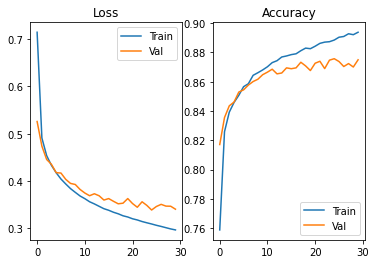

Train:   0%|          | 0/1500 [00:00<?, ?batch/s, loss=2.31, acc=12.5]

Epoch 1 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 140.87batch/s, loss=0.417, acc=79.5]

Val Acc 0.79625
Epoch 2 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 137.85batch/s, loss=0.621, acc=78.4]

Val Acc 0.8276666666666667
Epoch 3 of 30


Train:   2%|▏         | 26/1500 [00:00<00:11, 132.23batch/s, loss=0.623, acc=84]  

Val Acc 0.8370833333333333
Epoch 4 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 138.86batch/s, loss=0.449, acc=86]  

Val Acc 0.8385833333333333
Epoch 5 of 30


Train:   1%|          | 16/1500 [00:00<00:30, 48.40batch/s, loss=0.219, acc=86.8]

Val Acc 0.84275
Epoch 6 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 126.79batch/s, loss=0.706, acc=85.1]

Val Acc 0.8405
Epoch 7 of 30


Train:   1%|          | 17/1500 [00:00<00:15, 95.52batch/s, loss=0.263, acc=86.1] 

Val Acc 0.8491666666666666
Epoch 8 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 132.66batch/s, loss=0.377, acc=86.9]

Val Acc 0.8495
Epoch 9 of 30


Train:   1%|          | 18/1500 [00:00<00:22, 66.71batch/s, loss=0.432, acc=84.4]

Val Acc 0.8530833333333333
Epoch 10 of 30


Train:   2%|▏         | 26/1500 [00:00<00:11, 129.20batch/s, loss=0.393, acc=84.8]

Val Acc 0.8521666666666666
Epoch 11 of 30


Train:   1%|▏         | 22/1500 [00:00<00:12, 122.77batch/s, loss=0.242, acc=85.9]

Val Acc 0.8486666666666667
Epoch 12 of 30


Train:   0%|          | 0/1500 [00:00<?, ?batch/s, loss=0.161, acc=96.9]

Val Acc 0.8501666666666666
Epoch 13 of 30


Train:   2%|▏         | 24/1500 [00:00<00:12, 118.87batch/s, loss=0.325, acc=86.9]

Val Acc 0.855
Epoch 14 of 30


Train:   1%|          | 15/1500 [00:00<00:17, 86.45batch/s, loss=0.326, acc=84]  

Val Acc 0.85675
Epoch 15 of 30


Train:   1%|▏         | 22/1500 [00:00<00:12, 122.70batch/s, loss=0.389, acc=86.5]

Val Acc 0.85575
Epoch 16 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 132.87batch/s, loss=0.232, acc=85.3]

Val Acc 0.8550833333333333
Epoch 17 of 30


Train:   1%|▏         | 22/1500 [00:00<00:11, 124.00batch/s, loss=0.29, acc=85.7] 

Val Acc 0.8584166666666667
Epoch 18 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 126.88batch/s, loss=0.488, acc=86.1]

Val Acc 0.85925
Epoch 19 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 129.88batch/s, loss=0.347, acc=85.2]

Val Acc 0.8596666666666667
Epoch 20 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 124.23batch/s, loss=0.534, acc=85.2]

Val Acc 0.85925
Epoch 21 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 127.39batch/s, loss=0.306, acc=86.1]

Val Acc 0.8575833333333334
Epoch 22 of 30


Train:   2%|▏         | 24/1500 [00:00<00:10, 139.12batch/s, loss=0.379, acc=85.5]

Val Acc 0.8565
Epoch 23 of 30


Train:   2%|▏         | 24/1500 [00:00<00:12, 116.22batch/s, loss=0.467, acc=85.6]

Val Acc 0.85625
Epoch 24 of 30


Train:   1%|          | 18/1500 [00:00<00:25, 59.20batch/s, loss=0.393, acc=86.8]

Val Acc 0.8604166666666667
Epoch 25 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 134.56batch/s, loss=0.455, acc=85.4]

Val Acc 0.8545833333333334
Epoch 26 of 30


Train:   1%|          | 12/1500 [00:00<00:38, 38.26batch/s, loss=0.238, acc=85.6]

Val Acc 0.8575
Epoch 27 of 30


Train:   1%|          | 18/1500 [00:00<00:10, 134.90batch/s, loss=0.343, acc=84.2]

Val Acc 0.8565833333333334
Epoch 28 of 30


Train:   1%|          | 17/1500 [00:00<00:26, 56.11batch/s, loss=0.572, acc=85.8]

Val Acc 0.8600833333333333
Epoch 29 of 30


Train:   1%|          | 18/1500 [00:00<00:16, 89.74batch/s, loss=0.316, acc=86.7] 

Val Acc 0.858
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:02<00:00, 129.86batch/s, loss=0.27, acc=86.2] 


Val Acc 0.8615


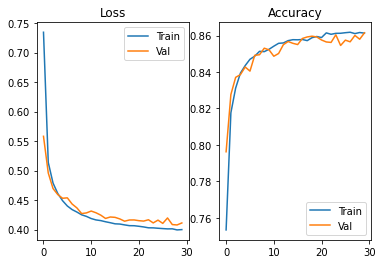

Train:   1%|          | 17/1500 [00:00<00:24, 59.88batch/s, loss=1.14, acc=41.3]

Epoch 1 of 30


Train:   2%|▏         | 27/1500 [00:00<00:10, 138.99batch/s, loss=0.352, acc=83.4]

Val Acc 0.8409166666666666
Epoch 2 of 30


Train:   2%|▏         | 27/1500 [00:00<00:10, 139.50batch/s, loss=0.16, acc=86.5] 

Val Acc 0.8570833333333333
Epoch 3 of 30


Train:   1%|          | 18/1500 [00:00<00:16, 92.07batch/s, loss=0.318, acc=85.9] 

Val Acc 0.8470833333333333
Epoch 4 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 138.80batch/s, loss=0.453, acc=86.5] 

Val Acc 0.8645833333333334
Epoch 5 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 139.16batch/s, loss=0.211, acc=88.4]

Val Acc 0.8689166666666667
Epoch 6 of 30


Train:   2%|▏         | 26/1500 [00:00<00:11, 133.73batch/s, loss=0.246, acc=86.1]

Val Acc 0.8700833333333333
Epoch 7 of 30


Train:   2%|▏         | 26/1500 [00:00<00:11, 132.32batch/s, loss=0.557, acc=86.3]

Val Acc 0.87
Epoch 8 of 30


Train:   1%|▏         | 20/1500 [00:00<00:11, 124.30batch/s, loss=0.245, acc=87.4]

Val Acc 0.8605
Epoch 9 of 30


Train:   2%|▏         | 25/1500 [00:00<00:10, 141.57batch/s, loss=0.434, acc=90.7]

Val Acc 0.8623333333333333
Epoch 10 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 118.54batch/s, loss=0.546, acc=89.1]

Val Acc 0.8645833333333334
Epoch 11 of 30


Train:   2%|▏         | 23/1500 [00:00<00:13, 108.30batch/s, loss=0.277, acc=90.9]

Val Acc 0.8685833333333334
Epoch 12 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 128.81batch/s, loss=0.285, acc=90.1]

Val Acc 0.8755
Epoch 13 of 30


Train:   2%|▏         | 26/1500 [00:00<00:11, 132.18batch/s, loss=0.358, acc=89.5] 

Val Acc 0.8708333333333333
Epoch 14 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 135.05batch/s, loss=0.377, acc=89.2]

Val Acc 0.8695
Epoch 15 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 137.85batch/s, loss=0.414, acc=89.2] 

Val Acc 0.8826666666666667
Epoch 16 of 30


Train:   1%|▏         | 21/1500 [00:00<00:10, 138.93batch/s, loss=0.236, acc=89.9]

Val Acc 0.8750833333333333
Epoch 17 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 127.89batch/s, loss=0.126, acc=89.9]

Val Acc 0.87425
Epoch 18 of 30


Train:   2%|▏         | 26/1500 [00:00<00:11, 128.88batch/s, loss=0.38, acc=90.6] 

Val Acc 0.87575
Epoch 19 of 30


Train:   1%|          | 17/1500 [00:00<00:21, 69.09batch/s, loss=0.231, acc=92]  

Val Acc 0.8835
Epoch 20 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 129.25batch/s, loss=0.0218, acc=92.1]

Val Acc 0.8708333333333333
Epoch 21 of 30


Train:   1%|          | 17/1500 [00:00<00:24, 59.34batch/s, loss=0.115, acc=92.9]

Val Acc 0.8739166666666667
Epoch 22 of 30


Train:   2%|▏         | 24/1500 [00:00<00:10, 137.21batch/s, loss=0.211, acc=92.6] 

Val Acc 0.87725
Epoch 23 of 30


Train:   2%|▏         | 24/1500 [00:00<00:10, 135.27batch/s, loss=0.14, acc=91.5]  

Val Acc 0.8740833333333333
Epoch 24 of 30


Train:   2%|▏         | 25/1500 [00:00<00:10, 136.95batch/s, loss=0.181, acc=92.3] 

Val Acc 0.8725
Epoch 25 of 30


Train:   1%|          | 18/1500 [00:00<00:25, 58.34batch/s, loss=0.108, acc=92.4] 

Val Acc 0.8824166666666666
Epoch 26 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 126.82batch/s, loss=0.389, acc=92.5] 

Val Acc 0.8795
Epoch 27 of 30


Train:   1%|          | 17/1500 [00:00<00:25, 58.95batch/s, loss=0.208, acc=91.7]

Val Acc 0.8680833333333333
Epoch 28 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 136.72batch/s, loss=0.234, acc=91.2] 

Val Acc 0.8846666666666667
Epoch 29 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 127.35batch/s, loss=0.184, acc=90.7] 

Val Acc 0.8843333333333333
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:02<00:00, 132.16batch/s, loss=0.148, acc=87.4] 


Val Acc 0.8736666666666667


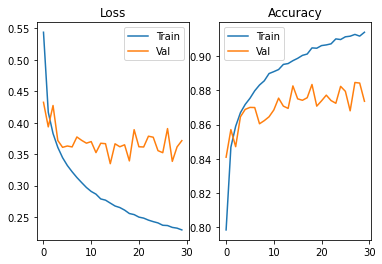

Train:   0%|          | 0/1500 [00:00<?, ?batch/s, loss=2.34, acc=15.6]

Epoch 1 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 134.33batch/s, loss=0.573, acc=83.9]

Val Acc 0.8356666666666667
Epoch 2 of 30


Train:   1%|▏         | 19/1500 [00:00<00:21, 67.88batch/s, loss=0.474, acc=88.1]

Val Acc 0.8566666666666667
Epoch 3 of 30


Train:   2%|▏         | 26/1500 [00:00<00:11, 132.81batch/s, loss=0.646, acc=84.7]

Val Acc 0.856
Epoch 4 of 30


Train:   2%|▏         | 27/1500 [00:00<00:10, 139.73batch/s, loss=0.252, acc=87.2]

Val Acc 0.85725
Epoch 5 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 135.25batch/s, loss=0.539, acc=87]  

Val Acc 0.86625
Epoch 6 of 30


Train:   1%|          | 18/1500 [00:00<00:24, 59.96batch/s, loss=0.173, acc=92.3]

Val Acc 0.8733333333333333
Epoch 7 of 30


Train:   1%|          | 17/1500 [00:00<00:22, 65.29batch/s, loss=0.201, acc=88.9]

Val Acc 0.8713333333333333
Epoch 8 of 30


Train:   1%|▏         | 22/1500 [00:00<00:11, 133.70batch/s, loss=0.361, acc=86.4]

Val Acc 0.82575
Epoch 9 of 30


Train:   2%|▏         | 26/1500 [00:00<00:11, 132.94batch/s, loss=0.295, acc=88.7]

Val Acc 0.8709166666666667
Epoch 10 of 30


Train:   0%|          | 6/1500 [00:00<00:41, 36.06batch/s, loss=0.384, acc=87.1]

Val Acc 0.8750833333333333
Epoch 11 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 130.82batch/s, loss=0.638, acc=89.1]

Val Acc 0.87425
Epoch 12 of 30


Train:   1%|          | 14/1500 [00:00<00:28, 52.34batch/s, loss=0.111, acc=88.3]

Val Acc 0.8643333333333333
Epoch 13 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 126.47batch/s, loss=0.284, acc=86.8]

Val Acc 0.8731666666666666
Epoch 14 of 30


Train:   1%|▏         | 21/1500 [00:00<00:11, 127.52batch/s, loss=0.0824, acc=91.9]

Val Acc 0.87375
Epoch 15 of 30


Train:   1%|          | 18/1500 [00:00<00:11, 126.37batch/s, loss=0.225, acc=89.1]

Val Acc 0.878
Epoch 16 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 128.37batch/s, loss=0.315, acc=89.1]

Val Acc 0.8746666666666667
Epoch 17 of 30


Train:   1%|▏         | 19/1500 [00:00<00:12, 114.27batch/s, loss=0.358, acc=86.9]

Val Acc 0.8658333333333333
Epoch 18 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 118.85batch/s, loss=0.19, acc=89.6] 

Val Acc 0.8600833333333333
Epoch 19 of 30


Train:   1%|          | 14/1500 [00:00<00:19, 75.25batch/s, loss=0.443, acc=89.4]

Val Acc 0.8549166666666667
Epoch 20 of 30


Train:   1%|          | 16/1500 [00:00<00:27, 54.45batch/s, loss=0.417, acc=88.2] 

Val Acc 0.8645833333333334
Epoch 21 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 132.05batch/s, loss=0.422, acc=89.1]

Val Acc 0.87325
Epoch 22 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 120.16batch/s, loss=0.194, acc=89.5]

Val Acc 0.8745833333333334
Epoch 23 of 30


Train:   1%|▏         | 21/1500 [00:00<00:15, 98.02batch/s, loss=0.256, acc=87.9]

Val Acc 0.8815833333333334
Epoch 24 of 30


Train:   1%|          | 14/1500 [00:00<00:19, 74.67batch/s, loss=0.337, acc=85.4]

Val Acc 0.85775
Epoch 25 of 30


Train:   1%|▏         | 19/1500 [00:00<00:13, 112.15batch/s, loss=0.165, acc=88.9]

Val Acc 0.8731666666666666
Epoch 26 of 30


Train:   1%|          | 14/1500 [00:00<00:37, 39.79batch/s, loss=0.186, acc=87.3]

Val Acc 0.87075
Epoch 27 of 30


Train:   1%|▏         | 20/1500 [00:00<00:15, 97.51batch/s, loss=0.362, acc=89.4]

Val Acc 0.8735833333333334
Epoch 28 of 30


Train:   1%|          | 15/1500 [00:00<00:16, 88.79batch/s, loss=0.304, acc=88.3]

Val Acc 0.8729166666666667
Epoch 29 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 127.45batch/s, loss=0.401, acc=88.4] 

Val Acc 0.87625
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:02<00:00, 128.63batch/s, loss=0.192, acc=88.1] 


Val Acc 0.8813333333333333


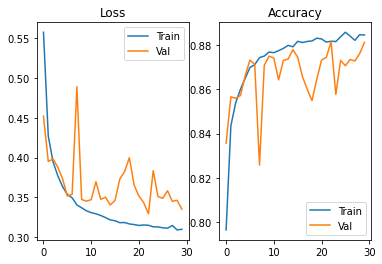

Train:   2%|▏         | 26/1500 [00:00<00:11, 132.38batch/s, loss=1.21, acc=44.2] 

Epoch 1 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 135.09batch/s, loss=0.577, acc=83.1]

Val Acc 0.8080833333333334
Epoch 2 of 30


Train:   1%|          | 18/1500 [00:00<00:16, 88.85batch/s, loss=0.523, acc=79.6]

Val Acc 0.8279166666666666
Epoch 3 of 30


Train:   2%|▏         | 28/1500 [00:00<00:10, 147.06batch/s, loss=0.453, acc=81.8]

Val Acc 0.8178333333333333
Epoch 4 of 30


Train:   2%|▏         | 28/1500 [00:00<00:09, 149.02batch/s, loss=0.517, acc=82.5]

Val Acc 0.8348333333333333
Epoch 5 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 120.05batch/s, loss=0.643, acc=84.1]

Val Acc 0.829
Epoch 6 of 30


Train:   1%|          | 18/1500 [00:00<00:18, 79.68batch/s, loss=0.389, acc=83.9]

Val Acc 0.8313333333333334
Epoch 7 of 30


Train:   2%|▏         | 27/1500 [00:00<00:10, 145.94batch/s, loss=0.492, acc=82.4]

Val Acc 0.8340833333333333
Epoch 8 of 30


Train:   2%|▏         | 28/1500 [00:00<00:09, 149.88batch/s, loss=0.332, acc=84.5]

Val Acc 0.8238333333333333
Epoch 9 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 142.00batch/s, loss=0.38, acc=84.5] 

Val Acc 0.8239166666666666
Epoch 10 of 30


Train:   1%|▏         | 19/1500 [00:00<00:20, 72.32batch/s, loss=0.437, acc=78.8]

Val Acc 0.78675
Epoch 11 of 30


Train:   2%|▏         | 29/1500 [00:00<00:09, 151.58batch/s, loss=0.514, acc=82.9]

Val Acc 0.828
Epoch 12 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 128.33batch/s, loss=0.615, acc=83.3]

Val Acc 0.8211666666666667
Epoch 13 of 30


Train:   1%|▏         | 21/1500 [00:00<00:14, 104.14batch/s, loss=0.545, acc=77.6]

Val Acc 0.7966666666666666
Epoch 14 of 30


Train:   2%|▏         | 28/1500 [00:00<00:10, 144.90batch/s, loss=0.676, acc=84.2]

Val Acc 0.8365833333333333
Epoch 15 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 127.39batch/s, loss=0.558, acc=83.2]

Val Acc 0.8186666666666667
Epoch 16 of 30


Train:   2%|▏         | 28/1500 [00:00<00:09, 149.58batch/s, loss=0.697, acc=83.5]

Val Acc 0.8160833333333334
Epoch 17 of 30


Train:   2%|▏         | 28/1500 [00:00<00:10, 143.87batch/s, loss=0.301, acc=82.3]

Val Acc 0.83275
Epoch 18 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 138.67batch/s, loss=0.787, acc=82.5]

Val Acc 0.8431666666666666
Epoch 19 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 139.81batch/s, loss=0.531, acc=81.7]

Val Acc 0.8088333333333333
Epoch 20 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 138.29batch/s, loss=0.282, acc=83.4]

Val Acc 0.8293333333333334
Epoch 21 of 30


Train:   1%|▏         | 19/1500 [00:00<00:10, 138.63batch/s, loss=0.493, acc=77.2]

Val Acc 0.8424166666666667
Epoch 22 of 30


Train:   2%|▏         | 25/1500 [00:00<00:10, 146.87batch/s, loss=0.497, acc=82.3]

Val Acc 0.8293333333333334
Epoch 23 of 30


Train:   1%|▏         | 22/1500 [00:00<00:14, 103.78batch/s, loss=0.261, acc=83.8]

Val Acc 0.8189166666666666
Epoch 24 of 30


Train:   2%|▏         | 28/1500 [00:00<00:09, 152.17batch/s, loss=0.344, acc=81.1]

Val Acc 0.7938333333333333
Epoch 25 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 130.89batch/s, loss=0.498, acc=83.7]

Val Acc 0.8385833333333333
Epoch 26 of 30


Train:   1%|▏         | 21/1500 [00:00<00:19, 76.91batch/s, loss=0.259, acc=83.5]

Val Acc 0.7815
Epoch 27 of 30


Train:   1%|▏         | 19/1500 [00:00<00:21, 69.57batch/s, loss=0.509, acc=82.2]

Val Acc 0.80175
Epoch 28 of 30


Train:   2%|▏         | 25/1500 [00:00<00:12, 117.74batch/s, loss=0.624, acc=82.5]

Val Acc 0.8248333333333333
Epoch 29 of 30


Train:   2%|▏         | 27/1500 [00:00<00:10, 139.90batch/s, loss=0.28, acc=83.6] 

Val Acc 0.80225
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:02<00:00, 145.41batch/s, loss=0.362, acc=82.2]


Val Acc 0.8225


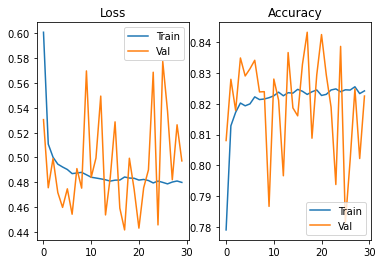

Train:   2%|▏         | 26/1500 [00:00<00:11, 133.77batch/s, loss=2.24, acc=7.29]

Epoch 1 of 30


Train:   2%|▏         | 28/1500 [00:00<00:10, 146.80batch/s, loss=1.11, acc=73.1] 

Val Acc 0.7209166666666667
Epoch 2 of 30


Train:   2%|▏         | 28/1500 [00:00<00:09, 149.08batch/s, loss=0.711, acc=73.8]

Val Acc 0.7489166666666667
Epoch 3 of 30


Train:   2%|▏         | 27/1500 [00:00<00:10, 142.18batch/s, loss=0.859, acc=78.2]

Val Acc 0.7685
Epoch 4 of 30


Train:   2%|▏         | 28/1500 [00:00<00:10, 144.49batch/s, loss=0.557, acc=79.6]

Val Acc 0.7823333333333333
Epoch 5 of 30


Train:   1%|          | 17/1500 [00:00<00:11, 129.48batch/s, loss=0.819, acc=76]  

Val Acc 0.7906666666666666
Epoch 6 of 30


Train:   1%|▏         | 19/1500 [00:00<00:15, 94.45batch/s, loss=0.386, acc=78.3] 

Val Acc 0.799
Epoch 7 of 30


Train:   1%|          | 18/1500 [00:00<00:16, 88.80batch/s, loss=0.457, acc=81.4]

Val Acc 0.8081666666666667
Epoch 8 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 132.93batch/s, loss=0.576, acc=80.2]

Val Acc 0.8115833333333333
Epoch 9 of 30


Train:   1%|▏         | 20/1500 [00:00<00:12, 113.98batch/s, loss=0.495, acc=83.8]

Val Acc 0.8175
Epoch 10 of 30


Train:   1%|▏         | 22/1500 [00:00<00:12, 118.67batch/s, loss=0.594, acc=82.1]

Val Acc 0.8214166666666667
Epoch 11 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 137.07batch/s, loss=0.638, acc=83.4]

Val Acc 0.8253333333333334
Epoch 12 of 30


Train:   1%|          | 18/1500 [00:00<00:26, 56.08batch/s, loss=0.547, acc=80.3]

Val Acc 0.82625
Epoch 13 of 30


Train:   2%|▏         | 23/1500 [00:00<00:11, 124.49batch/s, loss=0.363, acc=84.2]

Val Acc 0.8293333333333334
Epoch 14 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 133.54batch/s, loss=0.336, acc=83.1]

Val Acc 0.8318333333333333
Epoch 15 of 30


Train:   1%|▏         | 19/1500 [00:00<00:10, 145.21batch/s, loss=0.769, acc=83]  

Val Acc 0.8343333333333334
Epoch 16 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 118.17batch/s, loss=0.272, acc=84.9]

Val Acc 0.836
Epoch 17 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 123.40batch/s, loss=0.449, acc=84.6]

Val Acc 0.838
Epoch 18 of 30


Train:   2%|▏         | 27/1500 [00:00<00:10, 144.69batch/s, loss=0.361, acc=85.5]

Val Acc 0.83825
Epoch 19 of 30


Train:   1%|          | 18/1500 [00:00<00:10, 135.43batch/s, loss=0.431, acc=85.5]

Val Acc 0.8393333333333334
Epoch 20 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 127.29batch/s, loss=0.358, acc=84.2]

Val Acc 0.842
Epoch 21 of 30


Train:   1%|          | 17/1500 [00:00<00:18, 82.05batch/s, loss=0.656, acc=81.6]

Val Acc 0.842
Epoch 22 of 30


Train:   1%|▏         | 19/1500 [00:00<00:22, 66.21batch/s, loss=0.41, acc=85]   

Val Acc 0.8439166666666666
Epoch 23 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 146.36batch/s, loss=0.291, acc=82.8]

Val Acc 0.8449166666666666
Epoch 24 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 124.51batch/s, loss=0.518, acc=84.4]

Val Acc 0.8459166666666667
Epoch 25 of 30


Train:   1%|          | 18/1500 [00:00<00:14, 99.95batch/s, loss=0.392, acc=84.2]

Val Acc 0.8463333333333334
Epoch 26 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 123.84batch/s, loss=0.453, acc=85.9]

Val Acc 0.8458333333333333
Epoch 27 of 30


Train:   2%|▏         | 28/1500 [00:00<00:09, 147.27batch/s, loss=0.274, acc=87.2]

Val Acc 0.8471666666666666
Epoch 28 of 30


Train:   2%|▏         | 26/1500 [00:00<00:11, 133.30batch/s, loss=0.431, acc=85.8]

Val Acc 0.8483333333333334
Epoch 29 of 30


Train:   2%|▏         | 28/1500 [00:00<00:10, 145.05batch/s, loss=0.528, acc=85]  

Val Acc 0.8481666666666666
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:02<00:00, 132.33batch/s, loss=0.249, acc=85]  


Val Acc 0.8496666666666667


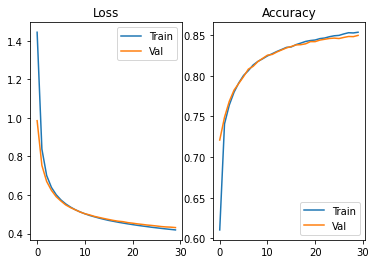

Train:   2%|▏         | 27/1500 [00:00<00:10, 139.84batch/s, loss=2.21, acc=12.7]

Epoch 1 of 30


Train:   2%|▏         | 29/1500 [00:00<00:10, 147.06batch/s, loss=1.08, acc=68.8] 

Val Acc 0.71125
Epoch 2 of 30


Train:   2%|▏         | 28/1500 [00:00<00:10, 145.01batch/s, loss=0.724, acc=74.7]

Val Acc 0.7416666666666667
Epoch 3 of 30


Train:   2%|▏         | 28/1500 [00:00<00:09, 150.52batch/s, loss=0.587, acc=73]  

Val Acc 0.7625833333333333
Epoch 4 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 131.19batch/s, loss=0.475, acc=79.4]

Val Acc 0.7744166666666666
Epoch 5 of 30


Train:   2%|▏         | 27/1500 [00:00<00:10, 143.55batch/s, loss=0.639, acc=78.8]

Val Acc 0.786
Epoch 6 of 30


Train:   1%|▏         | 20/1500 [00:00<00:09, 149.72batch/s, loss=0.811, acc=78]  

Val Acc 0.7959166666666667
Epoch 7 of 30


Train:   2%|▏         | 27/1500 [00:00<00:10, 144.54batch/s, loss=0.449, acc=81.5]

Val Acc 0.80325
Epoch 8 of 30


Train:   2%|▏         | 28/1500 [00:00<00:09, 147.72batch/s, loss=0.743, acc=81.5]

Val Acc 0.8096666666666666
Epoch 9 of 30


Train:   2%|▏         | 28/1500 [00:00<00:09, 147.90batch/s, loss=0.437, acc=82.9]

Val Acc 0.81475
Epoch 10 of 30


Train:   1%|▏         | 22/1500 [00:00<00:09, 153.58batch/s, loss=0.638, acc=82.9]

Val Acc 0.8199166666666666
Epoch 11 of 30


Train:   2%|▏         | 28/1500 [00:00<00:09, 148.90batch/s, loss=0.542, acc=82.5]

Val Acc 0.8223333333333334
Epoch 12 of 30


Train:   1%|▏         | 19/1500 [00:00<00:22, 65.23batch/s, loss=0.658, acc=79.8]

Val Acc 0.8244166666666667
Epoch 13 of 30


Train:   1%|▏         | 21/1500 [00:00<00:10, 147.09batch/s, loss=0.335, acc=84.2]

Val Acc 0.8278333333333333
Epoch 14 of 30


Train:   2%|▏         | 27/1500 [00:00<00:10, 145.86batch/s, loss=0.77, acc=83.9] 

Val Acc 0.8304166666666667
Epoch 15 of 30


Train:   2%|▏         | 28/1500 [00:00<00:10, 142.41batch/s, loss=0.594, acc=83]  

Val Acc 0.8325
Epoch 16 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 124.32batch/s, loss=0.323, acc=85.2]

Val Acc 0.8338333333333333
Epoch 17 of 30


Train:   1%|          | 18/1500 [00:00<00:22, 65.39batch/s, loss=0.507, acc=83.9]

Val Acc 0.8369166666666666
Epoch 18 of 30


Train:   1%|▏         | 20/1500 [00:00<00:21, 69.43batch/s, loss=0.434, acc=85]  

Val Acc 0.8393333333333334
Epoch 19 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 105.97batch/s, loss=0.371, acc=82.7]

Val Acc 0.8395
Epoch 20 of 30


Train:   2%|▏         | 26/1500 [00:00<00:11, 130.44batch/s, loss=0.363, acc=85.8]

Val Acc 0.8395
Epoch 21 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 132.75batch/s, loss=0.416, acc=83.7]

Val Acc 0.84225
Epoch 22 of 30


Train:   2%|▏         | 27/1500 [00:00<00:10, 141.65batch/s, loss=0.635, acc=86.3]

Val Acc 0.8444166666666667
Epoch 23 of 30


Train:   1%|          | 17/1500 [00:00<00:10, 138.06batch/s, loss=0.297, acc=84.9]

Val Acc 0.84425
Epoch 24 of 30


Train:   2%|▏         | 23/1500 [00:00<00:10, 144.31batch/s, loss=0.565, acc=85.2]

Val Acc 0.8454166666666667
Epoch 25 of 30


Train:   1%|          | 18/1500 [00:00<00:15, 94.17batch/s, loss=0.285, acc=86.2] 

Val Acc 0.8478333333333333
Epoch 26 of 30


Train:   2%|▏         | 27/1500 [00:00<00:10, 141.10batch/s, loss=0.572, acc=84.4]

Val Acc 0.84825
Epoch 27 of 30


Train:   2%|▏         | 28/1500 [00:00<00:10, 145.46batch/s, loss=0.574, acc=84.4]

Val Acc 0.84875
Epoch 28 of 30


Train:   2%|▏         | 23/1500 [00:00<00:11, 123.97batch/s, loss=0.385, acc=83.5]

Val Acc 0.8490833333333333
Epoch 29 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 134.22batch/s, loss=0.313, acc=85.6]

Val Acc 0.851
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:02<00:00, 133.21batch/s, loss=0.266, acc=85.1]


Val Acc 0.8513333333333334


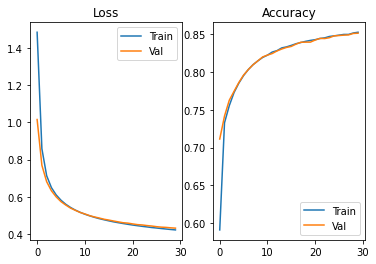

Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 1 of 30


Train:   2%|▏         | 28/1500 [00:00<00:10, 146.35batch/s, loss=0.938, acc=71.1]

Val Acc 0.706
Epoch 2 of 30


Train:   1%|▏         | 21/1500 [00:00<00:11, 134.37batch/s, loss=0.782, acc=76.1]

Val Acc 0.7410833333333333
Epoch 3 of 30


Train:   2%|▏         | 29/1500 [00:00<00:09, 150.69batch/s, loss=0.961, acc=75.1]

Val Acc 0.76125
Epoch 4 of 30


Train:   2%|▏         | 28/1500 [00:00<00:09, 147.64batch/s, loss=0.597, acc=79.1]

Val Acc 0.7734166666666666
Epoch 5 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 129.81batch/s, loss=0.757, acc=78.8]

Val Acc 0.7846666666666666
Epoch 6 of 30


Train:   2%|▏         | 27/1500 [00:00<00:10, 140.51batch/s, loss=0.749, acc=78.9]

Val Acc 0.79275
Epoch 7 of 30


Train:   2%|▏         | 28/1500 [00:00<00:10, 146.55batch/s, loss=0.548, acc=80.6]

Val Acc 0.8009166666666667
Epoch 8 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 125.91batch/s, loss=0.481, acc=80.8]

Val Acc 0.80625
Epoch 9 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 128.45batch/s, loss=0.425, acc=82]  

Val Acc 0.8115
Epoch 10 of 30


Train:   1%|▏         | 22/1500 [00:00<00:10, 140.63batch/s, loss=0.566, acc=82.3]

Val Acc 0.8163333333333334
Epoch 11 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 126.08batch/s, loss=0.529, acc=81.5]

Val Acc 0.8189166666666666
Epoch 12 of 30


Train:   1%|▏         | 22/1500 [00:00<00:10, 143.57batch/s, loss=0.571, acc=82.2]

Val Acc 0.8228333333333333
Epoch 13 of 30


Train:   2%|▏         | 23/1500 [00:00<00:11, 123.62batch/s, loss=0.408, acc=81.9]

Val Acc 0.8244166666666667
Epoch 14 of 30


Train:   2%|▏         | 28/1500 [00:00<00:10, 146.88batch/s, loss=0.55, acc=82.3] 

Val Acc 0.8273333333333334
Epoch 15 of 30


Train:   2%|▏         | 28/1500 [00:00<00:10, 145.82batch/s, loss=0.626, acc=81.4]

Val Acc 0.82875
Epoch 16 of 30


Train:   2%|▏         | 28/1500 [00:00<00:09, 151.08batch/s, loss=0.513, acc=80.3]

Val Acc 0.8291666666666667
Epoch 17 of 30


Train:   2%|▏         | 27/1500 [00:00<00:10, 138.46batch/s, loss=0.291, acc=82]  

Val Acc 0.8325
Epoch 18 of 30


Train:   1%|          | 18/1500 [00:00<00:11, 126.91batch/s, loss=0.248, acc=84.2]

Val Acc 0.8308333333333333
Epoch 19 of 30


Train:   1%|          | 18/1500 [00:00<00:24, 59.54batch/s, loss=0.446, acc=83.7]

Val Acc 0.8330833333333333
Epoch 20 of 30


Train:   2%|▏         | 24/1500 [00:00<00:10, 147.29batch/s, loss=0.465, acc=83.1]

Val Acc 0.8349166666666666
Epoch 21 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 124.82batch/s, loss=0.434, acc=83.9]

Val Acc 0.837
Epoch 22 of 30


Train:   1%|▏         | 21/1500 [00:00<00:09, 148.79batch/s, loss=0.402, acc=82.7]

Val Acc 0.8375833333333333
Epoch 23 of 30


Train:   1%|          | 17/1500 [00:00<00:16, 90.54batch/s, loss=0.356, acc=76.9] 

Val Acc 0.838
Epoch 24 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 141.28batch/s, loss=0.453, acc=82.8]

Val Acc 0.8401666666666666
Epoch 25 of 30


Train:   1%|▏         | 21/1500 [00:00<00:21, 69.90batch/s, loss=0.396, acc=82.8]

Val Acc 0.8418333333333333
Epoch 26 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 138.14batch/s, loss=0.329, acc=81.2]

Val Acc 0.8423333333333334
Epoch 27 of 30


Train:   1%|▏         | 19/1500 [00:00<00:10, 145.57batch/s, loss=0.273, acc=86.4]

Val Acc 0.8419166666666666
Epoch 28 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 135.95batch/s, loss=0.295, acc=86.3]

Val Acc 0.8426666666666667
Epoch 29 of 30


Train:   1%|▏         | 21/1500 [00:00<00:14, 99.14batch/s, loss=0.275, acc=84.8]

Val Acc 0.842
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:02<00:00, 135.46batch/s, loss=0.317, acc=84.4]


Val Acc 0.8439166666666666


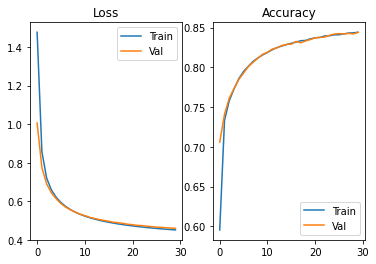

Train:   0%|          | 0/1500 [00:00<?, ?batch/s]

Epoch 1 of 30


Train:   2%|▏         | 28/1500 [00:00<00:09, 147.78batch/s, loss=0.429, acc=82.2]

Val Acc 0.8105
Epoch 2 of 30


Train:   1%|          | 17/1500 [00:00<00:11, 128.29batch/s, loss=0.463, acc=83.7]

Val Acc 0.8350833333333333
Epoch 3 of 30


Train:   1%|          | 18/1500 [00:00<00:19, 75.13batch/s, loss=0.309, acc=86.5]

Val Acc 0.8456666666666667
Epoch 4 of 30


Train:   2%|▏         | 25/1500 [00:00<00:10, 134.74batch/s, loss=0.346, acc=84.9]

Val Acc 0.85225
Epoch 5 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 129.96batch/s, loss=0.325, acc=86.3]

Val Acc 0.8555833333333334
Epoch 6 of 30


Train:   2%|▏         | 28/1500 [00:00<00:10, 146.10batch/s, loss=0.574, acc=87.3]

Val Acc 0.8624166666666667
Epoch 7 of 30


Train:   1%|          | 18/1500 [00:00<00:10, 139.07batch/s, loss=0.287, acc=89.3]

Val Acc 0.8645
Epoch 8 of 30


Train:   1%|▏         | 20/1500 [00:00<00:14, 100.55batch/s, loss=0.38, acc=89]   

Val Acc 0.8640833333333333
Epoch 9 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 136.18batch/s, loss=0.218, acc=88.2]

Val Acc 0.87
Epoch 10 of 30


Train:   1%|          | 14/1500 [00:00<00:11, 124.45batch/s, loss=0.392, acc=85]  

Val Acc 0.86775
Epoch 11 of 30


Train:   1%|          | 10/1500 [00:00<00:23, 64.05batch/s, loss=0.387, acc=87.5]

Val Acc 0.8741666666666666
Epoch 12 of 30


Train:   2%|▏         | 25/1500 [00:00<00:10, 143.05batch/s, loss=0.212, acc=91]  

Val Acc 0.874
Epoch 13 of 30


Train:   2%|▏         | 29/1500 [00:00<00:09, 153.20batch/s, loss=0.279, acc=89.8] 

Val Acc 0.8751666666666666
Epoch 14 of 30


Train:   2%|▏         | 27/1500 [00:00<00:10, 139.59batch/s, loss=0.133, acc=86.3]

Val Acc 0.8794166666666666
Epoch 15 of 30


Train:   1%|          | 15/1500 [00:00<00:27, 54.19batch/s, loss=0.354, acc=87.9]

Val Acc 0.873
Epoch 16 of 30


Train:   1%|          | 14/1500 [00:00<00:17, 82.58batch/s, loss=0.309, acc=89.4]

Val Acc 0.8784166666666666
Epoch 17 of 30


Train:   1%|          | 10/1500 [00:00<00:44, 33.11batch/s, loss=0.179, acc=91.2]

Val Acc 0.8805
Epoch 18 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 129.63batch/s, loss=0.373, acc=89.8]

Val Acc 0.8806666666666667
Epoch 19 of 30


Train:   1%|▏         | 21/1500 [00:00<00:14, 100.22batch/s, loss=0.276, acc=87.8]

Val Acc 0.8800833333333333
Epoch 20 of 30


Train:   1%|          | 18/1500 [00:00<00:25, 57.07batch/s, loss=0.396, acc=88]  

Val Acc 0.8841666666666667
Epoch 21 of 30


Train:   2%|▏         | 25/1500 [00:00<00:12, 121.39batch/s, loss=0.299, acc=89.3] 

Val Acc 0.8815833333333334
Epoch 22 of 30


Train:  70%|██████▉   | 1045/1500 [00:09<00:03, 115.64batch/s, loss=0.325, acc=89.9] 


KeyboardInterrupt: 

In [21]:
## this function is from Prof. Chugg's fmnist_mlp_torch.ipynb
## https://github.com/keithchugg/ee559_spring2023/blob/main/lecture/fmnist_mlp_torch.ipynb
# Run training and validation loop
# Save the best model based on validation accuracy
batchsize = 32
# Shuffle the data at the start of each epoch (only useful for training set)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)

acc_dict = dict()

for m in [40,80,160]:
  for l in [0.001,0.01, 0.1]:
    for wd in [1e-4,1e-3,1e-2]:
      model = MLP(m)
      model.to(device)
      criterion = nn.CrossEntropyLoss() # includes softmax (for numerical stability)
      optimizer = optim.SGD(model.parameters(), lr=l, weight_decay=wd)
      n_epochs = 30
      best_acc = -1
      train_loss_history = []; train_acc_history = []
      val_loss_history = []; val_acc_history = []
      for epoch in range(n_epochs): # Iterate over epochs
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
        valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
        testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)
        print(f"Epoch {epoch+1} of {n_epochs}")
        train_loss, train_acc  = train(model, trainloader, criterion, optimizer,device) # Train
        val_loss, val_acc = validate(model, valloader, criterion,device) # Validate
        train_loss_history.append(train_loss); train_acc_history.append(train_acc)
        val_loss_history.append(val_loss); val_acc_history.append(val_acc)
        print(f"Val Acc {val_acc}")
      acc_dict[f"{m}_{l}_{wd}"] = val_acc_history[-1]
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
      ax1.plot(range(30), train_loss_history, label='Train')
      ax1.plot(range(30), val_loss_history, label='Val')
      ax2.plot(range(30),train_acc_history , label='Train')
      ax2.plot(range(30),val_acc_history , label='Val')
      ax1.set_title('Loss')
      ax2.set_title('Accuracy')
      ax1.legend()
      ax2.legend()
      plt.show()
        

In [22]:
acc_dict

{'40_0.001_0.0001': 0.84825,
 '40_0.001_0.001': 0.8486666666666667,
 '40_0.001_0.01': 0.8433333333333334,
 '40_0.01_0.0001': 0.8794166666666666,
 '40_0.01_0.001': 0.8749166666666667,
 '40_0.01_0.01': 0.8615,
 '40_0.1_0.0001': 0.8736666666666667,
 '40_0.1_0.001': 0.8813333333333333,
 '40_0.1_0.01': 0.8225,
 '80_0.001_0.0001': 0.8496666666666667,
 '80_0.001_0.001': 0.8513333333333334,
 '80_0.001_0.01': 0.8439166666666666}

In [25]:
acc_dict = {'40_0.001_0.0001': 0.84825,
 '40_0.001_0.001': 0.8486666666666667,
 '40_0.001_0.01': 0.8433333333333334,
 '40_0.01_0.0001': 0.8794166666666666,
 '40_0.01_0.001': 0.8749166666666667,
 '40_0.01_0.01': 0.8615,
 '40_0.1_0.0001': 0.8736666666666667,
 '40_0.1_0.001': 0.8813333333333333,
 '40_0.1_0.01': 0.8225,
 '80_0.001_0.0001': 0.8496666666666667,
 '80_0.001_0.001': 0.8513333333333334,
 '80_0.001_0.01': 0.8439166666666666}

In [26]:
acc_dict

{'40_0.001_0.0001': 0.84825,
 '40_0.001_0.001': 0.8486666666666667,
 '40_0.001_0.01': 0.8433333333333334,
 '40_0.01_0.0001': 0.8794166666666666,
 '40_0.01_0.001': 0.8749166666666667,
 '40_0.01_0.01': 0.8615,
 '40_0.1_0.0001': 0.8736666666666667,
 '40_0.1_0.001': 0.8813333333333333,
 '40_0.1_0.01': 0.8225,
 '80_0.001_0.0001': 0.8496666666666667,
 '80_0.001_0.001': 0.8513333333333334,
 '80_0.001_0.01': 0.8439166666666666}

Train:   1%|          | 12/1500 [00:00<00:32, 46.41batch/s, loss=2.11, acc=23.8]

Epoch 1 of 30


Train:   1%|▏         | 20/1500 [00:00<00:12, 119.54batch/s, loss=0.595, acc=82.7]

Val Acc 0.8145833333333333
Epoch 2 of 30


Train:   1%|▏         | 21/1500 [00:00<00:12, 113.93batch/s, loss=0.519, acc=85.2]

Val Acc 0.8383333333333334
Epoch 3 of 30


Train:   2%|▏         | 25/1500 [00:00<00:10, 138.36batch/s, loss=0.271, acc=85.6]

Val Acc 0.8455
Epoch 4 of 30


Train:   1%|          | 15/1500 [00:00<00:30, 49.38batch/s, loss=0.726, acc=84.6]

Val Acc 0.8521666666666666
Epoch 5 of 30


Train:   1%|▏         | 20/1500 [00:00<00:11, 127.20batch/s, loss=0.383, acc=85.4]

Val Acc 0.8578333333333333
Epoch 6 of 30


Train:   1%|          | 15/1500 [00:00<00:18, 81.61batch/s, loss=0.465, acc=87.9] 

Val Acc 0.8589166666666667
Epoch 7 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 127.07batch/s, loss=0.229, acc=88.8] 

Val Acc 0.8641666666666666
Epoch 8 of 30


Train:   1%|          | 17/1500 [00:00<00:15, 98.37batch/s, loss=0.433, acc=86.6]

Val Acc 0.8661666666666666
Epoch 9 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 128.14batch/s, loss=0.434, acc=88.4]

Val Acc 0.86525
Epoch 10 of 30


Train:   1%|▏         | 21/1500 [00:00<00:15, 98.38batch/s, loss=0.115, acc=88.8]

Val Acc 0.8756666666666667
Epoch 11 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 136.25batch/s, loss=0.253, acc=89.9]

Val Acc 0.8713333333333333
Epoch 12 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 106.34batch/s, loss=0.276, acc=88.9]

Val Acc 0.87725
Epoch 13 of 30


Train:   1%|          | 18/1500 [00:00<00:14, 99.44batch/s, loss=0.241, acc=90.1]

Val Acc 0.873
Epoch 14 of 30


Train:   1%|          | 13/1500 [00:00<00:29, 49.81batch/s, loss=0.183, acc=88.4]

Val Acc 0.8785833333333334
Epoch 15 of 30


Train:   1%|▏         | 22/1500 [00:00<00:12, 114.32batch/s, loss=0.212, acc=89.1]

Val Acc 0.8793333333333333
Epoch 16 of 30


Train:   1%|          | 12/1500 [00:00<00:38, 38.98batch/s, loss=0.27, acc=89.9] 

Val Acc 0.8805833333333334
Epoch 17 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 118.09batch/s, loss=0.262, acc=90.2]

Val Acc 0.88
Epoch 18 of 30


Train:   1%|▏         | 20/1500 [00:00<00:14, 101.94batch/s, loss=0.346, acc=91.1]

Val Acc 0.8760833333333333
Epoch 19 of 30


Train:   0%|          | 3/1500 [00:00<03:25,  7.27batch/s, loss=0.219, acc=89.8]

Val Acc 0.8810833333333333
Epoch 20 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 110.65batch/s, loss=0.148, acc=89.8] 

Val Acc 0.8811666666666667
Epoch 21 of 30


Train:   1%|          | 11/1500 [00:00<00:39, 38.09batch/s, loss=0.265, acc=90.1]

Val Acc 0.8814166666666666
Epoch 22 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 121.96batch/s, loss=0.255, acc=89.5] 

Val Acc 0.8759166666666667
Epoch 23 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 122.04batch/s, loss=0.526, acc=88.8]

Val Acc 0.885
Epoch 24 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 119.83batch/s, loss=0.361, acc=92.8] 

Val Acc 0.88075
Epoch 25 of 30


Train:   1%|          | 11/1500 [00:00<00:36, 40.88batch/s, loss=0.265, acc=92.2]

Val Acc 0.88425
Epoch 26 of 30


Train:   1%|▏         | 22/1500 [00:00<00:12, 119.02batch/s, loss=0.262, acc=89.5]

Val Acc 0.88175
Epoch 27 of 30


Train:   1%|▏         | 22/1500 [00:00<00:13, 111.20batch/s, loss=0.245, acc=90.1] 

Val Acc 0.8871666666666667
Epoch 28 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 107.54batch/s, loss=0.118, acc=91.9]

Val Acc 0.8806666666666667
Epoch 29 of 30


Train:   1%|          | 14/1500 [00:00<00:12, 115.58batch/s, loss=0.216, acc=92.1]

Val Acc 0.884
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:03<00:00, 109.09batch/s, loss=0.139, acc=88]   


Val Acc 0.8799166666666667


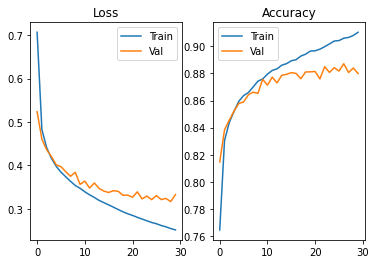

Train:   1%|          | 11/1500 [00:00<00:40, 36.34batch/s, loss=2.2, acc=13.5] 

Epoch 1 of 30


Train:   1%|▏         | 20/1500 [00:00<00:12, 114.47batch/s, loss=0.688, acc=80.1]

Val Acc 0.81625
Epoch 2 of 30


Train:   1%|▏         | 22/1500 [00:00<00:13, 112.56batch/s, loss=0.27, acc=82.7] 

Val Acc 0.8340833333333333
Epoch 3 of 30


Train:   1%|▏         | 22/1500 [00:00<00:11, 129.23batch/s, loss=0.443, acc=83]  

Val Acc 0.8373333333333334
Epoch 4 of 30


Train:   2%|▏         | 23/1500 [00:00<00:11, 126.42batch/s, loss=0.468, acc=86.2]

Val Acc 0.8535833333333334
Epoch 5 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 106.83batch/s, loss=0.347, acc=86.9]

Val Acc 0.8546666666666667
Epoch 6 of 30


Train:   1%|▏         | 20/1500 [00:00<00:13, 108.83batch/s, loss=0.409, acc=86.3]

Val Acc 0.8595
Epoch 7 of 30


Train:   1%|          | 14/1500 [00:00<00:13, 108.97batch/s, loss=0.167, acc=85]  

Val Acc 0.86175
Epoch 8 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 112.18batch/s, loss=0.256, acc=88.1]

Val Acc 0.8628333333333333
Epoch 9 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 127.17batch/s, loss=0.294, acc=86.6]

Val Acc 0.86575
Epoch 10 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 119.57batch/s, loss=0.618, acc=88.2]

Val Acc 0.8665
Epoch 11 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 111.56batch/s, loss=0.532, acc=90.5]

Val Acc 0.8728333333333333
Epoch 12 of 30


Train:   1%|▏         | 19/1500 [00:00<00:13, 112.40batch/s, loss=0.288, acc=86.7]

Val Acc 0.8716666666666667
Epoch 13 of 30


Train:   1%|          | 15/1500 [00:00<00:14, 102.08batch/s, loss=0.246, acc=88.3]

Val Acc 0.87225
Epoch 14 of 30


Train:   1%|▏         | 19/1500 [00:00<00:14, 103.40batch/s, loss=0.304, acc=89.2]

Val Acc 0.876
Epoch 15 of 30


Train:   1%|          | 13/1500 [00:00<00:40, 36.54batch/s, loss=0.169, acc=89.5]

Val Acc 0.87375
Epoch 16 of 30


Train:   1%|▏         | 22/1500 [00:00<00:12, 114.20batch/s, loss=0.313, acc=89.3]

Val Acc 0.87
Epoch 17 of 30


Train:   1%|▏         | 19/1500 [00:00<00:12, 114.17batch/s, loss=0.381, acc=87.8]

Val Acc 0.8776666666666667
Epoch 18 of 30


Train:   1%|          | 18/1500 [00:00<00:15, 94.56batch/s, loss=0.212, acc=90]   

Val Acc 0.8749166666666667
Epoch 19 of 30


Train:   1%|▏         | 21/1500 [00:00<00:12, 119.68batch/s, loss=0.178, acc=90.6]

Val Acc 0.8761666666666666
Epoch 20 of 30


Train:   1%|          | 17/1500 [00:00<00:16, 89.22batch/s, loss=0.189, acc=89.4] 

Val Acc 0.8795
Epoch 21 of 30


Train:   0%|          | 1/1500 [00:00<02:37,  9.55batch/s, loss=0.22, acc=93.8]

Val Acc 0.88075
Epoch 22 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 111.39batch/s, loss=0.195, acc=89.6]

Val Acc 0.8768333333333334
Epoch 23 of 30


Train:   2%|▏         | 27/1500 [00:00<00:10, 139.47batch/s, loss=0.345, acc=89.6] 

Val Acc 0.8795
Epoch 24 of 30


Train:   1%|▏         | 22/1500 [00:00<00:12, 118.35batch/s, loss=0.36, acc=90.5]  

Val Acc 0.8738333333333334
Epoch 25 of 30


Train:   1%|          | 12/1500 [00:00<00:31, 47.50batch/s, loss=0.146, acc=88.7]

Val Acc 0.8820833333333333
Epoch 26 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 122.46batch/s, loss=0.145, acc=91.5]

Val Acc 0.88125
Epoch 27 of 30


Train:   1%|▏         | 20/1500 [00:00<00:14, 103.70batch/s, loss=0.298, acc=89.9]

Val Acc 0.87825
Epoch 28 of 30


Train:   1%|          | 18/1500 [00:00<00:14, 102.90batch/s, loss=0.249, acc=91.6]

Val Acc 0.886
Epoch 29 of 30


Train:   1%|▏         | 19/1500 [00:00<00:14, 103.37batch/s, loss=0.219, acc=91.2]

Val Acc 0.8800833333333333
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:03<00:00, 102.97batch/s, loss=0.151, acc=88.5] 


Val Acc 0.8854166666666666


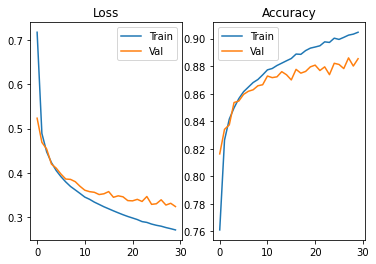

Train:   1%|▏         | 19/1500 [00:00<00:14, 99.90batch/s, loss=1.98, acc=23.1]

Epoch 1 of 30


Train:   1%|          | 13/1500 [00:00<00:17, 85.86batch/s, loss=0.421, acc=80.4]

Val Acc 0.8105
Epoch 2 of 30


Train:   2%|▏         | 24/1500 [00:00<00:10, 138.56batch/s, loss=0.434, acc=83.9]

Val Acc 0.8355
Epoch 3 of 30


Train:   2%|▏         | 27/1500 [00:00<00:10, 139.71batch/s, loss=0.616, acc=83.6]

Val Acc 0.841
Epoch 4 of 30


Train:   1%|          | 15/1500 [00:00<00:18, 81.24batch/s, loss=0.461, acc=84.8]

Val Acc 0.8456666666666667
Epoch 5 of 30


Train:   1%|▏         | 20/1500 [00:00<00:13, 107.16batch/s, loss=0.322, acc=84.5]

Val Acc 0.8441666666666666
Epoch 6 of 30


Train:   2%|▏         | 25/1500 [00:00<00:10, 144.80batch/s, loss=0.494, acc=85.6]

Val Acc 0.85
Epoch 7 of 30


Train:   1%|          | 11/1500 [00:00<00:14, 104.93batch/s, loss=0.729, acc=81.5]

Val Acc 0.8479166666666667
Epoch 8 of 30


Train:   1%|▏         | 20/1500 [00:00<00:14, 99.32batch/s, loss=0.615, acc=87.8]

Val Acc 0.8490833333333333
Epoch 9 of 30


Train:   1%|▏         | 20/1500 [00:00<00:13, 107.07batch/s, loss=0.411, acc=87.9]

Val Acc 0.85375
Epoch 10 of 30


Train:   1%|          | 15/1500 [00:00<00:26, 56.01batch/s, loss=0.65, acc=85.5] 

Val Acc 0.8551666666666666
Epoch 11 of 30


Train:   2%|▏         | 23/1500 [00:00<00:11, 128.97batch/s, loss=0.296, acc=84.4]

Val Acc 0.8501666666666666
Epoch 12 of 30


Train:   1%|          | 17/1500 [00:00<00:17, 85.49batch/s, loss=0.61, acc=85.4] 

Val Acc 0.8466666666666667
Epoch 13 of 30


Train:   1%|▏         | 22/1500 [00:00<00:14, 103.69batch/s, loss=0.418, acc=85.9]

Val Acc 0.8585
Epoch 14 of 30


Train:   1%|▏         | 19/1500 [00:00<00:16, 88.86batch/s, loss=0.441, acc=87]  

Val Acc 0.8569166666666667
Epoch 15 of 30


Train:   1%|          | 16/1500 [00:00<00:15, 92.78batch/s, loss=0.298, acc=85.1]

Val Acc 0.8573333333333333
Epoch 16 of 30


Train:   2%|▏         | 23/1500 [00:00<00:11, 124.79batch/s, loss=0.51, acc=88.2] 

Val Acc 0.8575
Epoch 17 of 30


Train:   1%|▏         | 19/1500 [00:00<00:15, 95.53batch/s, loss=0.267, acc=87.2]

Val Acc 0.8626666666666667
Epoch 18 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 134.01batch/s, loss=0.455, acc=87.9]

Val Acc 0.8601666666666666
Epoch 19 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 122.12batch/s, loss=0.573, acc=87.1]

Val Acc 0.8585
Epoch 20 of 30


Train:   1%|▏         | 20/1500 [00:00<00:16, 91.27batch/s, loss=0.224, acc=87.1]

Val Acc 0.8596666666666667
Epoch 21 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 124.41batch/s, loss=0.294, acc=86.2]

Val Acc 0.862
Epoch 22 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 130.50batch/s, loss=0.297, acc=84.5]

Val Acc 0.8625
Epoch 23 of 30


Train:   1%|▏         | 22/1500 [00:00<00:10, 143.95batch/s, loss=0.318, acc=87.5]

Val Acc 0.8625833333333334
Epoch 24 of 30


Train:   1%|▏         | 22/1500 [00:00<00:13, 106.50batch/s, loss=0.558, acc=88]  

Val Acc 0.8634166666666667
Epoch 25 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 141.24batch/s, loss=0.455, acc=87]  

Val Acc 0.8505833333333334
Epoch 26 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 126.31batch/s, loss=0.246, acc=87]  

Val Acc 0.8558333333333333
Epoch 27 of 30


Train:   1%|          | 8/1500 [00:00<01:02, 23.94batch/s, loss=0.371, acc=86.8]

Val Acc 0.8635
Epoch 28 of 30


Train:   2%|▏         | 24/1500 [00:00<00:12, 115.47batch/s, loss=0.213, acc=88]  

Val Acc 0.8654166666666666
Epoch 29 of 30


Train:   1%|          | 14/1500 [00:00<00:11, 126.29batch/s, loss=0.42, acc=86.5] 

Val Acc 0.8625
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:03<00:00, 117.92batch/s, loss=0.293, acc=86.1]


Val Acc 0.8609166666666667


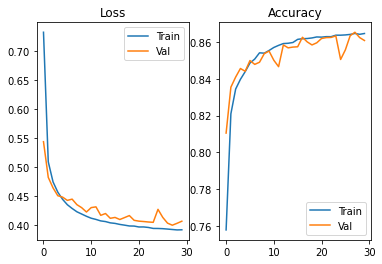

Train:   1%|▏         | 21/1500 [00:00<00:12, 114.34batch/s, loss=1.29, acc=48.3] 

Epoch 1 of 30


Train:   1%|          | 13/1500 [00:00<00:25, 57.37batch/s, loss=0.309, acc=86.8]

Val Acc 0.8491666666666666
Epoch 2 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 117.70batch/s, loss=0.597, acc=87.6]

Val Acc 0.8595
Epoch 3 of 30


Train:   1%|          | 14/1500 [00:00<00:27, 55.03batch/s, loss=0.343, acc=87.7]

Val Acc 0.85625
Epoch 4 of 30


Train:   1%|▏         | 19/1500 [00:00<00:15, 94.02batch/s, loss=0.382, acc=88.1]

Val Acc 0.8631666666666666
Epoch 5 of 30


Train:   1%|          | 13/1500 [00:00<00:22, 65.02batch/s, loss=0.392, acc=87.1]

Val Acc 0.872
Epoch 6 of 30


Train:   1%|          | 16/1500 [00:00<00:16, 89.08batch/s, loss=0.436, acc=89.9] 

Val Acc 0.8694166666666666
Epoch 7 of 30


Train:   2%|▏         | 26/1500 [00:00<00:10, 137.44batch/s, loss=0.393, acc=91.3]

Val Acc 0.8674166666666666
Epoch 8 of 30


Train:   1%|▏         | 19/1500 [00:00<00:12, 121.16batch/s, loss=0.162, acc=90.2]

Val Acc 0.8694166666666666
Epoch 9 of 30


Train:   1%|▏         | 20/1500 [00:00<00:12, 118.23batch/s, loss=0.253, acc=88.4]

Val Acc 0.8611666666666666
Epoch 10 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 110.16batch/s, loss=0.371, acc=88.8] 

Val Acc 0.87825
Epoch 11 of 30


Train:   1%|          | 17/1500 [00:00<00:14, 99.67batch/s, loss=0.311, acc=90.8]

Val Acc 0.879
Epoch 12 of 30


Train:   1%|          | 15/1500 [00:00<00:11, 124.19batch/s, loss=0.28, acc=89.3] 

Val Acc 0.8786666666666667
Epoch 13 of 30


Train:   1%|▏         | 21/1500 [00:00<00:14, 103.85batch/s, loss=0.221, acc=90.5]

Val Acc 0.8764166666666666
Epoch 14 of 30


Train:   1%|▏         | 22/1500 [00:00<00:12, 114.44batch/s, loss=0.161, acc=91]   

Val Acc 0.8824166666666666
Epoch 15 of 30


Train:   2%|▏         | 25/1500 [00:00<00:10, 144.04batch/s, loss=0.153, acc=92.8] 

Val Acc 0.8794166666666666
Epoch 16 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 129.49batch/s, loss=0.205, acc=89.9] 

Val Acc 0.8869166666666667
Epoch 17 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 118.31batch/s, loss=0.131, acc=90.6] 

Val Acc 0.88
Epoch 18 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 126.83batch/s, loss=0.489, acc=92.2] 

Val Acc 0.889
Epoch 19 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 132.15batch/s, loss=0.0783, acc=90.9]

Val Acc 0.8889166666666667
Epoch 20 of 30


Train:   1%|          | 14/1500 [00:00<00:20, 71.90batch/s, loss=0.107, acc=92.3] 

Val Acc 0.8751666666666666
Epoch 21 of 30


Train:   1%|          | 15/1500 [00:00<00:12, 119.95batch/s, loss=0.199, acc=90.6]

Val Acc 0.8839166666666667
Epoch 22 of 30


Train:   1%|          | 18/1500 [00:00<00:15, 95.20batch/s, loss=0.281, acc=92.1] 

Val Acc 0.8880833333333333
Epoch 23 of 30


Train:   1%|          | 15/1500 [00:00<00:29, 50.66batch/s, loss=0.185, acc=91.4]

Val Acc 0.8861666666666667
Epoch 24 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 128.73batch/s, loss=0.117, acc=93.2] 

Val Acc 0.8935833333333333
Epoch 25 of 30


Train:   0%|          | 7/1500 [00:00<00:28, 52.11batch/s, loss=0.151, acc=93.8] 

Val Acc 0.8846666666666667
Epoch 26 of 30


Train:   1%|          | 10/1500 [00:00<00:52, 28.62batch/s, loss=0.256, acc=91.5]

Val Acc 0.887
Epoch 27 of 30


Train:   1%|▏         | 20/1500 [00:00<00:13, 109.25batch/s, loss=0.279, acc=93.5] 

Val Acc 0.8859166666666667
Epoch 28 of 30


Train:   1%|          | 18/1500 [00:00<00:18, 79.98batch/s, loss=0.0657, acc=92.8]

Val Acc 0.8905833333333333
Epoch 29 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 106.27batch/s, loss=0.174, acc=94.5] 

Val Acc 0.8915833333333333
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:03<00:00, 120.48batch/s, loss=0.0927, acc=88.2]


Val Acc 0.8824166666666666


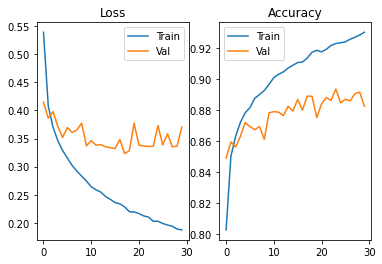

Train:   2%|▏         | 23/1500 [00:00<00:11, 131.62batch/s, loss=1.24, acc=47.9] 

Epoch 1 of 30


Train:   1%|          | 13/1500 [00:00<00:12, 117.81batch/s, loss=0.558, acc=84.2]

Val Acc 0.84575
Epoch 2 of 30


Train:   2%|▏         | 25/1500 [00:00<00:12, 120.83batch/s, loss=0.433, acc=86.4]

Val Acc 0.8589166666666667
Epoch 3 of 30


Train:   1%|          | 18/1500 [00:00<00:12, 117.61batch/s, loss=0.428, acc=88.3]

Val Acc 0.8405833333333333
Epoch 4 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 121.21batch/s, loss=0.255, acc=88.2]

Val Acc 0.8495833333333334
Epoch 5 of 30


Train:   2%|▏         | 29/1500 [00:00<00:09, 149.58batch/s, loss=0.197, acc=87.4]

Val Acc 0.8641666666666666
Epoch 6 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 133.99batch/s, loss=0.321, acc=87.1]

Val Acc 0.8733333333333333
Epoch 7 of 30


Train:   1%|▏         | 22/1500 [00:00<00:14, 103.75batch/s, loss=0.354, acc=84.6]

Val Acc 0.8661666666666666
Epoch 8 of 30


Train:   2%|▏         | 24/1500 [00:00<00:12, 121.21batch/s, loss=0.252, acc=87.5]

Val Acc 0.87075
Epoch 9 of 30


Train:   1%|          | 13/1500 [00:00<00:50, 29.23batch/s, loss=0.226, acc=90]  

Val Acc 0.8735833333333334
Epoch 10 of 30


Train:   1%|          | 12/1500 [00:00<00:19, 76.98batch/s, loss=0.254, acc=89.4] 

Val Acc 0.863
Epoch 11 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 133.34batch/s, loss=0.229, acc=89.2]

Val Acc 0.8791666666666667
Epoch 12 of 30


Train:   1%|          | 15/1500 [00:00<00:31, 47.16batch/s, loss=0.421, acc=88.7] 

Val Acc 0.8638333333333333
Epoch 13 of 30


Train:   1%|          | 15/1500 [00:00<00:18, 78.56batch/s, loss=0.257, acc=90.4]

Val Acc 0.876
Epoch 14 of 30


Train:   1%|          | 11/1500 [00:00<00:24, 59.99batch/s, loss=0.187, acc=90.9]

Val Acc 0.8714166666666666
Epoch 15 of 30


Train:   1%|▏         | 21/1500 [00:00<00:12, 122.29batch/s, loss=0.373, acc=89.6]

Val Acc 0.8756666666666667
Epoch 16 of 30


Train:   2%|▏         | 23/1500 [00:00<00:10, 135.19batch/s, loss=0.474, acc=88.4]

Val Acc 0.86875
Epoch 17 of 30


Train:   1%|▏         | 20/1500 [00:00<00:13, 111.88batch/s, loss=0.524, acc=90.5]

Val Acc 0.87825
Epoch 18 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 116.87batch/s, loss=0.297, acc=89.6] 

Val Acc 0.87875
Epoch 19 of 30


Train:   1%|          | 12/1500 [00:00<00:15, 98.89batch/s, loss=0.142, acc=91.6] 

Val Acc 0.8828333333333334
Epoch 20 of 30


Train:   1%|          | 16/1500 [00:00<00:22, 67.19batch/s, loss=0.174, acc=89.2]

Val Acc 0.85825
Epoch 21 of 30


Train:   2%|▏         | 27/1500 [00:00<00:10, 138.48batch/s, loss=0.25, acc=88.8] 

Val Acc 0.878
Epoch 22 of 30


Train:   1%|          | 13/1500 [00:00<00:16, 89.35batch/s, loss=0.186, acc=89.5]

Val Acc 0.8721666666666666
Epoch 23 of 30


Train:   1%|▏         | 20/1500 [00:00<00:13, 110.43batch/s, loss=0.166, acc=90.2]

Val Acc 0.8740833333333333
Epoch 24 of 30


Train:   1%|▏         | 19/1500 [00:00<00:14, 102.86batch/s, loss=0.293, acc=88.3]

Val Acc 0.8663333333333333
Epoch 25 of 30


Train:   2%|▏         | 24/1500 [00:00<00:11, 123.22batch/s, loss=0.449, acc=88.4]

Val Acc 0.8819166666666667
Epoch 26 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 121.04batch/s, loss=0.548, acc=90.4]

Val Acc 0.8759166666666667
Epoch 27 of 30


Train:   1%|▏         | 19/1500 [00:00<00:16, 92.55batch/s, loss=0.368, acc=90.5] 

Val Acc 0.88025
Epoch 28 of 30


Train:   1%|▏         | 19/1500 [00:00<00:14, 102.76batch/s, loss=0.301, acc=89.2]

Val Acc 0.8653333333333333
Epoch 29 of 30


Train:   1%|▏         | 20/1500 [00:00<00:12, 114.42batch/s, loss=0.15, acc=90.9] 

Val Acc 0.8811666666666667
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:03<00:00, 112.61batch/s, loss=0.127, acc=86.8]


Val Acc 0.868


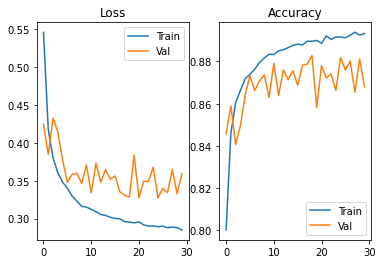

Train:   2%|▏         | 25/1500 [00:00<00:11, 125.45batch/s, loss=1.15, acc=48.4] 

Epoch 1 of 30


Train:   1%|▏         | 22/1500 [00:00<00:12, 113.83batch/s, loss=0.717, acc=80]  

Val Acc 0.7985833333333333
Epoch 2 of 30


Train:   1%|▏         | 20/1500 [00:00<00:12, 115.89batch/s, loss=0.391, acc=81.8]

Val Acc 0.8156666666666667
Epoch 3 of 30


Train:   1%|▏         | 19/1500 [00:00<00:17, 86.48batch/s, loss=0.755, acc=83.3]

Val Acc 0.8183333333333334
Epoch 4 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 129.24batch/s, loss=0.598, acc=83.2]

Val Acc 0.8258333333333333
Epoch 5 of 30


Train:   2%|▏         | 23/1500 [00:00<00:11, 132.05batch/s, loss=0.423, acc=82.9]

Val Acc 0.8351666666666666
Epoch 6 of 30


Train:   1%|          | 18/1500 [00:00<00:17, 83.03batch/s, loss=0.608, acc=82.9]

Val Acc 0.8410833333333333
Epoch 7 of 30


Train:   1%|▏         | 19/1500 [00:00<00:14, 105.55batch/s, loss=0.231, acc=81.2]

Val Acc 0.8090833333333334
Epoch 8 of 30


Train:   1%|          | 17/1500 [00:00<00:11, 132.62batch/s, loss=0.419, acc=86.1]

Val Acc 0.8276666666666667
Epoch 9 of 30


Train:   1%|▏         | 21/1500 [00:00<00:12, 116.68batch/s, loss=0.634, acc=82.8]

Val Acc 0.8150833333333334
Epoch 10 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 131.63batch/s, loss=0.607, acc=82]  

Val Acc 0.8209166666666666
Epoch 11 of 30


Train:   1%|          | 9/1500 [00:00<00:31, 47.10batch/s, loss=0.406, acc=80.6]

Val Acc 0.8166666666666667
Epoch 12 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 107.54batch/s, loss=0.459, acc=82.8]

Val Acc 0.8263333333333334
Epoch 13 of 30


Train:   1%|          | 16/1500 [00:00<00:15, 97.86batch/s, loss=0.632, acc=80.3]

Val Acc 0.8049166666666666
Epoch 14 of 30


Train:   1%|          | 17/1500 [00:00<00:16, 89.42batch/s, loss=0.263, acc=81.6]

Val Acc 0.8208333333333333
Epoch 15 of 30


Train:   1%|          | 18/1500 [00:00<00:14, 103.15batch/s, loss=0.61, acc=83.6] 

Val Acc 0.8436666666666667
Epoch 16 of 30


Train:   1%|▏         | 22/1500 [00:00<00:13, 111.89batch/s, loss=0.451, acc=80.6]

Val Acc 0.83075
Epoch 17 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 112.40batch/s, loss=0.451, acc=82.5]

Val Acc 0.8339166666666666
Epoch 18 of 30


Train:   1%|          | 13/1500 [00:00<00:19, 74.96batch/s, loss=0.433, acc=82.1]

Val Acc 0.8305833333333333
Epoch 19 of 30


Train:   1%|▏         | 22/1500 [00:00<00:12, 117.33batch/s, loss=0.388, acc=82.3]

Val Acc 0.84
Epoch 20 of 30


Train:   1%|          | 16/1500 [00:00<00:17, 87.04batch/s, loss=0.303, acc=84.6]

Val Acc 0.821
Epoch 21 of 30


Train:   2%|▏         | 25/1500 [00:00<00:11, 131.31batch/s, loss=0.563, acc=81.7]

Val Acc 0.8248333333333333
Epoch 22 of 30


Train:   1%|          | 16/1500 [00:00<00:14, 99.15batch/s, loss=0.381, acc=84.2] 

Val Acc 0.8358333333333333
Epoch 23 of 30


Train:   1%|          | 17/1500 [00:00<00:12, 118.01batch/s, loss=0.477, acc=84.4]

Val Acc 0.8184166666666667
Epoch 24 of 30


Train:   1%|▏         | 20/1500 [00:00<00:16, 88.79batch/s, loss=0.456, acc=83.3]

Val Acc 0.8390833333333333
Epoch 25 of 30


Train:   1%|          | 9/1500 [00:00<00:34, 43.33batch/s, loss=0.383, acc=83.4]

Val Acc 0.8333333333333334
Epoch 26 of 30


Train:   1%|          | 13/1500 [00:00<00:14, 100.33batch/s, loss=0.223, acc=85.7]

Val Acc 0.83425
Epoch 27 of 30


Train:   1%|          | 18/1500 [00:00<00:16, 90.51batch/s, loss=0.407, acc=80.3]

Val Acc 0.8008333333333333
Epoch 28 of 30


Train:   1%|          | 18/1500 [00:00<00:15, 97.85batch/s, loss=0.478, acc=82.6]

Val Acc 0.80225
Epoch 29 of 30


Train:   1%|          | 12/1500 [00:00<00:17, 83.42batch/s, loss=0.374, acc=84.9]

Val Acc 0.8291666666666667
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:04<00:00, 85.35batch/s, loss=0.368, acc=83.9] 


Val Acc 0.8394166666666667


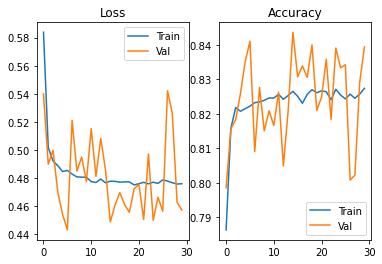

In [27]:
## this function is from Prof. Chugg's fmnist_mlp_torch.ipynb
## https://github.com/keithchugg/ee559_spring2023/blob/main/lecture/fmnist_mlp_torch.ipynb
# Run training and validation loop
# Save the best model based on validation accuracy
batchsize = 32
# Shuffle the data at the start of each epoch (only useful for training set)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)

for m in [80]:
  for l in [0.01, 0.1]:
    for wd in [1e-4,1e-3,1e-2]:
      model = MLP(m)
      model.to(device)
      criterion = nn.CrossEntropyLoss() # includes softmax (for numerical stability)
      optimizer = optim.SGD(model.parameters(), lr=l, weight_decay=wd)
      n_epochs = 30
      best_acc = -1
      train_loss_history = []; train_acc_history = []
      val_loss_history = []; val_acc_history = []
      for epoch in range(n_epochs): # Iterate over epochs
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
        valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
        testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)
        print(f"Epoch {epoch+1} of {n_epochs}")
        train_loss, train_acc  = train(model, trainloader, criterion, optimizer,device) # Train
        val_loss, val_acc = validate(model, valloader, criterion,device) # Validate
        train_loss_history.append(train_loss); train_acc_history.append(train_acc)
        val_loss_history.append(val_loss); val_acc_history.append(val_acc)
        print(f"Val Acc {val_acc}")
      acc_dict[f"{m}_{l}_{wd}"] = val_acc_history[-1]
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
      ax1.plot(range(30), train_loss_history, label='Train')
      ax1.plot(range(30), val_loss_history, label='Val')
      ax2.plot(range(30),train_acc_history , label='Train')
      ax2.plot(range(30),val_acc_history , label='Val')
      ax1.set_title('Loss')
      ax2.set_title('Accuracy')
      ax1.legend()
      ax2.legend()
      plt.show()
        

Train:   1%|          | 14/1500 [00:00<00:22, 66.54batch/s, loss=1.98, acc=32.1]

Epoch 1 of 30


Train:   1%|          | 12/1500 [00:00<00:31, 47.36batch/s, loss=0.659, acc=81]  

Val Acc 0.8190833333333334
Epoch 2 of 30


Train:   1%|          | 11/1500 [00:00<00:24, 62.00batch/s, loss=0.545, acc=84.9]

Val Acc 0.837
Epoch 3 of 30


Train:   1%|▏         | 21/1500 [00:00<00:12, 119.93batch/s, loss=0.398, acc=84.5]

Val Acc 0.8384166666666667
Epoch 4 of 30


Train:   1%|▏         | 20/1500 [00:00<00:12, 118.74batch/s, loss=0.445, acc=86]  

Val Acc 0.8499166666666667
Epoch 5 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 112.64batch/s, loss=0.343, acc=86.4]

Val Acc 0.8574166666666667
Epoch 6 of 30


Train:   1%|          | 12/1500 [00:00<00:17, 85.14batch/s, loss=0.325, acc=90.1]

Val Acc 0.8640833333333333
Epoch 7 of 30


Train:   1%|          | 9/1500 [00:00<00:20, 73.22batch/s, loss=0.32, acc=87.2] 

Val Acc 0.8639166666666667
Epoch 8 of 30


Train:   1%|          | 17/1500 [00:00<00:12, 121.96batch/s, loss=0.402, acc=85.8]

Val Acc 0.86575
Epoch 9 of 30


Train:   1%|▏         | 22/1500 [00:00<00:12, 116.18batch/s, loss=0.312, acc=87.5]

Val Acc 0.8676666666666667
Epoch 10 of 30


Train:   1%|          | 16/1500 [00:00<00:17, 84.53batch/s, loss=0.179, acc=87.3] 

Val Acc 0.8705833333333334
Epoch 11 of 30


Train:   1%|          | 18/1500 [00:00<00:12, 117.38batch/s, loss=0.26, acc=88.8] 

Val Acc 0.8715
Epoch 12 of 30


Train:   1%|          | 15/1500 [00:00<00:12, 117.55batch/s, loss=0.359, acc=88.7]

Val Acc 0.87575
Epoch 13 of 30


Train:   1%|          | 17/1500 [00:00<00:14, 101.07batch/s, loss=0.194, acc=89.4] 

Val Acc 0.87175
Epoch 14 of 30


Train:   1%|▏         | 19/1500 [00:00<00:15, 96.34batch/s, loss=0.316, acc=90.6]

Val Acc 0.8719166666666667
Epoch 15 of 30


Train:   1%|▏         | 19/1500 [00:00<00:14, 101.24batch/s, loss=0.147, acc=86.6]

Val Acc 0.88175
Epoch 16 of 30


Train:   1%|          | 16/1500 [00:00<00:16, 89.89batch/s, loss=0.233, acc=87.5]

Val Acc 0.8769166666666667
Epoch 17 of 30


Train:   1%|▏         | 20/1500 [00:00<00:13, 106.04batch/s, loss=0.329, acc=91.5]

Val Acc 0.8800833333333333
Epoch 18 of 30


Train:   1%|▏         | 20/1500 [00:00<00:14, 102.11batch/s, loss=0.149, acc=88.4]

Val Acc 0.8829166666666667
Epoch 19 of 30


Train:   1%|          | 18/1500 [00:00<00:14, 102.38batch/s, loss=0.344, acc=91.4]

Val Acc 0.879
Epoch 20 of 30


Train:   1%|          | 18/1500 [00:00<00:14, 102.48batch/s, loss=0.45, acc=91.9] 

Val Acc 0.8809166666666667
Epoch 21 of 30


Train:   1%|          | 14/1500 [00:00<00:18, 80.23batch/s, loss=0.227, acc=88.5]

Val Acc 0.88375
Epoch 22 of 30


Train:   1%|          | 18/1500 [00:00<00:17, 84.28batch/s, loss=0.41, acc=90]   

Val Acc 0.88725
Epoch 23 of 30


Train:   1%|          | 14/1500 [00:00<00:14, 104.19batch/s, loss=0.148, acc=91.7] 

Val Acc 0.8816666666666667
Epoch 24 of 30


Train:   1%|          | 14/1500 [00:00<00:14, 103.42batch/s, loss=0.251, acc=91.2]

Val Acc 0.8865
Epoch 25 of 30


Train:   1%|▏         | 19/1500 [00:00<00:15, 93.73batch/s, loss=0.165, acc=90.9]

Val Acc 0.8876666666666667
Epoch 26 of 30


Train:   1%|          | 12/1500 [00:00<00:31, 47.15batch/s, loss=0.303, acc=89.7]

Val Acc 0.8835
Epoch 27 of 30


Train:   1%|          | 17/1500 [00:00<00:16, 92.64batch/s, loss=0.134, acc=91.8] 

Val Acc 0.88925
Epoch 28 of 30


Train:   1%|          | 8/1500 [00:00<00:25, 58.31batch/s, loss=0.482, acc=90.6]

Val Acc 0.8888333333333334
Epoch 29 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 112.28batch/s, loss=0.178, acc=92.5]

Val Acc 0.8874166666666666
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:04<00:00, 83.62batch/s, loss=0.136, acc=88.6]  


Val Acc 0.8858333333333334


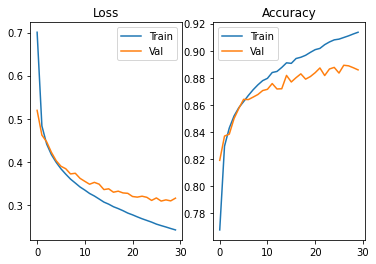

Train:   1%|▏         | 19/1500 [00:00<00:14, 100.91batch/s, loss=2.01, acc=26.1]

Epoch 1 of 30


Train:   1%|          | 11/1500 [00:00<00:25, 58.44batch/s, loss=0.465, acc=82.6]

Val Acc 0.81075
Epoch 2 of 30


Train:   1%|▏         | 22/1500 [00:00<00:13, 113.27batch/s, loss=0.758, acc=83]  

Val Acc 0.8380833333333333
Epoch 3 of 30


Train:   1%|          | 8/1500 [00:00<01:21, 18.30batch/s, loss=0.594, acc=82.6]

Val Acc 0.8405
Epoch 4 of 30


Train:   1%|▏         | 22/1500 [00:00<00:12, 116.08batch/s, loss=0.389, acc=85.7]

Val Acc 0.8511666666666666
Epoch 5 of 30


Train:   0%|          | 7/1500 [00:00<00:38, 38.28batch/s, loss=0.529, acc=82.1]

Val Acc 0.8520833333333333
Epoch 6 of 30


Train:   1%|          | 18/1500 [00:00<00:12, 114.84batch/s, loss=0.328, acc=85.2]

Val Acc 0.8615
Epoch 7 of 30


Train:   1%|▏         | 21/1500 [00:00<00:14, 105.63batch/s, loss=0.316, acc=88.5]

Val Acc 0.8613333333333333
Epoch 8 of 30


Train:   1%|▏         | 20/1500 [00:00<00:14, 105.12batch/s, loss=0.369, acc=87.1]

Val Acc 0.8629166666666667
Epoch 9 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 108.01batch/s, loss=0.369, acc=88.8]

Val Acc 0.8620833333333333
Epoch 10 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 106.55batch/s, loss=0.691, acc=87.9]

Val Acc 0.8685
Epoch 11 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 110.09batch/s, loss=0.163, acc=87.5]

Val Acc 0.8645833333333334
Epoch 12 of 30


Train:   1%|          | 12/1500 [00:00<00:31, 46.97batch/s, loss=0.195, acc=90.9]

Val Acc 0.8761666666666666
Epoch 13 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 115.22batch/s, loss=0.28, acc=87.2] 

Val Acc 0.8750833333333333
Epoch 14 of 30


Train:   1%|          | 18/1500 [00:00<00:13, 111.67batch/s, loss=0.371, acc=89.6]

Val Acc 0.8788333333333334
Epoch 15 of 30


Train:   1%|          | 12/1500 [00:00<00:17, 85.55batch/s, loss=0.256, acc=90.4]

Val Acc 0.8746666666666667
Epoch 16 of 30


Train:   1%|          | 11/1500 [00:00<00:25, 57.69batch/s, loss=0.506, acc=89.8]

Val Acc 0.881
Epoch 17 of 30


Train:   1%|          | 15/1500 [00:00<00:20, 73.62batch/s, loss=0.28, acc=88.3] 

Val Acc 0.88
Epoch 18 of 30


Train:   1%|          | 13/1500 [00:00<00:14, 104.86batch/s, loss=0.225, acc=90.6]

Val Acc 0.8839166666666667
Epoch 19 of 30


Train:   1%|          | 12/1500 [00:00<00:32, 45.36batch/s, loss=0.162, acc=87.7]

Val Acc 0.8824166666666666
Epoch 20 of 30


Train:   1%|          | 13/1500 [00:00<00:15, 96.94batch/s, loss=0.241, acc=88.4]

Val Acc 0.8804166666666666
Epoch 21 of 30


Train:   1%|          | 15/1500 [00:00<00:16, 92.66batch/s, loss=0.239, acc=91]  

Val Acc 0.8821666666666667
Epoch 22 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 109.00batch/s, loss=0.194, acc=87.9]

Val Acc 0.8804166666666666
Epoch 23 of 30


Train:   1%|          | 17/1500 [00:00<00:14, 99.61batch/s, loss=0.313, acc=89.9]

Val Acc 0.88375
Epoch 24 of 30


Train:   1%|▏         | 20/1500 [00:00<00:14, 99.59batch/s, loss=0.2, acc=91.2]  

Val Acc 0.8850833333333333
Epoch 25 of 30


Train:   1%|▏         | 20/1500 [00:00<00:15, 97.73batch/s, loss=0.398, acc=91.1]

Val Acc 0.8843333333333333
Epoch 26 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 107.76batch/s, loss=0.423, acc=90.1]

Val Acc 0.8855833333333333
Epoch 27 of 30


Train:   2%|▏         | 23/1500 [00:00<00:12, 119.88batch/s, loss=0.178, acc=91.9]

Val Acc 0.8863333333333333
Epoch 28 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 111.39batch/s, loss=0.27, acc=89.5] 

Val Acc 0.8901666666666667
Epoch 29 of 30


Train:   1%|▏         | 19/1500 [00:00<00:13, 106.75batch/s, loss=0.353, acc=89.5]

Val Acc 0.8903333333333333
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:03<00:00, 102.76batch/s, loss=0.188, acc=88.5]


Val Acc 0.8849166666666667


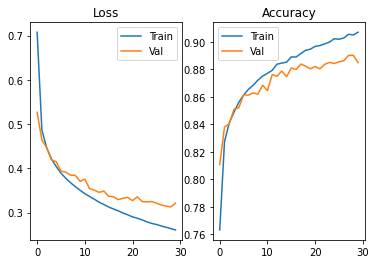

Train:   1%|          | 17/1500 [00:00<00:20, 74.13batch/s, loss=1.99, acc=32.8]

Epoch 1 of 30


Train:   1%|          | 16/1500 [00:00<00:21, 69.84batch/s, loss=0.824, acc=82.4]

Val Acc 0.8113333333333334
Epoch 2 of 30


Train:   1%|▏         | 19/1500 [00:00<00:14, 102.65batch/s, loss=0.395, acc=83.4]

Val Acc 0.8326666666666667
Epoch 3 of 30


Train:   1%|▏         | 19/1500 [00:00<00:12, 122.28batch/s, loss=0.436, acc=85.6]

Val Acc 0.843
Epoch 4 of 30


Train:   1%|          | 18/1500 [00:00<00:12, 114.39batch/s, loss=0.532, acc=83.4]

Val Acc 0.8438333333333333
Epoch 5 of 30


Train:   1%|          | 14/1500 [00:00<00:18, 79.21batch/s, loss=0.23, acc=81.5] 

Val Acc 0.84725
Epoch 6 of 30


Train:   1%|          | 8/1500 [00:00<00:46, 32.41batch/s, loss=0.429, acc=90.3]

Val Acc 0.8529166666666667
Epoch 7 of 30


Train:   1%|          | 12/1500 [00:00<00:24, 60.98batch/s, loss=0.303, acc=86.3]

Val Acc 0.8533333333333334
Epoch 8 of 30


Train:   1%|          | 13/1500 [00:00<00:22, 64.66batch/s, loss=0.452, acc=85]  

Val Acc 0.8515833333333334
Epoch 9 of 30


Train:   1%|          | 10/1500 [00:00<00:52, 28.18batch/s, loss=0.382, acc=84.9]

Val Acc 0.85425
Epoch 10 of 30


Train:   1%|          | 12/1500 [00:00<00:32, 45.65batch/s, loss=0.301, acc=87.3]

Val Acc 0.85425
Epoch 11 of 30


Train:   1%|▏         | 19/1500 [00:00<00:11, 129.19batch/s, loss=0.734, acc=85.9]

Val Acc 0.8470833333333333
Epoch 12 of 30


Train:   1%|▏         | 20/1500 [00:00<00:14, 102.81batch/s, loss=0.202, acc=83.6]

Val Acc 0.8565
Epoch 13 of 30


Train:   1%|▏         | 19/1500 [00:00<00:15, 97.44batch/s, loss=0.166, acc=88.3]

Val Acc 0.8611666666666666
Epoch 14 of 30


Train:   1%|▏         | 21/1500 [00:00<00:13, 108.51batch/s, loss=0.217, acc=86.9]

Val Acc 0.8604166666666667
Epoch 15 of 30


Train:   1%|          | 18/1500 [00:00<00:13, 108.85batch/s, loss=0.511, acc=85.7]

Val Acc 0.8606666666666667
Epoch 16 of 30


Train:   1%|          | 15/1500 [00:00<00:12, 117.28batch/s, loss=0.559, acc=83.8]

Val Acc 0.8625
Epoch 17 of 30


Train:   1%|▏         | 21/1500 [00:00<00:12, 119.57batch/s, loss=0.411, acc=86.9]

Val Acc 0.86
Epoch 18 of 30


Train:   1%|▏         | 22/1500 [00:00<00:11, 131.14batch/s, loss=0.621, acc=86]  

Val Acc 0.8614166666666667
Epoch 19 of 30


Train:   1%|▏         | 19/1500 [00:00<00:12, 122.37batch/s, loss=0.445, acc=84.2]

Val Acc 0.86175
Epoch 20 of 30


Train:   1%|          | 17/1500 [00:00<00:10, 141.83batch/s, loss=0.398, acc=86.6]

Val Acc 0.8628333333333333
Epoch 21 of 30


Train:   1%|▏         | 20/1500 [00:00<00:15, 95.16batch/s, loss=0.37, acc=87.1] 

Val Acc 0.8608333333333333
Epoch 22 of 30


Train:   1%|▏         | 21/1500 [00:00<00:12, 120.34batch/s, loss=0.423, acc=87.4]

Val Acc 0.8623333333333333
Epoch 23 of 30


Train:   1%|          | 16/1500 [00:00<00:12, 120.44batch/s, loss=0.407, acc=89]  

Val Acc 0.8603333333333333
Epoch 24 of 30


Train:   2%|▏         | 23/1500 [00:00<00:10, 139.14batch/s, loss=0.243, acc=86.7]

Val Acc 0.8625
Epoch 25 of 30


Train:   1%|          | 16/1500 [00:00<00:16, 92.46batch/s, loss=0.486, acc=87.1]

Val Acc 0.8589166666666667
Epoch 26 of 30


Train:   1%|▏         | 20/1500 [00:00<00:14, 98.76batch/s, loss=0.266, acc=85.1]

Val Acc 0.8589166666666667
Epoch 27 of 30


Train:   1%|▏         | 21/1500 [00:00<00:12, 113.78batch/s, loss=0.441, acc=86.6]

Val Acc 0.8591666666666666
Epoch 28 of 30


Train:   1%|          | 14/1500 [00:00<00:11, 126.75batch/s, loss=0.353, acc=84.6]

Val Acc 0.8626666666666667
Epoch 29 of 30


Train:   1%|▏         | 20/1500 [00:00<00:12, 117.26batch/s, loss=0.556, acc=84.5]

Val Acc 0.86225
Epoch 30 of 30


Eval: 100%|██████████| 375/375 [00:03<00:00, 99.90batch/s, loss=0.264, acc=86.1] 


Val Acc 0.8608333333333333


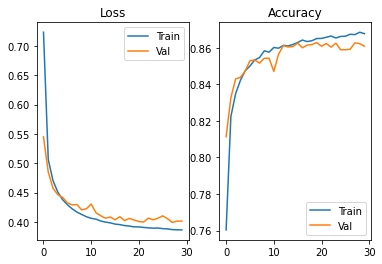

Train:   1%|▏         | 22/1500 [00:00<00:13, 112.30batch/s, loss=1.15, acc=48.1]

Epoch 1 of 30


Train:   1%|          | 17/1500 [00:00<00:15, 95.24batch/s, loss=0.728, acc=83.7]

Val Acc 0.8254166666666667
Epoch 2 of 30


Train:   1%|▏         | 19/1500 [00:00<00:14, 102.84batch/s, loss=0.165, acc=87.5]

Val Acc 0.8639166666666667
Epoch 3 of 30


Train:   1%|▏         | 19/1500 [00:00<00:14, 101.18batch/s, loss=0.292, acc=88.9]

Val Acc 0.867
Epoch 4 of 30


Train:   1%|▏         | 19/1500 [00:00<00:14, 105.50batch/s, loss=0.646, acc=85.3]

Val Acc 0.8556666666666667
Epoch 5 of 30


Train:  63%|██████▎   | 941/1500 [00:12<00:07, 75.25batch/s, loss=0.359, acc=88.3]  


KeyboardInterrupt: 

In [31]:
## this function is from Prof. Chugg's fmnist_mlp_torch.ipynb
## https://github.com/keithchugg/ee559_spring2023/blob/main/lecture/fmnist_mlp_torch.ipynb
# Run training and validation loop
# Save the best model based on validation accuracy
batchsize = 32
# Shuffle the data at the start of each epoch (only useful for training set)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)

for m in [160]:
  for l in [0.01, 0.1]:
    for wd in [1e-4,1e-3,1e-2]:
      model = MLP(m)
      model.to(device)
      criterion = nn.CrossEntropyLoss() # includes softmax (for numerical stability)
      optimizer = optim.SGD(model.parameters(), lr=l, weight_decay=wd)
      n_epochs = 30
      best_acc = -1
      train_loss_history = []; train_acc_history = []
      val_loss_history = []; val_acc_history = []
      for epoch in range(n_epochs): # Iterate over epochs
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
        valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
        testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)
        print(f"Epoch {epoch+1} of {n_epochs}")
        train_loss, train_acc  = train(model, trainloader, criterion, optimizer,device) # Train
        val_loss, val_acc = validate(model, valloader, criterion,device) # Validate
        train_loss_history.append(train_loss); train_acc_history.append(train_acc)
        val_loss_history.append(val_loss); val_acc_history.append(val_acc)
        print(f"Val Acc {val_acc}")
      acc_dict[f"{m}_{l}_{wd}"] = val_acc_history[-1]
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
      ax1.plot(range(30), train_loss_history, label='Train')
      ax1.plot(range(30), val_loss_history, label='Val')
      ax2.plot(range(30),train_acc_history , label='Train')
      ax2.plot(range(30),val_acc_history , label='Val')
      ax1.set_title('Loss')
      ax2.set_title('Accuracy')
      ax1.legend()
      ax2.legend()
      plt.show()
        

In [35]:
acc_dict

{'40_0.001_0.0001': 0.84825,
 '40_0.001_0.001': 0.8486666666666667,
 '40_0.001_0.01': 0.8433333333333334,
 '40_0.01_0.0001': 0.8794166666666666,
 '40_0.01_0.001': 0.8749166666666667,
 '40_0.01_0.01': 0.8615,
 '40_0.1_0.0001': 0.8736666666666667,
 '40_0.1_0.001': 0.8813333333333333,
 '40_0.1_0.01': 0.8225,
 '80_0.001_0.0001': 0.8496666666666667,
 '80_0.001_0.001': 0.8513333333333334,
 '80_0.001_0.01': 0.8439166666666666,
 '80_0.01_0.0001': 0.8799166666666667,
 '80_0.01_0.001': 0.8854166666666666,
 '80_0.01_0.01': 0.8609166666666667,
 '80_0.1_0.0001': 0.8824166666666666,
 '80_0.1_0.001': 0.868,
 '80_0.1_0.01': 0.8394166666666667,
 '160_0.001_0.0001': 0.8510833333333333,
 '160_0.001_0.001': 0.8494166666666667,
 '160_0.001_0.01': 0.8419166666666666,
 '160_0.01_0.0001': 0.8858333333333334,
 '160_0.01_0.001': 0.8849166666666667,
 '160_0.01_0.01': 0.8608333333333333,
 '160_0.1_0.0001': (0.8925833333333333,),
 '160_0.1_0.001': (0.8491666666666666,),
 '160_0.1_0.01': 0.8103333333333333}

In [36]:
## this function is from Prof. Chugg's fmnist_mlp_torch.ipynb
## https://github.com/keithchugg/ee559_spring2023/blob/main/lecture/fmnist_mlp_torch.ipynb
#M=160 lr=0.1 wd=0.0001
i=0
acc = []
while(i<5):
    n_epochs = 100
    best_acc = -1
    train_loss_history = []; train_acc_history = []
    val_loss_history = []; val_acc_history = []
    model = MLP(160)
    model.to(device)
    criterion = nn.CrossEntropyLoss() # includes softmax (for numerical stability)
    optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0001)
    for epoch in range(n_epochs): # Iterate over epochs
        print(f"Epoch {epoch+1} of {n_epochs}")
        train_loss, train_acc  = train(model, trainloader, criterion, optimizer, device) # Train
        val_loss, val_acc = validate(model, valloader, criterion, device) # Validate
        train_loss_history.append(train_loss); train_acc_history.append(train_acc)
        val_loss_history.append(val_loss); val_acc_history.append(val_acc)
        if val_acc > best_acc: # Save best model
            best_acc = val_acc
            filename=f"best_model_{i}.pt"
            torch.save(model.state_dict(), filename)
    acc.append(max(val_acc_history))
    i+=1

Train:   0%|          | 3/1500 [00:00<02:42,  9.23batch/s, loss=1.91, acc=26.6]

Epoch 1 of 100


Train:   1%|▏         | 20/1500 [00:00<00:13, 108.93batch/s, loss=0.493, acc=80.7]

Epoch 2 of 100


Train:   1%|▏         | 20/1500 [00:00<00:13, 107.74batch/s, loss=0.292, acc=85]  

Epoch 3 of 100


Train:   1%|▏         | 19/1500 [00:00<00:13, 106.62batch/s, loss=0.378, acc=88.1]

Epoch 4 of 100


Train:   1%|▏         | 19/1500 [00:00<00:15, 93.18batch/s, loss=0.294, acc=87.3]

Epoch 5 of 100


Train:   1%|          | 17/1500 [00:00<00:16, 89.97batch/s, loss=0.112, acc=91]  

Epoch 6 of 100


Train:   1%|          | 16/1500 [00:00<00:12, 117.05batch/s, loss=0.483, acc=89.5]

Epoch 7 of 100


Train:   1%|          | 18/1500 [00:00<00:14, 104.93batch/s, loss=0.449, acc=89]  

Epoch 8 of 100


Train:   1%|          | 18/1500 [00:00<00:17, 84.86batch/s, loss=0.211, acc=91.3]

Epoch 9 of 100


Train:   1%|          | 16/1500 [00:00<00:11, 126.46batch/s, loss=0.605, acc=89]   

Epoch 10 of 100


Train:   1%|          | 12/1500 [00:00<00:23, 64.20batch/s, loss=0.181, acc=90.4]

Epoch 11 of 100


Train:   1%|▏         | 19/1500 [00:00<00:15, 96.83batch/s, loss=0.124, acc=89.5]

Epoch 12 of 100


Train:   1%|▏         | 19/1500 [00:00<00:15, 97.62batch/s, loss=0.218, acc=90.8]

Epoch 13 of 100


Train:   1%|          | 13/1500 [00:00<00:14, 104.54batch/s, loss=0.196, acc=91.1]

Epoch 14 of 100


Train:   2%|▏         | 26/1500 [00:00<00:10, 140.71batch/s, loss=0.0812, acc=93.3]

Epoch 15 of 100


Train:   1%|▏         | 20/1500 [00:00<00:12, 122.76batch/s, loss=0.0622, acc=92]  

Epoch 16 of 100


Train:   2%|▏         | 24/1500 [00:00<00:11, 127.92batch/s, loss=0.357, acc=91.8] 

Epoch 17 of 100


Train:   2%|▏         | 24/1500 [00:00<00:11, 126.00batch/s, loss=0.107, acc=93.4] 

Epoch 18 of 100


Train:   2%|▏         | 23/1500 [00:00<00:13, 113.26batch/s, loss=0.268, acc=90.4] 

Epoch 19 of 100


Train:   2%|▏         | 23/1500 [00:00<00:10, 136.55batch/s, loss=0.206, acc=94]   

Epoch 20 of 100


Train:   1%|          | 16/1500 [00:00<00:15, 94.65batch/s, loss=0.197, acc=93.2] 

Epoch 21 of 100


Train:   1%|▏         | 19/1500 [00:00<00:15, 93.73batch/s, loss=0.284, acc=93]  

Epoch 22 of 100


Train:   1%|▏         | 20/1500 [00:00<00:10, 135.97batch/s, loss=0.26, acc=93.5]  

Epoch 23 of 100


Train:   1%|          | 18/1500 [00:00<00:13, 108.37batch/s, loss=0.23, acc=92.6] 

Epoch 24 of 100


Train:   1%|▏         | 22/1500 [00:00<00:10, 134.37batch/s, loss=0.183, acc=93.3] 

Epoch 25 of 100


Train:   2%|▏         | 24/1500 [00:00<00:11, 133.79batch/s, loss=0.272, acc=95]   

Epoch 26 of 100


Train:   1%|          | 11/1500 [00:00<00:51, 28.80batch/s, loss=0.0894, acc=91.7]

Epoch 27 of 100


Train:   2%|▏         | 23/1500 [00:00<00:12, 119.08batch/s, loss=0.294, acc=94.9] 

Epoch 28 of 100


Train:   2%|▏         | 23/1500 [00:00<00:12, 122.10batch/s, loss=0.213, acc=94.5] 

Epoch 29 of 100


Train:   1%|          | 18/1500 [00:00<00:11, 127.43batch/s, loss=0.143, acc=93.8] 

Epoch 30 of 100


Train:   1%|▏         | 22/1500 [00:00<00:13, 113.15batch/s, loss=0.0671, acc=94.8]

Epoch 31 of 100


Train:   2%|▏         | 24/1500 [00:00<00:11, 126.90batch/s, loss=0.2, acc=94.6]   

Epoch 32 of 100


Train:   1%|          | 13/1500 [00:00<00:19, 77.75batch/s, loss=0.038, acc=93.8] 

Epoch 33 of 100


Train:   2%|▏         | 25/1500 [00:00<00:10, 136.71batch/s, loss=0.159, acc=93.4] 

Epoch 34 of 100


Train:   2%|▏         | 23/1500 [00:00<00:11, 126.64batch/s, loss=0.206, acc=93.6] 

Epoch 35 of 100


Train:   1%|▏         | 21/1500 [00:00<00:11, 124.82batch/s, loss=0.106, acc=95.5] 

Epoch 36 of 100


Train:   1%|          | 13/1500 [00:00<00:52, 28.14batch/s, loss=0.0368, acc=96]  

Epoch 37 of 100


Train:   2%|▏         | 25/1500 [00:00<00:11, 130.35batch/s, loss=0.017, acc=95.2] 

Epoch 38 of 100


Train:   1%|▏         | 21/1500 [00:00<00:14, 99.19batch/s, loss=0.0133, acc=95.2]

Epoch 39 of 100


Train:   1%|▏         | 21/1500 [00:00<00:13, 107.16batch/s, loss=0.0695, acc=93.9]

Epoch 40 of 100


Train:   2%|▏         | 23/1500 [00:00<00:12, 119.40batch/s, loss=0.133, acc=95.4] 

Epoch 41 of 100


Train:   1%|▏         | 22/1500 [00:00<00:11, 127.05batch/s, loss=0.284, acc=94.2] 

Epoch 42 of 100


Train:   1%|▏         | 22/1500 [00:00<00:12, 117.84batch/s, loss=0.129, acc=95.1] 

Epoch 43 of 100


Train:   1%|▏         | 22/1500 [00:00<00:13, 108.66batch/s, loss=0.117, acc=95.5] 

Epoch 44 of 100


Train:   1%|▏         | 21/1500 [00:00<00:12, 114.14batch/s, loss=0.167, acc=95.6] 

Epoch 45 of 100


Train:   1%|          | 15/1500 [00:00<00:12, 117.26batch/s, loss=0.091, acc=95.1] 

Epoch 46 of 100


Train:   2%|▏         | 25/1500 [00:00<00:11, 125.88batch/s, loss=0.0898, acc=94.2]

Epoch 47 of 100


Train:   1%|▏         | 21/1500 [00:00<00:13, 109.74batch/s, loss=0.0741, acc=95.7]

Epoch 48 of 100


Train:   2%|▏         | 24/1500 [00:00<00:11, 124.79batch/s, loss=0.112, acc=94.8] 

Epoch 49 of 100


Train:   1%|          | 13/1500 [00:00<00:25, 57.67batch/s, loss=0.0587, acc=96.4]

Epoch 50 of 100


Train:   1%|▏         | 21/1500 [00:00<00:14, 99.70batch/s, loss=0.0721, acc=97.3]

Epoch 51 of 100


Train:   2%|▏         | 23/1500 [00:00<00:11, 125.61batch/s, loss=0.267, acc=96.1] 

Epoch 52 of 100


Train:   2%|▏         | 23/1500 [00:00<00:12, 114.66batch/s, loss=0.00486, acc=95.4]

Epoch 53 of 100


Train:   1%|          | 18/1500 [00:00<00:12, 119.81batch/s, loss=0.0821, acc=97.2]

Epoch 54 of 100


Train:   2%|▏         | 25/1500 [00:00<00:11, 131.20batch/s, loss=0.0187, acc=96.2]

Epoch 55 of 100


Train:   2%|▏         | 24/1500 [00:00<00:12, 116.92batch/s, loss=0.067, acc=95.6]  

Epoch 56 of 100


Train:   1%|          | 14/1500 [00:00<00:20, 71.02batch/s, loss=0.0356, acc=96.9]

Epoch 57 of 100


Train:   2%|▏         | 26/1500 [00:00<00:10, 139.45batch/s, loss=0.0475, acc=97.5]

Epoch 58 of 100


Train:   2%|▏         | 24/1500 [00:00<00:11, 123.54batch/s, loss=0.0539, acc=96.5]

Epoch 59 of 100


Train:   1%|          | 18/1500 [00:00<00:17, 86.02batch/s, loss=0.463, acc=96.5] 

Epoch 60 of 100


Train:   1%|▏         | 19/1500 [00:00<00:17, 86.93batch/s, loss=0.115, acc=95.9] 

Epoch 61 of 100


Train:   1%|          | 12/1500 [00:00<00:14, 106.01batch/s, loss=0.073, acc=95]   

Epoch 62 of 100


Train:   1%|          | 17/1500 [00:00<00:17, 86.62batch/s, loss=0.0499, acc=96.7] 

Epoch 63 of 100


Train:   1%|          | 14/1500 [00:00<00:15, 98.81batch/s, loss=0.0523, acc=97.1]

Epoch 64 of 100


Train:   1%|          | 11/1500 [00:00<00:15, 93.73batch/s, loss=0.119, acc=95.3] 

Epoch 65 of 100


Train:   1%|▏         | 20/1500 [00:00<00:13, 113.30batch/s, loss=0.197, acc=95.7] 

Epoch 66 of 100


Train:   2%|▏         | 23/1500 [00:00<00:12, 121.06batch/s, loss=0.137, acc=96.2] 

Epoch 67 of 100


Train:   1%|▏         | 20/1500 [00:00<00:13, 109.64batch/s, loss=0.433, acc=94.5]  

Epoch 68 of 100


Train:   1%|▏         | 22/1500 [00:00<00:12, 115.72batch/s, loss=0.0699, acc=97.7] 

Epoch 69 of 100


Train:   1%|▏         | 19/1500 [00:00<00:13, 107.99batch/s, loss=0.0715, acc=97.7]

Epoch 70 of 100


Train:   1%|          | 18/1500 [00:00<00:12, 119.06batch/s, loss=0.0964, acc=97.4]

Epoch 71 of 100


Train:   1%|▏         | 21/1500 [00:00<00:12, 121.75batch/s, loss=0.179, acc=97.7]  

Epoch 72 of 100


Train:   1%|▏         | 19/1500 [00:00<00:15, 97.75batch/s, loss=0.0285, acc=95.8]

Epoch 73 of 100


Train:   1%|▏         | 20/1500 [00:00<00:14, 102.89batch/s, loss=0.1, acc=95.8]   

Epoch 74 of 100


Train:   1%|▏         | 20/1500 [00:00<00:13, 109.12batch/s, loss=0.0258, acc=96.4]

Epoch 75 of 100


Train:   1%|          | 16/1500 [00:00<00:19, 77.38batch/s, loss=0.229, acc=95.8] 

Epoch 76 of 100


Train:   1%|          | 17/1500 [00:00<00:15, 96.24batch/s, loss=0.0841, acc=97]  

Epoch 77 of 100


Train:   1%|          | 16/1500 [00:00<00:14, 105.45batch/s, loss=0.0164, acc=97.1]

Epoch 78 of 100


Train:   1%|          | 15/1500 [00:00<00:17, 85.24batch/s, loss=0.0971, acc=96.9]

Epoch 79 of 100


Train:   1%|          | 17/1500 [00:00<00:17, 84.00batch/s, loss=0.141, acc=95.1] 

Epoch 80 of 100


Train:   1%|▏         | 22/1500 [00:00<00:12, 115.93batch/s, loss=0.045, acc=97.1] 

Epoch 81 of 100


Train:   1%|          | 17/1500 [00:00<00:18, 82.28batch/s, loss=0.0343, acc=96.5]

Epoch 82 of 100


Train:   0%|          | 7/1500 [00:00<00:37, 40.25batch/s, loss=0.0977, acc=96]  

Epoch 83 of 100


Train:   1%|▏         | 19/1500 [00:00<00:13, 107.38batch/s, loss=0.0251, acc=97.2]

Epoch 84 of 100


Train:   1%|          | 11/1500 [00:00<00:22, 66.17batch/s, loss=0.0589, acc=96.9]

Epoch 85 of 100


Train:   1%|▏         | 19/1500 [00:00<00:14, 102.77batch/s, loss=0.017, acc=98]   

Epoch 86 of 100


Train:   1%|          | 18/1500 [00:00<00:15, 93.83batch/s, loss=0.0749, acc=97.9]

Epoch 87 of 100


Train:   1%|▏         | 19/1500 [00:00<00:16, 87.55batch/s, loss=0.0407, acc=96.1]

Epoch 88 of 100


Train:   1%|          | 15/1500 [00:00<00:19, 76.11batch/s, loss=0.128, acc=98.2] 

Epoch 89 of 100


Train:   1%|          | 12/1500 [00:00<00:17, 84.31batch/s, loss=0.0546, acc=98.1]

Epoch 90 of 100


Train:   1%|▏         | 19/1500 [00:00<00:13, 112.50batch/s, loss=0.0152, acc=97.7]

Epoch 91 of 100


Train:   1%|▏         | 19/1500 [00:00<00:15, 93.01batch/s, loss=0.145, acc=97.7]  

Epoch 92 of 100


Train:   1%|▏         | 19/1500 [00:00<00:14, 105.54batch/s, loss=0.0928, acc=97.2]

Epoch 93 of 100


Train:   1%|          | 16/1500 [00:00<00:18, 78.95batch/s, loss=0.0821, acc=96.1]

Epoch 94 of 100


Train:   1%|          | 17/1500 [00:00<00:15, 93.64batch/s, loss=0.0477, acc=96.5]

Epoch 95 of 100


Train:   0%|          | 5/1500 [00:00<01:08, 21.87batch/s, loss=0.0845, acc=97.4] 

Epoch 96 of 100


Train:   1%|          | 15/1500 [00:00<00:19, 74.93batch/s, loss=0.114, acc=97.1]  

Epoch 97 of 100


Train:   1%|          | 15/1500 [00:00<00:17, 85.05batch/s, loss=0.0893, acc=97.9]

Epoch 98 of 100


Train:   1%|          | 13/1500 [00:00<00:31, 46.92batch/s, loss=0.191, acc=97.5] 

Epoch 99 of 100


Train:   1%|▏         | 19/1500 [00:00<00:14, 99.21batch/s, loss=0.0533, acc=96.7]

Epoch 100 of 100


Train:   1%|▏         | 19/1500 [00:00<00:14, 98.95batch/s, loss=0.916, acc=48] 

Epoch 1 of 100


Train:   1%|▏         | 19/1500 [00:00<00:15, 97.80batch/s, loss=0.39, acc=80.5] 

Epoch 2 of 100


Train:   1%|          | 10/1500 [00:00<00:52, 28.35batch/s, loss=0.182, acc=85.8]

Epoch 3 of 100


Train:   0%|          | 7/1500 [00:00<00:46, 31.84batch/s, loss=0.178, acc=90.2]

Epoch 4 of 100


Train:   1%|          | 13/1500 [00:00<00:12, 114.93batch/s, loss=0.248, acc=91.3]

Epoch 5 of 100


Train:   1%|▏         | 22/1500 [00:00<00:12, 120.11batch/s, loss=0.247, acc=90.2]

Epoch 6 of 100


Train:   1%|          | 9/1500 [00:00<00:57, 26.11batch/s, loss=0.225, acc=88.4]

Epoch 7 of 100


Train:   0%|          | 6/1500 [00:00<00:41, 35.95batch/s, loss=0.233, acc=85.7]

Epoch 8 of 100


Train:   1%|          | 17/1500 [00:00<00:16, 89.86batch/s, loss=0.204, acc=91.1]

Epoch 9 of 100


Train:   1%|          | 18/1500 [00:00<00:14, 99.87batch/s, loss=0.173, acc=91.6]

Epoch 10 of 100


Train:   1%|▏         | 22/1500 [00:00<00:12, 115.04batch/s, loss=0.196, acc=91.6]

Epoch 11 of 100


Train:   1%|          | 15/1500 [00:00<00:19, 76.42batch/s, loss=0.172, acc=89.8] 

Epoch 12 of 100


Train:   1%|▏         | 22/1500 [00:00<00:13, 112.14batch/s, loss=0.45, acc=89.9]  

Epoch 13 of 100


Train:   0%|          | 6/1500 [00:00<00:38, 39.08batch/s, loss=0.213, acc=90.6] 

Epoch 14 of 100


Train:   1%|▏         | 20/1500 [00:00<00:14, 104.68batch/s, loss=0.0756, acc=93.6]

Epoch 15 of 100


Train:   1%|          | 11/1500 [00:00<00:26, 57.07batch/s, loss=0.435, acc=91.1]

Epoch 16 of 100


Train:   1%|          | 17/1500 [00:00<00:17, 84.92batch/s, loss=0.19, acc=92.9] 

Epoch 17 of 100


Train:   1%|▏         | 21/1500 [00:00<00:13, 111.72batch/s, loss=0.229, acc=89.8]

Epoch 18 of 100


Train:   1%|          | 18/1500 [00:00<00:16, 89.70batch/s, loss=0.0455, acc=94.9]

Epoch 19 of 100


Train:   1%|          | 14/1500 [00:00<00:21, 70.40batch/s, loss=0.173, acc=94]   

Epoch 20 of 100


Train:   1%|          | 17/1500 [00:00<00:16, 87.70batch/s, loss=0.0748, acc=93.1]

Epoch 21 of 100


Train:   1%|          | 12/1500 [00:00<00:15, 93.60batch/s, loss=0.17, acc=95.4]  

Epoch 22 of 100


Train:   1%|          | 18/1500 [00:00<00:15, 95.66batch/s, loss=0.0896, acc=93.3]

Epoch 23 of 100


Train:   1%|          | 10/1500 [00:00<00:53, 27.96batch/s, loss=0.102, acc=94.3]

Epoch 24 of 100


Train:   1%|          | 9/1500 [00:00<00:38, 38.56batch/s, loss=0.0978, acc=96.6]

Epoch 25 of 100


Train:   1%|          | 18/1500 [00:00<00:16, 89.98batch/s, loss=0.21, acc=95.4]  

Epoch 26 of 100


Train:   1%|          | 18/1500 [00:00<00:17, 86.73batch/s, loss=0.261, acc=92.8] 

Epoch 27 of 100


Train:   1%|          | 17/1500 [00:00<00:16, 87.43batch/s, loss=0.0574, acc=94.8]

Epoch 28 of 100


Train:   1%|▏         | 19/1500 [00:00<00:15, 96.86batch/s, loss=0.238, acc=93.4] 

Epoch 29 of 100


Train:   1%|          | 16/1500 [00:00<00:13, 112.99batch/s, loss=0.0795, acc=95.4]

Epoch 30 of 100


Train:   1%|▏         | 20/1500 [00:00<00:13, 111.62batch/s, loss=0.0494, acc=95.7]

Epoch 31 of 100


Train:   1%|          | 18/1500 [00:00<00:15, 97.36batch/s, loss=0.11, acc=93.9]  

Epoch 32 of 100


Train:   1%|          | 18/1500 [00:00<00:15, 93.08batch/s, loss=0.155, acc=94.9] 

Epoch 33 of 100


Train:   1%|▏         | 21/1500 [00:00<00:13, 106.96batch/s, loss=0.132, acc=94.6]

Epoch 34 of 100


Train:   1%|▏         | 19/1500 [00:00<00:15, 97.80batch/s, loss=0.313, acc=94.8] 

Epoch 35 of 100


Train:   1%|▏         | 19/1500 [00:00<00:13, 112.84batch/s, loss=0.116, acc=95.8] 

Epoch 36 of 100


Train:   1%|          | 14/1500 [00:00<00:21, 69.63batch/s, loss=0.0352, acc=92.9]

Epoch 37 of 100


Train:   1%|▏         | 21/1500 [00:00<00:12, 115.32batch/s, loss=0.131, acc=95.7] 

Epoch 38 of 100


Train:   1%|▏         | 20/1500 [00:00<00:13, 106.94batch/s, loss=0.046, acc=95.5] 

Epoch 39 of 100


Train:   1%|▏         | 19/1500 [00:00<00:12, 116.04batch/s, loss=0.201, acc=95]   

Epoch 40 of 100


Train:   1%|▏         | 19/1500 [00:00<00:14, 104.80batch/s, loss=0.108, acc=95.3] 

Epoch 41 of 100


Train:   1%|          | 18/1500 [00:00<00:15, 97.90batch/s, loss=0.202, acc=95.4] 

Epoch 42 of 100


Train:   1%|          | 18/1500 [00:00<00:16, 89.02batch/s, loss=0.0625, acc=96.4] 

Epoch 43 of 100


Train:   1%|▏         | 20/1500 [00:00<00:13, 109.00batch/s, loss=0.0305, acc=95.7] 

Epoch 44 of 100


Train:   1%|          | 13/1500 [00:00<00:17, 83.76batch/s, loss=0.0433, acc=97.1]

Epoch 45 of 100


Train:   1%|          | 18/1500 [00:00<00:13, 106.74batch/s, loss=0.128, acc=96.2] 

Epoch 46 of 100


Train:   1%|          | 16/1500 [00:00<00:16, 88.87batch/s, loss=0.0781, acc=96.3]

Epoch 47 of 100


Train:   1%|▏         | 19/1500 [00:00<00:14, 102.29batch/s, loss=0.0594, acc=95.2]

Epoch 48 of 100


Train:   1%|          | 18/1500 [00:00<00:15, 98.15batch/s, loss=0.0386, acc=96.9]

Epoch 49 of 100


Train:   2%|▏         | 23/1500 [00:00<00:12, 118.36batch/s, loss=0.11, acc=96.1]  

Epoch 50 of 100


Train:   1%|          | 12/1500 [00:00<00:31, 47.02batch/s, loss=0.124, acc=96.9] 

Epoch 51 of 100


Train:   2%|▏         | 23/1500 [00:00<00:12, 119.68batch/s, loss=0.04, acc=97.4]   

Epoch 52 of 100


Train:   1%|▏         | 19/1500 [00:00<00:11, 128.43batch/s, loss=0.0808, acc=97]  

Epoch 53 of 100


Train:   2%|▏         | 24/1500 [00:00<00:12, 118.76batch/s, loss=0.0711, acc=95.5]

Epoch 54 of 100


Train:   1%|          | 17/1500 [00:00<00:14, 104.90batch/s, loss=0.263, acc=97.4] 

Epoch 55 of 100


Train:   2%|▏         | 23/1500 [00:00<00:12, 117.09batch/s, loss=0.206, acc=96.7] 

Epoch 56 of 100


Train:   2%|▏         | 25/1500 [00:00<00:11, 131.14batch/s, loss=0.0645, acc=96.2]

Epoch 57 of 100


Train:   1%|▏         | 19/1500 [00:00<00:12, 117.30batch/s, loss=0.0345, acc=95.6]

Epoch 58 of 100


Train:   1%|          | 12/1500 [00:00<00:31, 46.86batch/s, loss=0.122, acc=96.9] 

Epoch 59 of 100


Train:   1%|          | 11/1500 [00:00<00:22, 64.91batch/s, loss=0.0263, acc=97.7]

Epoch 60 of 100


Train:   1%|          | 9/1500 [00:00<00:24, 59.68batch/s, loss=0.163, acc=95.6] 

Epoch 61 of 100


Train:   1%|          | 16/1500 [00:00<00:16, 92.63batch/s, loss=0.0383, acc=97.4]

Epoch 62 of 100


Train:   1%|          | 18/1500 [00:00<00:15, 97.06batch/s, loss=0.00997, acc=97.2]

Epoch 63 of 100


Train:   1%|          | 8/1500 [00:00<00:48, 30.84batch/s, loss=0.0183, acc=96.2]

Epoch 64 of 100


Train:   1%|▏         | 21/1500 [00:00<00:13, 112.81batch/s, loss=0.0374, acc=97.2]

Epoch 65 of 100


Train:   1%|▏         | 20/1500 [00:00<00:14, 104.89batch/s, loss=0.0989, acc=95.4]

Epoch 66 of 100


Train:   1%|▏         | 20/1500 [00:00<00:12, 117.76batch/s, loss=0.118, acc=96]   

Epoch 67 of 100


Train:   1%|▏         | 19/1500 [00:00<00:14, 104.60batch/s, loss=0.0216, acc=97.7]

Epoch 68 of 100


Train:   1%|          | 17/1500 [00:00<00:18, 78.21batch/s, loss=0.0827, acc=97.2]

Epoch 69 of 100


Train:   1%|          | 15/1500 [00:00<00:21, 68.80batch/s, loss=0.074, acc=96.5]  

Epoch 70 of 100


Train:   1%|▏         | 19/1500 [00:00<00:15, 95.83batch/s, loss=0.0895, acc=96.9]

Epoch 71 of 100


Train:   1%|          | 12/1500 [00:00<00:26, 56.99batch/s, loss=0.159, acc=98.1] 

Epoch 72 of 100


Train:   1%|          | 16/1500 [00:00<00:15, 96.18batch/s, loss=0.149, acc=98.3] 

Epoch 73 of 100


Train:   1%|▏         | 21/1500 [00:00<00:14, 105.25batch/s, loss=0.106, acc=96.9]  

Epoch 74 of 100


Train:   1%|▏         | 20/1500 [00:00<00:15, 95.33batch/s, loss=0.061, acc=97.5]  

Epoch 75 of 100


Train:   1%|          | 14/1500 [00:00<00:22, 67.51batch/s, loss=0.0825, acc=97.3]

Epoch 76 of 100


Train:   1%|          | 11/1500 [00:00<00:45, 32.64batch/s, loss=0.017, acc=98.7] 

Epoch 77 of 100


Train:   1%|          | 12/1500 [00:00<00:37, 39.62batch/s, loss=0.0322, acc=96.6]

Epoch 78 of 100


Train:   1%|          | 18/1500 [00:00<00:15, 94.36batch/s, loss=0.0371, acc=95.4] 

Epoch 79 of 100


Train:   1%|          | 9/1500 [00:00<00:34, 42.86batch/s, loss=0.0921, acc=97.5] 

Epoch 80 of 100


Train:   1%|          | 11/1500 [00:00<00:33, 43.89batch/s, loss=0.0393, acc=96.9]

Epoch 81 of 100


Train:   1%|          | 18/1500 [00:00<00:15, 93.74batch/s, loss=0.0695, acc=96.7]

Epoch 82 of 100


Train:   1%|▏         | 22/1500 [00:00<00:12, 117.46batch/s, loss=0.0103, acc=97.4]

Epoch 83 of 100


Train:   1%|          | 16/1500 [00:00<00:13, 109.03batch/s, loss=0.0543, acc=97.4]

Epoch 84 of 100


Train:   1%|          | 13/1500 [00:00<00:27, 54.62batch/s, loss=0.0218, acc=97.3]

Epoch 85 of 100


Train:   1%|▏         | 21/1500 [00:00<00:13, 106.26batch/s, loss=0.0722, acc=97.2]

Epoch 86 of 100


Train:   1%|▏         | 19/1500 [00:00<00:14, 102.86batch/s, loss=0.105, acc=96.1]  

Epoch 87 of 100


Train:   1%|▏         | 20/1500 [00:00<00:14, 103.07batch/s, loss=0.0881, acc=96.3]

Epoch 88 of 100


Train:   1%|          | 11/1500 [00:00<00:19, 77.02batch/s, loss=0.0514, acc=95.8]

Epoch 89 of 100


Train:   1%|▏         | 19/1500 [00:00<00:14, 103.49batch/s, loss=0.243, acc=98.1] 

Epoch 90 of 100


Train:   1%|▏         | 21/1500 [00:00<00:12, 113.99batch/s, loss=0.0189, acc=98.3] 

Epoch 91 of 100


Train:   1%|▏         | 20/1500 [00:00<00:15, 96.98batch/s, loss=0.0148, acc=97.8] 

Epoch 92 of 100


Train:   1%|▏         | 22/1500 [00:00<00:13, 107.88batch/s, loss=0.0648, acc=98.4]

Epoch 93 of 100


Train:   1%|          | 17/1500 [00:00<00:17, 86.29batch/s, loss=0.0595, acc=95.8]

Epoch 94 of 100


Train:   2%|▏         | 25/1500 [00:00<00:10, 135.43batch/s, loss=0.039, acc=97.7] 

Epoch 95 of 100


Train:   1%|          | 16/1500 [00:00<00:12, 123.12batch/s, loss=0.101, acc=98]    

Epoch 96 of 100


Train:   1%|          | 11/1500 [00:00<00:39, 37.23batch/s, loss=0.083, acc=97.9] 

Epoch 97 of 100


Train:   1%|          | 16/1500 [00:00<00:15, 93.55batch/s, loss=0.193, acc=97.4] 

Epoch 98 of 100


Train:   1%|          | 11/1500 [00:00<00:25, 59.31batch/s, loss=0.0477, acc=97.4]

Epoch 99 of 100


Train:   1%|          | 18/1500 [00:00<00:16, 89.59batch/s, loss=0.0162, acc=98]  

Epoch 100 of 100


Train:   1%|▏         | 19/1500 [00:00<00:14, 104.99batch/s, loss=0.795, acc=50.9]

Epoch 1 of 100


Train:   1%|▏         | 20/1500 [00:00<00:13, 112.58batch/s, loss=0.819, acc=83.2]

Epoch 2 of 100


Train:   1%|▏         | 19/1500 [00:00<00:15, 93.57batch/s, loss=0.176, acc=89.8]

Epoch 3 of 100


Train:   1%|          | 15/1500 [00:00<00:16, 88.14batch/s, loss=0.479, acc=89.6]

Epoch 4 of 100


Train:   1%|          | 15/1500 [00:00<00:17, 83.89batch/s, loss=0.187, acc=89.8]

Epoch 5 of 100


Train:   1%|          | 14/1500 [00:00<00:23, 64.50batch/s, loss=0.151, acc=90.4]

Epoch 6 of 100


Train:   1%|          | 18/1500 [00:00<00:17, 86.70batch/s, loss=0.315, acc=90]  

Epoch 7 of 100


Train:   1%|          | 17/1500 [00:00<00:18, 80.90batch/s, loss=0.203, acc=88.2]

Epoch 8 of 100


Train:   1%|▏         | 21/1500 [00:00<00:12, 113.86batch/s, loss=0.179, acc=91.1]

Epoch 9 of 100


Train:   1%|▏         | 21/1500 [00:00<00:13, 106.06batch/s, loss=0.248, acc=88.5]

Epoch 10 of 100


Train:   1%|▏         | 21/1500 [00:00<00:13, 112.11batch/s, loss=0.414, acc=91.5] 

Epoch 11 of 100


Train:   1%|          | 13/1500 [00:00<00:18, 80.39batch/s, loss=0.181, acc=92.4]

Epoch 12 of 100


Train:   1%|          | 18/1500 [00:00<00:14, 99.29batch/s, loss=0.431, acc=91.4] 

Epoch 13 of 100


Train:   1%|▏         | 22/1500 [00:00<00:12, 116.18batch/s, loss=0.184, acc=92.7]

Epoch 14 of 100


Train:   1%|▏         | 19/1500 [00:00<00:13, 106.61batch/s, loss=0.191, acc=93.3] 

Epoch 15 of 100


Train:   1%|▏         | 19/1500 [00:00<00:12, 116.78batch/s, loss=0.187, acc=92.3] 

Epoch 16 of 100


Train:   1%|▏         | 21/1500 [00:00<00:13, 106.38batch/s, loss=0.316, acc=91.3] 

Epoch 17 of 100


Train:   1%|▏         | 21/1500 [00:00<00:13, 112.47batch/s, loss=0.204, acc=92.6] 

Epoch 18 of 100


Train:   1%|          | 12/1500 [00:00<00:17, 87.07batch/s, loss=0.367, acc=89.4]

Epoch 19 of 100


Train:   1%|▏         | 20/1500 [00:00<00:13, 106.55batch/s, loss=0.328, acc=90.8] 

Epoch 20 of 100


Train:   1%|          | 10/1500 [00:00<00:27, 53.55batch/s, loss=0.203, acc=90.6]

Epoch 21 of 100


Train:   1%|          | 15/1500 [00:00<00:14, 99.36batch/s, loss=0.0677, acc=94.1]

Epoch 22 of 100


Train:   1%|▏         | 19/1500 [00:00<00:15, 94.77batch/s, loss=0.143, acc=94.1] 

Epoch 23 of 100


Train:   1%|          | 14/1500 [00:00<00:17, 83.52batch/s, loss=0.125, acc=95.8] 

Epoch 24 of 100


Train:   1%|▏         | 20/1500 [00:00<00:13, 106.56batch/s, loss=0.127, acc=94]  

Epoch 25 of 100


Train:   1%|          | 13/1500 [00:00<00:16, 92.12batch/s, loss=0.091, acc=93.5]

Epoch 26 of 100


Train:   1%|          | 18/1500 [00:00<00:15, 93.48batch/s, loss=0.384, acc=94.4] 

Epoch 27 of 100


Train:   1%|          | 9/1500 [00:00<00:21, 70.81batch/s, loss=0.14, acc=92.8]  

Epoch 28 of 100


Train:   1%|          | 10/1500 [00:00<00:52, 28.50batch/s, loss=0.0579, acc=94.9]

Epoch 29 of 100


Train:   1%|          | 17/1500 [00:00<00:16, 90.12batch/s, loss=0.106, acc=93.6]

Epoch 30 of 100


Train:   1%|          | 11/1500 [00:00<00:57, 25.76batch/s, loss=0.121, acc=94.8]

Epoch 31 of 100


Train:   1%|▏         | 20/1500 [00:00<00:14, 102.62batch/s, loss=0.177, acc=95.5] 

Epoch 32 of 100


Train:   1%|▏         | 19/1500 [00:00<00:15, 98.47batch/s, loss=0.043, acc=94.7] 

Epoch 33 of 100


Train:   1%|▏         | 20/1500 [00:00<00:13, 107.27batch/s, loss=0.0879, acc=95.7]

Epoch 34 of 100


Train:   1%|▏         | 21/1500 [00:00<00:13, 105.76batch/s, loss=0.204, acc=95]   

Epoch 35 of 100


Train:   1%|          | 15/1500 [00:00<00:19, 77.73batch/s, loss=0.0836, acc=93.8]

Epoch 36 of 100


Train:   1%|▏         | 19/1500 [00:00<00:15, 95.88batch/s, loss=0.186, acc=96.6] 

Epoch 37 of 100


Train:   1%|          | 17/1500 [00:00<00:18, 79.39batch/s, loss=0.0624, acc=95.5]

Epoch 38 of 100


Train:   2%|▏         | 24/1500 [00:00<00:11, 127.12batch/s, loss=0.0969, acc=95.9]

Epoch 39 of 100


Train:   1%|▏         | 21/1500 [00:00<00:15, 98.41batch/s, loss=0.174, acc=96.3] 

Epoch 40 of 100


Train:   1%|▏         | 22/1500 [00:00<00:11, 127.45batch/s, loss=0.227, acc=95.2] 

Epoch 41 of 100


Train:   1%|▏         | 19/1500 [00:00<00:14, 104.12batch/s, loss=0.131, acc=95.3] 

Epoch 42 of 100


Train:   1%|          | 18/1500 [00:00<00:15, 95.01batch/s, loss=0.166, acc=95.7] 

Epoch 43 of 100


Train:   1%|          | 13/1500 [00:00<00:25, 58.54batch/s, loss=0.095, acc=95.8] 

Epoch 44 of 100


Train:   1%|▏         | 21/1500 [00:00<00:16, 89.83batch/s, loss=0.193, acc=95.9] 

Epoch 45 of 100


Train:   1%|          | 10/1500 [00:00<00:15, 97.77batch/s, loss=0.118, acc=94.9]

Epoch 46 of 100


Train:   1%|          | 13/1500 [00:00<00:25, 57.81batch/s, loss=0.106, acc=95.1] 

Epoch 47 of 100


Train:   1%|▏         | 20/1500 [00:00<00:14, 101.71batch/s, loss=0.158, acc=96.3] 

Epoch 48 of 100


Train:   1%|          | 15/1500 [00:00<00:22, 65.96batch/s, loss=0.163, acc=97.1] 

Epoch 49 of 100


Train:   2%|▏         | 23/1500 [00:00<00:12, 122.75batch/s, loss=0.145, acc=95.3] 

Epoch 50 of 100


Train:   1%|          | 15/1500 [00:00<00:52, 28.29batch/s, loss=0.085, acc=96.9] 

Epoch 51 of 100


Train:   2%|▏         | 24/1500 [00:00<00:12, 117.29batch/s, loss=0.153, acc=96.6] 

Epoch 52 of 100


Train:   2%|▏         | 24/1500 [00:00<00:11, 124.09batch/s, loss=0.00342, acc=95.8]

Epoch 53 of 100


Train:   2%|▏         | 25/1500 [00:00<00:11, 125.23batch/s, loss=0.0567, acc=95.9]

Epoch 54 of 100


Train:   2%|▏         | 23/1500 [00:00<00:11, 124.79batch/s, loss=0.0232, acc=95.4]

Epoch 55 of 100


Train:   2%|▏         | 24/1500 [00:00<00:10, 140.69batch/s, loss=0.095, acc=97.2] 

Epoch 56 of 100


Train:   2%|▏         | 24/1500 [00:00<00:12, 122.58batch/s, loss=0.107, acc=95.8] 

Epoch 57 of 100


Train:   1%|▏         | 22/1500 [00:00<00:14, 103.27batch/s, loss=0.0376, acc=97]  

Epoch 58 of 100


Train:   2%|▏         | 25/1500 [00:00<00:11, 128.16batch/s, loss=0.264, acc=94.8] 

Epoch 59 of 100


Train:   1%|          | 14/1500 [00:00<00:34, 42.90batch/s, loss=0.135, acc=97.7] 

Epoch 60 of 100


Train:   2%|▏         | 23/1500 [00:00<00:11, 126.85batch/s, loss=0.0645, acc=97.3]

Epoch 61 of 100


Train:   2%|▏         | 26/1500 [00:00<00:10, 139.02batch/s, loss=0.029, acc=96.2]  

Epoch 62 of 100


Train:   2%|▏         | 24/1500 [00:00<00:11, 123.15batch/s, loss=0.0692, acc=97.9] 

Epoch 63 of 100


Train:   2%|▏         | 27/1500 [00:00<00:10, 139.92batch/s, loss=0.0329, acc=96.9]

Epoch 64 of 100


Train:   1%|          | 18/1500 [00:00<00:17, 84.03batch/s, loss=0.248, acc=96.4] 

Epoch 65 of 100


Train:   2%|▏         | 27/1500 [00:00<00:10, 143.66batch/s, loss=0.0627, acc=97.5] 

Epoch 66 of 100


Train:   1%|▏         | 21/1500 [00:00<00:11, 126.56batch/s, loss=0.0113, acc=98]   

Epoch 67 of 100


Train:   2%|▏         | 26/1500 [00:00<00:10, 138.81batch/s, loss=0.093, acc=97.2]  

Epoch 68 of 100


Train:   2%|▏         | 25/1500 [00:00<00:11, 128.58batch/s, loss=0.0815, acc=97.2]

Epoch 69 of 100


Train:   1%|          | 18/1500 [00:00<00:17, 84.83batch/s, loss=0.0993, acc=96.4]

Epoch 70 of 100


Train:   1%|          | 11/1500 [00:00<00:38, 38.57batch/s, loss=0.0224, acc=96.9]

Epoch 71 of 100


Train:   2%|▏         | 23/1500 [00:00<00:11, 123.19batch/s, loss=0.0911, acc=97.4] 

Epoch 72 of 100


Train:   1%|          | 16/1500 [00:00<00:18, 79.86batch/s, loss=0.102, acc=97.1] 

Epoch 73 of 100


Train:   1%|▏         | 21/1500 [00:00<00:13, 110.71batch/s, loss=0.122, acc=96.9] 

Epoch 74 of 100


Train:   1%|          | 16/1500 [00:00<00:11, 129.23batch/s, loss=0.102, acc=97.4]  

Epoch 75 of 100


Train:   2%|▏         | 27/1500 [00:00<00:10, 140.91batch/s, loss=0.145, acc=97.5]  

Epoch 76 of 100


Train:   2%|▏         | 23/1500 [00:00<00:12, 122.64batch/s, loss=0.0528, acc=97.9] 

Epoch 77 of 100


Train:   1%|          | 16/1500 [00:00<00:25, 57.46batch/s, loss=0.0217, acc=98.2] 

Epoch 78 of 100


Train:   2%|▏         | 24/1500 [00:00<00:11, 127.58batch/s, loss=0.0515, acc=98.2] 

Epoch 79 of 100


Train:   1%|          | 18/1500 [00:00<00:11, 127.23batch/s, loss=0.0133, acc=95.9]

Epoch 80 of 100


Train:   2%|▏         | 23/1500 [00:00<00:11, 125.02batch/s, loss=0.119, acc=97.1] 

Epoch 81 of 100


Train:   1%|          | 14/1500 [00:00<00:18, 81.04batch/s, loss=0.103, acc=97.5]  

Epoch 82 of 100


Train:   1%|▏         | 21/1500 [00:00<00:10, 142.25batch/s, loss=0.0887, acc=98.6]

Epoch 83 of 100


Train:   2%|▏         | 26/1500 [00:00<00:10, 137.66batch/s, loss=0.0486, acc=98.6] 

Epoch 84 of 100


Train:   1%|          | 12/1500 [00:00<01:18, 18.98batch/s, loss=0.173, acc=96.2] 

Epoch 85 of 100


Train:   2%|▏         | 25/1500 [00:00<00:11, 130.40batch/s, loss=0.0498, acc=96.6]

Epoch 86 of 100


Train:   2%|▏         | 26/1500 [00:00<00:10, 136.75batch/s, loss=0.041, acc=97.3] 

Epoch 87 of 100


Train:   2%|▏         | 27/1500 [00:00<00:10, 142.81batch/s, loss=0.0491, acc=98]   

Epoch 88 of 100


Train:   2%|▏         | 27/1500 [00:00<00:10, 139.32batch/s, loss=0.0166, acc=98.8] 

Epoch 89 of 100


Train:   2%|▏         | 27/1500 [00:00<00:10, 142.22batch/s, loss=0.0646, acc=97.7]

Epoch 90 of 100


Train:   1%|▏         | 22/1500 [00:00<00:12, 118.69batch/s, loss=0.126, acc=98.5]  

Epoch 91 of 100


Train:   2%|▏         | 25/1500 [00:00<00:11, 132.03batch/s, loss=0.0156, acc=96.5]

Epoch 92 of 100


Train:   2%|▏         | 23/1500 [00:00<00:12, 121.15batch/s, loss=0.0283, acc=98.4]

Epoch 93 of 100


Train:   1%|▏         | 22/1500 [00:00<00:12, 117.77batch/s, loss=0.0551, acc=98.4]

Epoch 94 of 100


Train:   1%|▏         | 20/1500 [00:00<00:13, 110.90batch/s, loss=0.0596, acc=97.6] 

Epoch 95 of 100


Train:   2%|▏         | 26/1500 [00:00<00:10, 140.63batch/s, loss=0.0185, acc=97.8] 

Epoch 96 of 100


Train:   2%|▏         | 23/1500 [00:00<00:12, 119.13batch/s, loss=0.0236, acc=96.9]

Epoch 97 of 100


Train:   1%|          | 14/1500 [00:00<00:41, 35.97batch/s, loss=0.0365, acc=97.5]

Epoch 98 of 100


Train:   2%|▏         | 24/1500 [00:00<00:11, 128.36batch/s, loss=0.0983, acc=98.8] 

Epoch 99 of 100


Train:   2%|▏         | 26/1500 [00:00<00:10, 137.11batch/s, loss=0.0927, acc=98.7] 

Epoch 100 of 100


Train:   2%|▏         | 26/1500 [00:00<00:10, 139.32batch/s, loss=1.06, acc=50.8] 

Epoch 1 of 100


Train:   2%|▏         | 26/1500 [00:00<00:10, 136.80batch/s, loss=0.682, acc=81.6]

Epoch 2 of 100


Train:  58%|█████▊    | 877/1500 [00:08<00:06, 98.69batch/s, loss=0.514, acc=85.1] 


KeyboardInterrupt: 

In [39]:
acc.append(0.8956666666666667)
acc.append(0.8954166666666666)

In [40]:
acc

[0.8949166666666667,
 0.8959166666666667,
 0.8966666666666666,
 0.8956666666666667,
 0.8954166666666666]

In [45]:
np.mean(acc)

0.8957166666666666

In [46]:
np.std(acc)

0.0005787918451394897

In [47]:
max(acc)

0.8966666666666666

In [44]:
test_loss, test_acc = validate(model, testloader, criterion, device)
print(f"Test accuracy: {test_acc:.4f}")

Eval: 100%|██████████| 313/313 [00:03<00:00, 87.14batch/s, loss=0.205, acc=88.8]  

Test accuracy: 0.8880


In [42]:
model.load_state_dict(torch.load('best_model_2.pt'))

<All keys matched successfully>

In [53]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [55]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 160]         125,600
              ReLU-2                  [-1, 160]               0
            Linear-3                   [-1, 10]           1,610
Total params: 127,210
Trainable params: 127,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.49
Estimated Total Size (MB): 0.49
----------------------------------------------------------------


In [33]:
## this function is from Prof. Chugg's fmnist_mlp_torch.ipynb
## https://github.com/keithchugg/ee559_spring2023/blob/main/lecture/fmnist_mlp_torch.ipynb
# Run training and validation loop
# Save the best model based on validation accuracy
n_epochs = 3
best_acc = -1
train_loss_history = []; train_acc_history = []
val_loss_history = []; val_acc_history = []
for epoch in range(n_epochs): # Iterate over epochs
    print(f"Epoch {epoch+1} of {n_epochs}")
    train_loss, train_acc  = train(model, trainloader, criterion, optimizer) # Train
    val_loss, val_acc = validate(model, valloader, criterion) # Validate
    train_loss_history.append(train_loss); train_acc_history.append(train_acc)
    val_loss_history.append(val_loss); val_acc_history.append(val_acc)
    print(f"Val Acc {val_acc}")
    if val_acc > best_acc: # Save best model
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt") # saving model parameters ("state_dict") saves memory and is faster than saving the entire model

Epoch 1 of 3


Eval: 100%|██████████| 375/375 [00:05<00:00, 63.68batch/s, loss=0.243, acc=85.1]


Val Acc 0.8514166666666667
Epoch 2 of 3


Eval: 100%|██████████| 375/375 [00:05<00:00, 66.37batch/s, loss=0.206, acc=86.1]


Val Acc 0.8614166666666667
Epoch 3 of 3


Eval: 100%|██████████| 375/375 [00:05<00:00, 66.45batch/s, loss=0.212, acc=86.4]

Val Acc 0.8635833333333334


Question 2

In [2]:
df1= np.load('/content/drive/MyDrive/EE559/Code/HW7_Pr2_datasetA/datasetA_X_test.npy') 
df2= np.load('/content/drive/MyDrive/EE559/Code/HW7_Pr2_datasetA/datasetA_X_train.npy')
df3= np.load('/content/drive/MyDrive/EE559/Code/HW7_Pr2_datasetA/datasetA_y_test.npy') 
df4= np.load('/content/drive/MyDrive/EE559/Code/HW7_Pr2_datasetA/datasetA_y_train.npy')

x_test = df1
x_train=df2
y_test = df3
y_train = df4


In [3]:
y_predicted = np.ones(4000)*np.mean(y_train)
rmse = mean_squared_error(y_train , y_predicted,squared = False)

In [4]:
rmse

3.2035150890062902

In [5]:
def gammas(M):
  gd=M/200
  g=[0.01*gd,0.1*gd,gd,10*gd,100*gd,1000*gd]
  return g

def run_model(X,Y,valX,valY,c,g):
  tx=rbf_kernel(X,c,gamma=g)
  r=LinearRegression()
  r.fit(tx,Y)
  X_rmse=mean_squared_error(Y,r.predict(tx),squared=False)
  val_tx=rbf_kernel(valX,c,gamma=g)
  val_rmse=mean_squared_error(valY,r.predict(val_tx),squared=False)
  return X_rmse,val_rmse

In [6]:
kfold = KFold(4, random_state=None, shuffle=False)
kfold.get_n_splits(x_train)
t_rmse_list=[]
val_rmse_list=[]
fd=dict()
mus=dict()
for i,(ti,vi) in enumerate(kfold.split(x_train)):
  ftx = x_train[ti]
  fty = y_train[ti]
  fvx = x_train[vi]
  fvy = y_train[vi]
  t_rmse_list=[]
  val_rmse_list=[]
  mus[i]=ftx  
  for g in gammas(3000):
    t_rmse,v_rmse= run_model(ftx,fty,fvx,fvy,ftx,g)
    t_rmse_list.append(t_rmse)
    val_rmse_list.append(v_rmse)

    fd[i] = [t_rmse_list,val_rmse_list]



In [7]:
fd
train_rmse = np.array([[fd[0][0]],[fd[1][0]],[fd[2][0]],[fd[3][0]]])
v_rmse = np.array([[fd[0][1]],[fd[1][1]],[fd[2][1]],[fd[3][1]]])

In [8]:
m_train_rmse = np.mean(train_rmse, axis = 0)
std_train_rmse = np.std(train_rmse, axis = 0)

m_v_rmse = np.mean(v_rmse, axis = 0)
std_v_rmse = np.std(v_rmse, axis = 0)

print("Mean of Train RMSE",m_train_rmse)
print("STD of Train RMSE",std_train_rmse)
print("Mean of Validation RMSE",m_v_rmse)
print("STD of Validation RMSE",std_v_rmse)

Mean of Train RMSE [[1.08214191e+00 3.00889787e-02 2.94001992e-08 2.03941532e-12
  1.71453519e-14 1.48594719e-14]]
STD of Train RMSE [[1.41681614e-02 1.96052486e-03 7.37888356e-09 4.73529601e-13
  1.61386267e-15 7.94518815e-16]]
Mean of Validation RMSE [[1.12084791e+00 3.48508178e-02 8.14464632e-07 5.33717408e-03
  1.75161082e+00 2.86882164e+00]]
STD of Validation RMSE [[2.76836370e-02 3.37456989e-03 7.43958219e-07 3.28757045e-03
  3.50427056e-01 4.76147431e-02]]


best gamma = 15

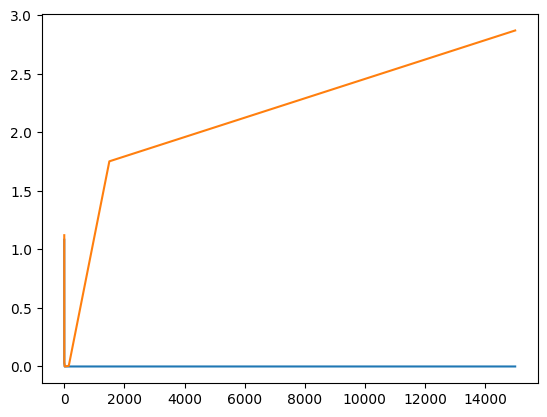

In [9]:
plt.plot(gammas(3000),m_train_rmse.T)
plt.plot(gammas(3000),m_v_rmse.T)

In [10]:
  tx=rbf_kernel(ftx,mus[0],gamma=15)
  r=LinearRegression()
  r.fit(tx,fty)
  y_p=r.predict(rbf_kernel(x_test,mus[0],15))
  mean_squared_error(y_test,y_p,squared=False)

1.9472956416321626e-07

In [11]:
#part d
kfold = KFold(4, random_state=None, shuffle=False)
kfold.get_n_splits(x_train)
t_rmse_list=[]
val_rmse_list=[]
fd=dict()
mu_d=dict()
for i,(ti,vi) in enumerate(kfold.split(x_train)):
  ftx = x_train[ti]
  fty = y_train[ti]
  fvx = x_train[vi]
  fvy = y_train[vi]

  centers_rmse = np.zeros((5,6))
  v_centers_rmse = np.zeros((5,6))
  for m,j in enumerate([30,60,100,300,600]):
    sftx,sfty=shuffle(ftx,fty)
    c=sftx[:j,:]
    mu_d[j]=c
    t_rmse_list=[]
    val_rmse_list=[]
    for g in gammas(j):
      t_rmse,v_rmse= run_model(ftx,fty,fvx,fvy,c,g)
      t_rmse_list.append(t_rmse)
      val_rmse_list.append(v_rmse)
    
    centers_rmse[m] = np.array(t_rmse_list)
    v_centers_rmse[m] = np.array(val_rmse_list)
  fd[i] = [centers_rmse,v_centers_rmse]

In [13]:
fd
train_rmse = np.array([[fd[0][0]],[fd[1][0]],[fd[2][0]],[fd[3][0]]])
v_rmse = np.array([[fd[0][1]],[fd[1][1]],[fd[2][1]],[fd[3][1]]])

In [14]:
v_rmse

array([[[[2.65470305e+00, 2.05067307e+00, 1.50440084e+00,
          1.58689638e+00, 1.95405883e+00, 2.96529925e+00],
         [2.16392074e+00, 1.70104086e+00, 1.19431282e+00,
          9.25668225e-01, 9.84468164e-01, 2.70556023e+00],
         [3.75156151e+00, 1.43343514e+00, 7.14390440e-01,
          2.08839324e-01, 1.15984929e+00, 2.77208500e+00],
         [3.03687951e+00, 1.25647178e+00, 4.69097073e-02,
          6.89191242e-03, 1.14751040e+00, 2.80902204e+00],
         [2.01270754e+00, 8.82162591e-01, 4.31569870e-03,
          3.49240352e-03, 9.66348558e-01, 2.95081546e+00]]],


       [[[2.81538937e+00, 1.90762965e+00, 1.64371940e+00,
          1.60881485e+00, 1.53823210e+00, 2.93021770e+00],
         [2.20254200e+00, 1.52978645e+00, 1.13787892e+00,
          8.51704428e-01, 1.42513047e+00, 2.88216719e+00],
         [3.52648555e+00, 1.44568994e+00, 5.89299343e-01,
          2.10837800e-01, 1.30957608e+00, 2.93052478e+00],
         [2.07645867e+00, 1.18144734e+00, 4.11427132e-02,
  

In [15]:
m_train_rmse = np.mean(train_rmse, axis = 0)
std_train_rmse = np.std(train_rmse, axis = 0)

m_v_rmse = np.mean(v_rmse, axis = 0)
std_v_rmse = np.std(v_rmse, axis = 0)

print("Mean of Train RMSE",m_train_rmse)
print("STD of Train RMSE",std_train_rmse)
print("Mean of Validation RMSE",m_v_rmse)
print("STD of Validation RMSE",std_v_rmse)

Mean of Train RMSE [[[3.13383016e+00 1.96348151e+00 1.57226135e+00 1.56975011e+00
   1.77007748e+00 2.82113643e+00]
  [2.18296538e+00 1.58487390e+00 1.11860874e+00 8.07808895e-01
   1.13763206e+00 2.70660156e+00]
  [3.48894180e+00 1.42871482e+00 6.08668043e-01 1.83893534e-01
   1.16782073e+00 2.78355322e+00]
  [2.56961491e+00 1.17888916e+00 3.88669018e-02 4.27098956e-03
   1.05435251e+00 2.70775357e+00]
  [1.71622583e+00 7.10384488e-01 2.46877780e-03 1.85863242e-03
   8.82271699e-01 2.53698786e+00]]]
STD of Train RMSE [[[5.36512407e-01 8.55142836e-02 8.04292382e-02 3.91794945e-02
   3.51550105e-01 1.32426461e-01]
  [5.65892058e-02 5.73071971e-02 2.92110324e-02 6.64087272e-02
   1.86759389e-01 5.91776790e-02]
  [4.25475384e-01 6.81027726e-03 3.35783301e-02 1.57468977e-02
   7.64548161e-02 4.82708005e-02]
  [4.25719091e-01 4.24825180e-03 3.26437570e-04 4.81163940e-04
   1.05447042e-01 1.88716012e-02]
  [1.64663097e-01 3.44722547e-02 8.66431861e-05 4.15126079e-04
   5.54594944e-02 3.25809

In [16]:
m_v_rmse[0][4]

array([1.75358792, 0.75606478, 0.00349584, 0.00350692, 0.97586754,
       2.84766166])

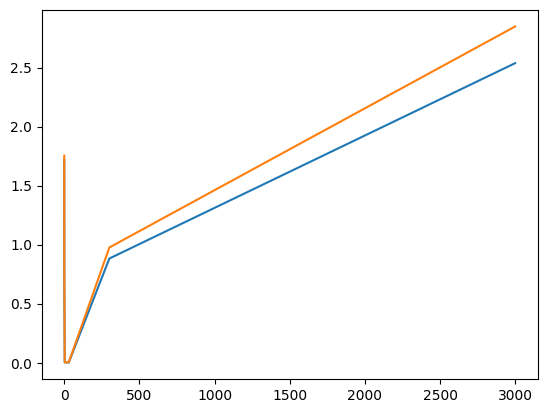

In [17]:
#M=600 g = 30 (best)
plt.plot(gammas(600),m_train_rmse[0][4])
plt.plot(gammas(600),m_v_rmse[0][4])

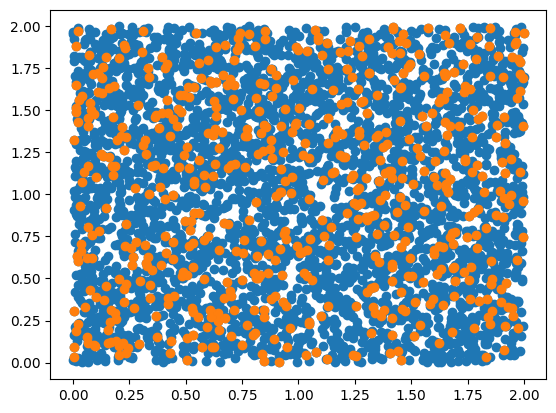

In [18]:
#rcc M=100 g = 5
plt.scatter(x_train[:,0],x_train[:,1])
plt.scatter(mu_d[600][:,0],mu_d[600][:,1])

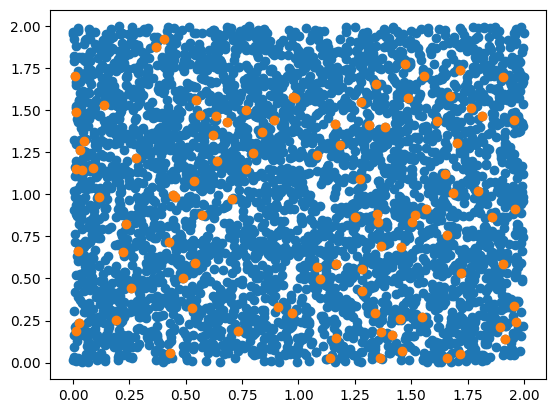

In [19]:
#RCC 
plt.scatter(x_train[:,0],x_train[:,1])
plt.scatter(mu_d[100][:,0],mu_d[100][:,1])

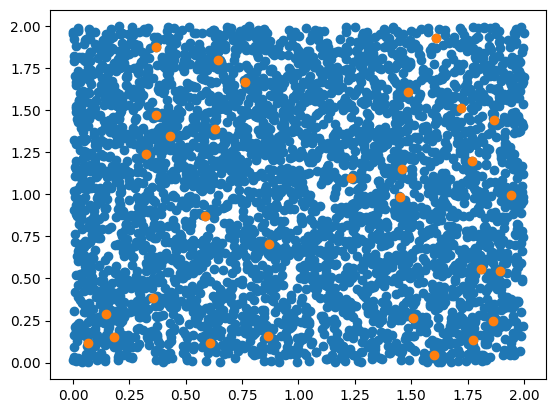

In [20]:
#lowest model
plt.scatter(x_train[:,0],x_train[:,1])
plt.scatter(mu_d[30][:,0],mu_d[30][:,1])

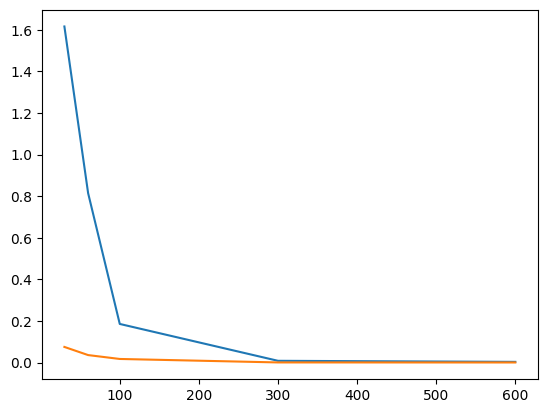

In [23]:
best_g = [1.61588982e+00,8.14434687e-01, 1.85780127e-01,8.55723275e-03,3.46000610e-03]
plt.plot([30,60,100,300,600], best_g)#missing std line
std_data=[7.52828415e-02,3.61077583e-02,1.74317375e-02,7.39591708e-04,5.39785808e-04]
plt.plot([30,60,100,300,600], std_data)

In [ ]:
  tx=rbf_kernel(ftx,mu_d[600],gamma=30)
  d=LinearRegression()
  d.fit(tx,fty)
  y_p=d.predict(rbf_kernel(x_test,mu_d[600],30))
  mean_squared_error(y_test,y_p,squared=False)

0.0034267597574372728

In [ ]:
  tx=rbf_kernel(ftx,mu_d[100],gamma=5)
  d_rcc=LinearRegression()
  d_rcc.fit(tx,fty)
  y_p=d_rcc.predict(rbf_kernel(x_test,mu_d[100],5))
  mean_squared_error(y_test,y_p,squared=False)

0.19637052589152862

In [ ]:
#part d
kfold = KFold(4, random_state=None, shuffle=False)
kfold.get_n_splits(x_train)
t_rmse_list=[]
val_rmse_list=[]
fd=dict()
mu_e=dict()

for i,(ti,vi) in enumerate(kfold.split(x_train)):
  ftx = x_train[ti]
  fty = y_train[ti]
  fvx = x_train[vi]
  fvy = y_train[vi]

  centers_rmse = np.zeros((5,6))
  v_centers_rmse = np.zeros((5,6))
  for m,j in enumerate([30,60,100,300,600]):
    knn = KMeans(n_clusters = j, init="random")
    knn.fit(ftx)
    mu_e[j]=knn.cluster_centers_
    t_rmse_list=[]
    val_rmse_list=[]
    for g in gammas(j):
      t_rmse,v_rmse= run_model(ftx,fty,fvx,fvy,mu_e[j],g)
      t_rmse_list.append(t_rmse)
      val_rmse_list.append(v_rmse)
    
    centers_rmse[m] = np.array(t_rmse_list)
    v_centers_rmse[m] = np.array(val_rmse_list)
  fd[i] = [centers_rmse,v_centers_rmse]

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

In [ ]:
fd
train_rmse = np.array([[fd[0][0]],[fd[1][0]],[fd[2][0]],[fd[3][0]]])
v_rmse = np.array([[fd[0][1]],[fd[1][1]],[fd[2][1]],[fd[3][1]]])

In [ ]:
v_rmse

array([[[[3.00345651e+00, 2.03067380e+00, 1.67617938e+00,
          1.62978927e+00, 1.65244996e+00, 2.86678359e+00],
         [2.38385298e+00, 1.61767639e+00, 1.20348109e+00,
          8.43011253e-01, 6.40776310e-01, 2.71028967e+00],
         [3.77899180e+00, 1.45894839e+00, 6.06326895e-01,
          1.77033481e-01, 5.66939119e-01, 2.70182479e+00],
         [1.91478697e+00, 1.24291177e+00, 4.65795322e-02,
          6.07014865e-03, 4.99939466e-01, 2.74368813e+00],
         [1.70113862e+00, 7.28184600e-01, 3.40193318e-03,
          3.57751600e-03, 5.32227449e-01, 2.89169593e+00]]],


       [[[5.03440757e+00, 2.14405872e+00, 1.53020186e+00,
          1.62551912e+00, 1.78015960e+00, 2.89803639e+00],
         [2.10574009e+00, 1.99588141e+00, 1.15095483e+00,
          8.45107303e-01, 7.11306529e-01, 2.81461448e+00],
         [2.41727167e+00, 1.49346125e+00, 5.73559107e-01,
          1.72005719e-01, 5.53711035e-01, 2.75948493e+00],
         [2.02893185e+00, 1.17879416e+00, 4.04073741e-02,
  

In [ ]:
m_train_rmse = np.mean(train_rmse, axis = 0)
std_train_rmse = np.std(train_rmse, axis = 0)

m_v_rmse = np.mean(v_rmse, axis = 0)
std_v_rmse = np.std(v_rmse, axis = 0)

print("Mean of Train RMSE",m_train_rmse)
print("STD of Train RMSE",std_train_rmse)
print("Mean of Validation RMSE",m_v_rmse)
print("STD of Validation RMSE",std_v_rmse)

Mean of Train RMSE [[[3.56582112e+00 2.36082885e+00 1.54621953e+00 1.63259002e+00
   1.67104527e+00 2.78200644e+00]
  [2.21266085e+00 1.75322824e+00 1.14247135e+00 8.34054171e-01
   7.34897978e-01 2.62439749e+00]
  [2.95335648e+00 1.45736115e+00 5.27612126e-01 1.58406115e-01
   5.13754674e-01 2.53972933e+00]
  [2.27214386e+00 1.16946010e+00 3.82026792e-02 3.92521226e-03
   3.56921736e-01 2.35195135e+00]
  [1.62244987e+00 6.78759464e-01 2.39055347e-03 1.40553335e-03
   3.51635503e-01 2.09214721e+00]]]
STD of Train RMSE [[[8.65359123e-01 3.34017706e-01 8.63006506e-02 2.04751269e-02
   4.14988947e-02 2.46094448e-02]
  [9.47449925e-02 1.12416407e-01 4.47456194e-03 2.41492295e-02
   1.58429484e-01 3.33407114e-02]
  [5.82079440e-01 2.44218283e-02 1.86353581e-02 8.83306777e-03
   7.07212865e-02 2.29579550e-02]
  [3.95411674e-01 8.39001952e-03 3.91969903e-04 4.42177750e-04
   2.30863340e-02 2.58376347e-02]
  [4.62220074e-02 6.00450173e-03 5.08853450e-05 3.15416781e-04
   2.14555284e-02 3.46056

In [ ]:
np.argmin(m_v_rmse)


27

In [ ]:
m_v_rmse[0][4]

array([1.63347598e+00, 7.08320641e-01, 3.24497975e-03, 2.76910425e-03,
       5.41288262e-01, 4.55111541e+00])

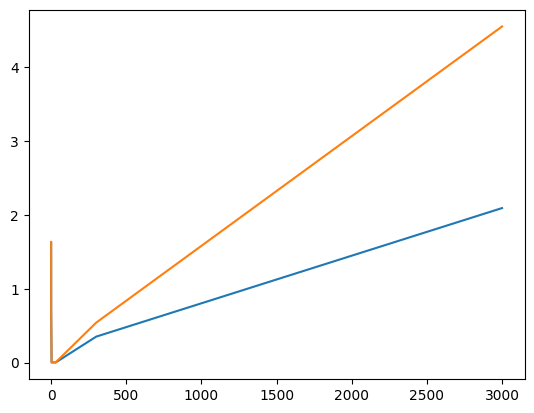

In [ ]:
#M=600 g = 30 (best)
plt.plot(gammas(600),m_train_rmse[0][4])
plt.plot(gammas(600),m_v_rmse[0][4])

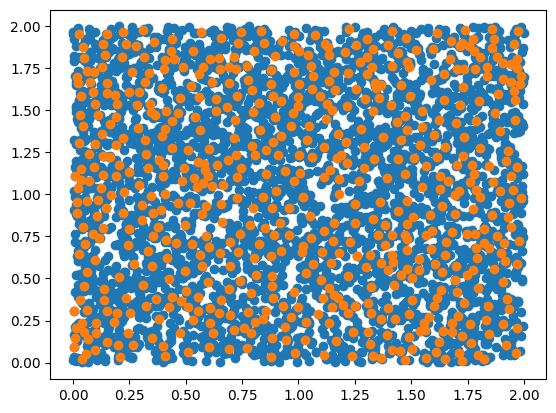

In [ ]:
#rcc M=100 g = 5
plt.scatter(x_train[:,0],x_train[:,1])
plt.scatter(mu_e[600][:,0],mu_e[600][:,1])


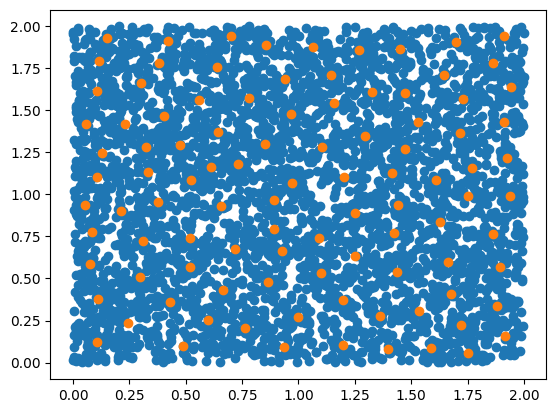

In [ ]:
#rcc M=100 g = 5
plt.scatter(x_train[:,0],x_train[:,1])
plt.scatter(mu_e[100][:,0],mu_e[100][:,1])

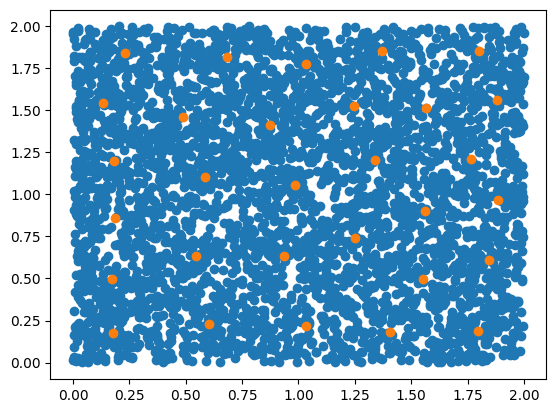

In [ ]:
#rcc M=100 g = 5
plt.scatter(x_train[:,0],x_train[:,1])
plt.scatter(mu_e[30][:,0],mu_e[30][:,1])

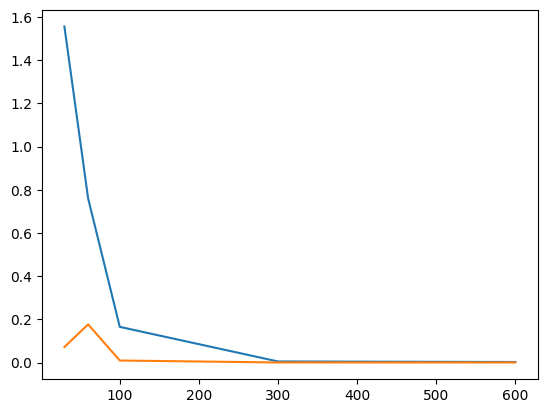

In [ ]:
 data= [1.55541207e+00 ,7.59822003e-01,1.65324743e-01,5.25558291e-03,2.76910425e-03]
 plt.plot([30,60,100,300,600], data)#missing std line
 std_data1=[7.21690898e-02,1.76810163e-01,9.63951128e-03,5.88138892e-04,5.57107987e-04]
 plt.plot([30,60,100,300,600], std_data1)#missing std line

In [ ]:
tx=rbf_kernel(ftx,mu_e[600],gamma=30)
e=LinearRegression()
e.fit(tx,fty)
y_p=e.predict(rbf_kernel(x_test,mu_e[600],30))
mean_squared_error(y_test,y_p,squared=False)

0.002324607659927773

In [ ]:
tx=rbf_kernel(ftx,mu_e[100],gamma=5)
e_rcc=LinearRegression()
e_rcc.fit(tx,fty)
y_p=e_rcc.predict(rbf_kernel(x_test,mu_e[100],5))
mean_squared_error(y_test,y_p,squared=False)

0.15401787961836907

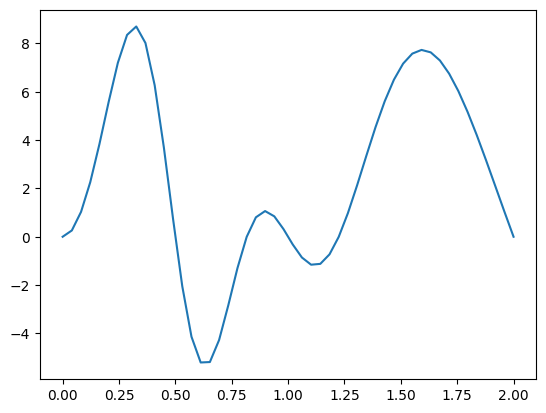

In [ ]:
math.cos(math.pi)
a = np.linspace(0,2)
def fun(a,b):
  val=10*math.cos(math.pi*a/2)*math.sin(5*math.pi/((a**2)+ 1))*math.sin(math.pi*b)
  return val

b=[]
for i in a:
  b.append(fun(i,0.5))

plt.plot(a,b)

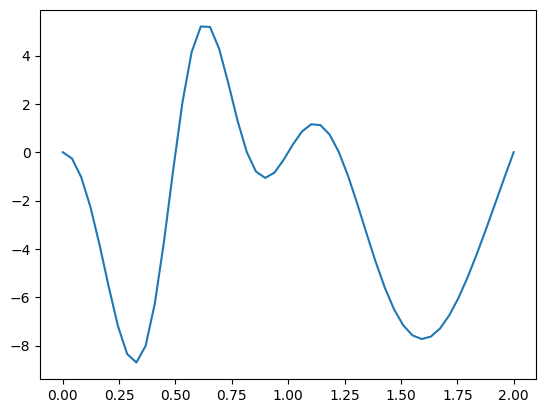

In [ ]:
b=[]
for i in a:
  b.append(fun(i,1.5))

plt.plot(a,b)

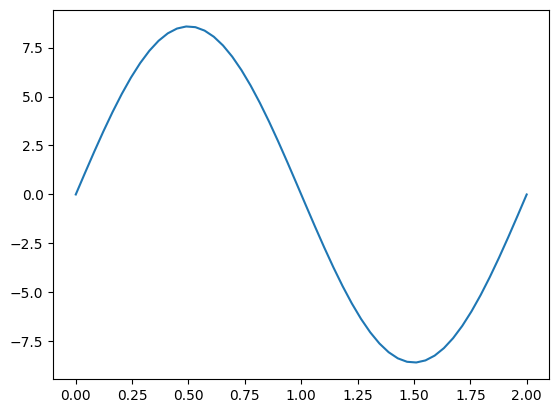

In [ ]:
b=[]
for i in a:
  b.append(fun(0.3,i))

plt.plot(a,b)

In [ ]:
gen_data=np.zeros((50,2))
b=[]
for i in a:
  b.append(fun(i,0.5))

for i in range(50):
  gen_data[i][0] = a[i]
  gen_data[i][1] = 0.5


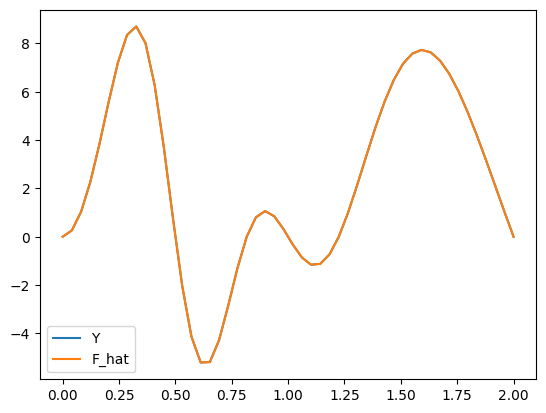

In [ ]:
y_p=r.predict(rbf_kernel(gen_data,mus[0],15))
plt.plot(a,b, label="Y")
plt.plot(a,y_p, label="F_hat")
plt.legend()

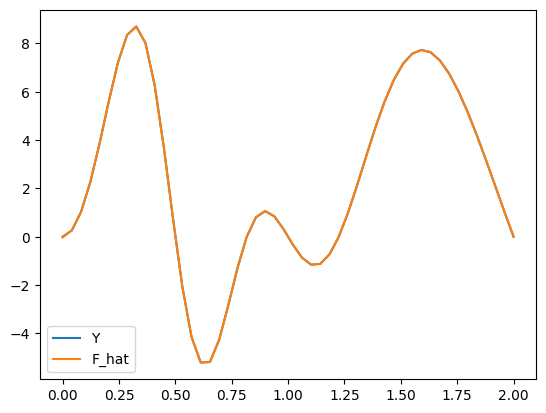

In [ ]:
y_p=d.predict(rbf_kernel(gen_data,mu_d[600],30))
plt.plot(a,b, label="Y")
plt.plot(a,y_p, label="F_hat")
plt.legend()

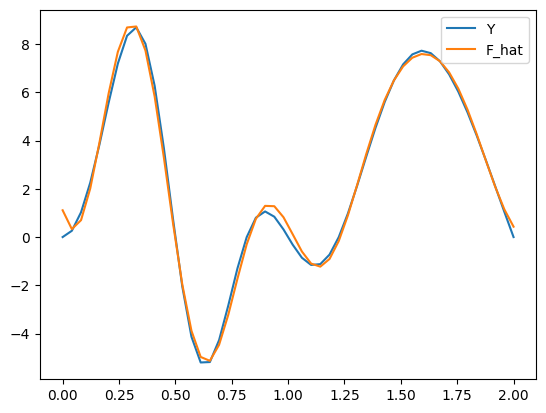

In [ ]:
y_p=d_rcc.predict(rbf_kernel(gen_data,mu_d[100],5))
plt.plot(a,b, label="Y")
plt.plot(a,y_p, label="F_hat")
plt.legend()

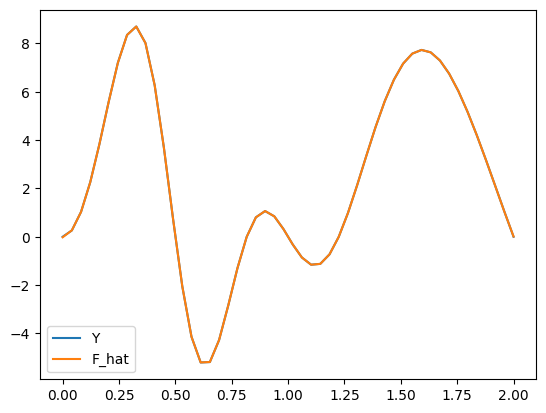

In [ ]:
y_p=e.predict(rbf_kernel(gen_data,mu_e[600],30))
plt.plot(a,b, label="Y")
plt.plot(a,y_p, label="F_hat")
plt.legend()

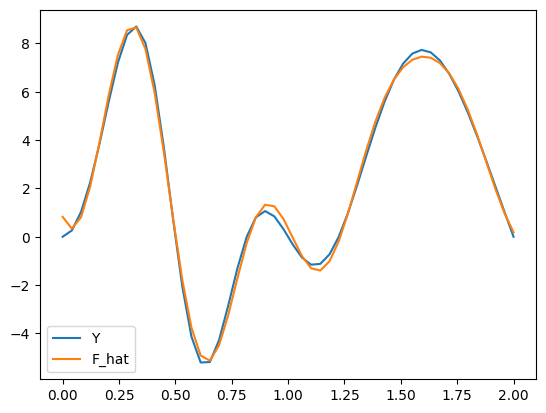

In [ ]:
y_p=e_rcc.predict(rbf_kernel(gen_data,mu_e[100],5))
plt.plot(a,b, label="Y")
plt.plot(a,y_p, label="F_hat")
plt.legend()